<a href="https://colab.research.google.com/github/vatsal-darji/Image_caption_generator/blob/main/ImageCaption_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vatsal Darji - 12002040601066



# Mini project:
#Image Caption Generator using CNN and LSTM


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow keras pillow numpy tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## import all the necessary packages

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import tensorflow
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
# from keras.utils import to_categorical
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

<ipython-input-5-67d0e1185b9c>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

## Getting and performing data cleaning

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip Flickr8k_Dataset.zip -d ./Flickr8k_Dataset
!unzip Flickr8k_text.zip -d ./Flickr8k_text


Streaming output truncated to the last 5000 lines.
  inflating: ./Flickr8k_Dataset/Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: ./Flickr8k_Dataset/__MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: ./Flickr8k_Dataset/Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: ./Flickr8k_Dataset/__MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: ./Flickr8k_Dataset/Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: ./Flickr8k_Dataset/__MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: ./Flickr8k_Dataset/Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: ./Flickr8k_Dataset/__MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: ./Flickr8k_Dataset/Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: ./Flickr8k_Dataset/__MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: ./Flickr8k_Dataset/Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: ./Flickr8k_Dataset/__MA

In [ ]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [ ]:
# Set these path according to project folder in you system
dataset_text = "/content/Flickr8k_text"
dataset_images = "/content/Flickr8k_Dataset"

#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" , len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file
save_descriptions(clean_descriptions, "/content/drive/MyDrive/Image_Caption/descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


## Extracting the feature vector from all images

In [ ]:
import os
import numpy as np
from PIL import Image
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
from tqdm import tqdm
import pickle

def extract_features(directory):
    model = Xception( include_top=False, pooling='avg' )
    features = {}
    for img in tqdm(os.listdir(directory)):
        filename = directory + "/" + img
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)

        feature = model.predict(image)
        features[img] = feature
    return features

# Get the list of image files in the directory
dataset_images = "/content/Flickr8k_Dataset/Flicker8k_Dataset"
images = []
for file in os.listdir(dataset_images):
    if file.endswith(".jpg"):
        images.append(os.path.join(dataset_images, file))

# Extract features
features = extract_features(dataset_images)

# Save features to a file
with open('/content/drive/MyDrive/Image_Caption/Image_Caption/features.pkl', 'wb') as f:
    pickle.dump(features, f)


  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


  0%|          | 1/8091 [00:08<19:02:08,  8.47s/it]

1/1 [==============================] - 0s 21ms/step


  0%|          | 3/8091 [00:08<5:03:19,  2.25s/it] 

1/1 [==============================] - 0s 21ms/step


  0%|          | 5/8091 [00:08<2:32:36,  1.13s/it]

1/1 [==============================] - 0s 21ms/step


  0%|          | 7/8091 [00:08<1:31:48,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 9/8091 [00:09<1:00:44,  2.22it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 11/8091 [00:09<43:00,  3.13it/s] 

1/1 [==============================] - 0s 21ms/step


  0%|          | 13/8091 [00:09<31:50,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 15/8091 [00:09<25:07,  5.36it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 17/8091 [00:09<21:41,  6.20it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 19/8091 [00:09<19:06,  7.04it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 21/8091 [00:10<17:29,  7.69it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 23/8091 [00:10<17:27,  7.70it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 25/8091 [00:10<16:40,  8.06it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 26/8091 [00:10<16:13,  8.29it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 27/8091 [00:10<15:45,  8.53it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 28/8091 [00:10<15:30,  8.66it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 29/8091 [00:11<15:18,  8.78it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 30/8091 [00:11<14:57,  8.98it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 31/8091 [00:11<14:41,  9.14it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 32/8091 [00:11<14:53,  9.02it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 33/8091 [00:11<14:37,  9.19it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 34/8091 [00:11<14:33,  9.22it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 35/8091 [00:11<14:20,  9.37it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 36/8091 [00:11<14:31,  9.24it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 37/8091 [00:11<14:20,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 38/8091 [00:12<16:02,  8.37it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 39/8091 [00:12<15:32,  8.64it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 40/8091 [00:12<15:14,  8.80it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 41/8091 [00:12<15:10,  8.84it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 42/8091 [00:12<15:16,  8.78it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 43/8091 [00:12<15:28,  8.67it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 44/8091 [00:12<15:17,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 45/8091 [00:12<15:04,  8.90it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 46/8091 [00:12<14:45,  9.09it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 48/8091 [00:13<12:25, 10.79it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 50/8091 [00:13<11:42, 11.45it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 52/8091 [00:13<11:24, 11.74it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 54/8091 [00:13<10:53, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 56/8091 [00:13<10:35, 12.65it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 58/8091 [00:13<10:20, 12.94it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 60/8091 [00:13<10:16, 13.03it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 62/8091 [00:14<10:09, 13.18it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 64/8091 [00:14<10:17, 12.99it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 66/8091 [00:14<10:38, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 68/8091 [00:14<10:26, 12.80it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 70/8091 [00:14<10:41, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 72/8091 [00:14<10:36, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 74/8091 [00:15<10:22, 12.89it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 76/8091 [00:15<10:12, 13.09it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 78/8091 [00:15<10:14, 13.05it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 80/8091 [00:15<10:08, 13.17it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 82/8091 [00:15<10:09, 13.15it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 84/8091 [00:15<10:16, 12.98it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 86/8091 [00:15<10:21, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 88/8091 [00:16<10:42, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 90/8091 [00:16<10:50, 12.30it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 92/8091 [00:16<10:47, 12.35it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 94/8091 [00:16<10:46, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 96/8091 [00:16<10:50, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 98/8091 [00:16<10:28, 12.71it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 100/8091 [00:17<10:18, 12.92it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 102/8091 [00:17<10:15, 12.98it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 104/8091 [00:17<10:31, 12.65it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 106/8091 [00:17<10:20, 12.87it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 108/8091 [00:17<10:04, 13.20it/s]

1/1 [==============================] - 0s 47ms/step


  1%|▏         | 110/8091 [00:17<11:29, 11.58it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 112/8091 [00:18<11:00, 12.09it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 114/8091 [00:18<10:48, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 116/8091 [00:18<10:43, 12.39it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 118/8091 [00:18<10:41, 12.42it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 120/8091 [00:18<10:33, 12.57it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 122/8091 [00:18<10:25, 12.75it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 124/8091 [00:19<10:22, 12.80it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 126/8091 [00:19<10:06, 13.13it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 128/8091 [00:19<10:01, 13.23it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 130/8091 [00:19<10:12, 13.00it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 132/8091 [00:19<10:45, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 134/8091 [00:19<10:23, 12.77it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 136/8091 [00:19<10:20, 12.83it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 138/8091 [00:20<10:15, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 140/8091 [00:20<10:15, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 142/8091 [00:20<10:25, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 144/8091 [00:20<10:25, 12.71it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 146/8091 [00:20<10:05, 13.12it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 148/8091 [00:20<10:13, 12.96it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 150/8091 [00:21<10:22, 12.75it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 152/8091 [00:21<10:01, 13.20it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 154/8091 [00:21<09:48, 13.48it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 156/8091 [00:21<10:03, 13.15it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 158/8091 [00:21<10:14, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 160/8091 [00:21<10:26, 12.66it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 162/8091 [00:21<10:19, 12.80it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 164/8091 [00:22<10:10, 12.98it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 166/8091 [00:22<10:21, 12.76it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 168/8091 [00:22<10:34, 12.49it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 170/8091 [00:22<10:34, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 172/8091 [00:22<10:23, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 174/8091 [00:22<10:14, 12.89it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 176/8091 [00:23<11:37, 11.35it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 178/8091 [00:23<12:13, 10.79it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 180/8091 [00:23<12:54, 10.21it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 182/8091 [00:23<13:05, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 184/8091 [00:23<13:11,  9.99it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 186/8091 [00:24<13:33,  9.72it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 187/8091 [00:24<13:42,  9.61it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 188/8091 [00:24<13:54,  9.48it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 189/8091 [00:24<14:15,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 190/8091 [00:24<15:29,  8.50it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 191/8091 [00:24<15:10,  8.68it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 192/8091 [00:24<14:51,  8.86it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 193/8091 [00:24<14:27,  9.10it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 194/8091 [00:25<14:40,  8.97it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 195/8091 [00:25<14:40,  8.97it/s]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 196/8091 [00:25<15:07,  8.70it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 197/8091 [00:25<15:14,  8.63it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 198/8091 [00:25<15:06,  8.71it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 199/8091 [00:25<14:47,  8.89it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 200/8091 [00:25<14:51,  8.85it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 201/8091 [00:25<14:33,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 202/8091 [00:26<14:38,  8.98it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 203/8091 [00:26<15:05,  8.71it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 204/8091 [00:26<15:11,  8.65it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 206/8091 [00:26<14:18,  9.18it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 207/8091 [00:26<14:31,  9.05it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 209/8091 [00:26<12:30, 10.50it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 211/8091 [00:26<11:47, 11.14it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 213/8091 [00:27<11:12, 11.72it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 215/8091 [00:27<10:38, 12.34it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 217/8091 [00:27<10:33, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 219/8091 [00:27<10:25, 12.59it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 221/8091 [00:27<10:37, 12.34it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 223/8091 [00:27<10:21, 12.66it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 225/8091 [00:27<10:20, 12.69it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 227/8091 [00:28<10:14, 12.80it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 229/8091 [00:28<10:10, 12.87it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 231/8091 [00:28<10:20, 12.66it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 233/8091 [00:28<10:18, 12.70it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 235/8091 [00:28<10:09, 12.89it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 237/8091 [00:28<09:58, 13.13it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 239/8091 [00:29<14:59,  8.73it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 241/8091 [00:29<16:06,  8.12it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 242/8091 [00:29<16:44,  7.81it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 243/8091 [00:29<16:30,  7.92it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 244/8091 [00:29<16:49,  7.77it/s]

1/1 [==============================] - 0s 65ms/step


  3%|▎         | 245/8091 [00:30<18:26,  7.09it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 246/8091 [00:30<18:35,  7.03it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 247/8091 [00:30<17:45,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 248/8091 [00:30<19:02,  6.86it/s]

1/1 [==============================] - 0s 83ms/step


  3%|▎         | 249/8091 [00:30<21:11,  6.17it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 250/8091 [00:30<19:29,  6.70it/s]

1/1 [==============================] - 0s 73ms/step


  3%|▎         | 251/8091 [00:31<20:44,  6.30it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 252/8091 [00:31<20:57,  6.23it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 253/8091 [00:31<20:27,  6.39it/s]

1/1 [==============================] - 0s 115ms/step


  3%|▎         | 254/8091 [00:31<24:40,  5.29it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 255/8091 [00:31<22:47,  5.73it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 256/8091 [00:32<23:32,  5.55it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 257/8091 [00:32<23:43,  5.50it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 258/8091 [00:32<22:30,  5.80it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 259/8091 [00:32<21:32,  6.06it/s]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 260/8091 [00:32<21:41,  6.01it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 261/8091 [00:32<20:36,  6.33it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 262/8091 [00:32<19:34,  6.67it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 263/8091 [00:33<20:25,  6.39it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 264/8091 [00:33<19:07,  6.82it/s]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 265/8091 [00:33<19:33,  6.67it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 266/8091 [00:33<19:17,  6.76it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 267/8091 [00:33<19:33,  6.67it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 268/8091 [00:33<21:38,  6.03it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 269/8091 [00:34<20:24,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 271/8091 [00:34<15:59,  8.15it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 273/8091 [00:34<13:53,  9.38it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 275/8091 [00:34<12:39, 10.29it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 277/8091 [00:34<11:53, 10.95it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 279/8091 [00:34<11:21, 11.46it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 281/8091 [00:34<10:51, 11.99it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 283/8091 [00:35<11:01, 11.80it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 285/8091 [00:35<10:45, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 287/8091 [00:35<10:17, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 289/8091 [00:35<10:05, 12.88it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 291/8091 [00:35<10:17, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 293/8091 [00:35<10:03, 12.93it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 295/8091 [00:36<10:21, 12.54it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 297/8091 [00:36<10:16, 12.65it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 299/8091 [00:36<09:59, 13.00it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 301/8091 [00:36<10:07, 12.83it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▎         | 303/8091 [00:36<11:48, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 305/8091 [00:37<12:12, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 307/8091 [00:37<12:53, 10.06it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 309/8091 [00:37<13:18,  9.75it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 310/8091 [00:37<13:28,  9.63it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 311/8091 [00:37<13:37,  9.52it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 312/8091 [00:37<14:43,  8.80it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 313/8091 [00:37<14:29,  8.95it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 314/8091 [00:38<14:20,  9.04it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 315/8091 [00:38<14:12,  9.12it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 316/8091 [00:38<14:04,  9.21it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 317/8091 [00:38<13:47,  9.39it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 318/8091 [00:38<13:50,  9.36it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 319/8091 [00:38<13:38,  9.50it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 320/8091 [00:38<13:35,  9.53it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 321/8091 [00:38<13:33,  9.55it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 322/8091 [00:38<13:33,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 323/8091 [00:38<14:01,  9.23it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 324/8091 [00:39<13:52,  9.33it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 325/8091 [00:39<13:57,  9.28it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 326/8091 [00:39<13:51,  9.34it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 327/8091 [00:39<14:17,  9.06it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 328/8091 [00:39<14:07,  9.16it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 329/8091 [00:39<13:48,  9.37it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 330/8091 [00:39<13:41,  9.45it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 331/8091 [00:39<13:29,  9.59it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 332/8091 [00:39<13:50,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 333/8091 [00:40<14:05,  9.18it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 334/8091 [00:40<14:05,  9.17it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 336/8091 [00:40<12:48, 10.09it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 338/8091 [00:40<11:37, 11.11it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 340/8091 [00:40<11:04, 11.66it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 342/8091 [00:40<10:51, 11.90it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 344/8091 [00:41<14:14,  9.07it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 346/8091 [00:41<13:03,  9.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 348/8091 [00:41<11:55, 10.82it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 350/8091 [00:41<11:30, 11.21it/s]

1/1 [==============================] - 0s 75ms/step


  4%|▍         | 352/8091 [00:41<14:07,  9.13it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 354/8091 [00:42<13:27,  9.59it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 356/8091 [00:42<12:23, 10.41it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 358/8091 [00:42<11:35, 11.12it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▍         | 360/8091 [00:42<12:01, 10.72it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 362/8091 [00:42<13:52,  9.28it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 364/8091 [00:43<12:49, 10.05it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 366/8091 [00:43<11:54, 10.81it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 368/8091 [00:43<11:11, 11.51it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 370/8091 [00:43<11:12, 11.49it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 372/8091 [00:43<11:12, 11.49it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 374/8091 [00:43<10:47, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 376/8091 [00:44<10:28, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 378/8091 [00:44<10:26, 12.30it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 380/8091 [00:44<10:24, 12.36it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 382/8091 [00:44<10:21, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 384/8091 [00:44<11:01, 11.65it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 386/8091 [00:44<11:46, 10.90it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 388/8091 [00:45<11:34, 11.10it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 390/8091 [00:45<11:18, 11.34it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 392/8091 [00:45<10:55, 11.74it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 394/8091 [00:45<10:49, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 396/8091 [00:45<10:52, 11.78it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 398/8091 [00:45<10:53, 11.78it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 400/8091 [00:46<11:06, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 402/8091 [00:46<10:42, 11.97it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 404/8091 [00:46<10:42, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 406/8091 [00:46<10:40, 11.99it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 408/8091 [00:46<10:46, 11.88it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 410/8091 [00:46<10:43, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 412/8091 [00:47<10:35, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 414/8091 [00:47<10:31, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 416/8091 [00:47<10:39, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 418/8091 [00:47<10:37, 12.03it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 420/8091 [00:47<10:31, 12.16it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 422/8091 [00:47<10:23, 12.29it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 424/8091 [00:48<10:29, 12.17it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 426/8091 [00:48<10:47, 11.85it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 428/8091 [00:48<10:34, 12.08it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 430/8091 [00:48<11:13, 11.38it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 432/8091 [00:48<10:55, 11.68it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 434/8091 [00:48<10:47, 11.82it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 436/8091 [00:49<10:44, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 438/8091 [00:49<10:53, 11.70it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 440/8091 [00:49<10:44, 11.87it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 442/8091 [00:49<10:28, 12.17it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 444/8091 [00:49<10:30, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 446/8091 [00:49<10:17, 12.38it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 448/8091 [00:50<10:15, 12.41it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 450/8091 [00:50<10:23, 12.25it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 452/8091 [00:50<12:00, 10.60it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 454/8091 [00:50<13:30,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 455/8091 [00:50<13:28,  9.45it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 456/8091 [00:50<13:27,  9.45it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 457/8091 [00:51<13:33,  9.38it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 458/8091 [00:51<14:17,  8.90it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 459/8091 [00:51<14:19,  8.88it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 460/8091 [00:51<14:32,  8.75it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 461/8091 [00:51<14:47,  8.60it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 462/8091 [00:51<14:51,  8.56it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 463/8091 [00:51<15:02,  8.45it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 464/8091 [00:51<16:14,  7.83it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 465/8091 [00:52<15:28,  8.21it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 466/8091 [00:52<15:17,  8.31it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 467/8091 [00:52<14:47,  8.59it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 468/8091 [00:52<15:08,  8.40it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 469/8091 [00:52<14:59,  8.47it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 470/8091 [00:52<14:47,  8.58it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 471/8091 [00:52<14:30,  8.75it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 472/8091 [00:52<14:17,  8.89it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 473/8091 [00:52<14:29,  8.76it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 474/8091 [00:53<14:25,  8.80it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 475/8091 [00:53<14:25,  8.80it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 476/8091 [00:53<14:58,  8.48it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 477/8091 [00:53<15:14,  8.32it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 478/8091 [00:53<15:21,  8.26it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 479/8091 [00:53<15:34,  8.14it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 480/8091 [00:53<16:54,  7.50it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 481/8091 [00:53<16:03,  7.89it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 483/8091 [00:54<13:31,  9.37it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 485/8091 [00:54<12:22, 10.24it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 487/8091 [00:54<11:55, 10.63it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 489/8091 [00:54<11:31, 10.99it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 491/8091 [00:54<11:08, 11.37it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 493/8091 [00:54<10:44, 11.79it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 495/8091 [00:55<10:34, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 497/8091 [00:55<10:44, 11.79it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 499/8091 [00:55<10:34, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 501/8091 [00:55<10:27, 12.10it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 503/8091 [00:55<10:17, 12.29it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 505/8091 [00:55<10:18, 12.27it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 507/8091 [00:56<10:08, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 509/8091 [00:56<10:01, 12.60it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 511/8091 [00:56<10:11, 12.40it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 513/8091 [00:56<10:23, 12.16it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 515/8091 [00:56<10:16, 12.28it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 517/8091 [00:56<10:53, 11.59it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 519/8091 [00:57<10:40, 11.81it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 521/8091 [00:57<10:32, 11.97it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 523/8091 [00:57<10:50, 11.63it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 525/8091 [00:57<10:39, 11.83it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 527/8091 [00:57<10:21, 12.17it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 529/8091 [00:57<10:19, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 531/8091 [00:58<10:25, 12.09it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 533/8091 [00:58<10:19, 12.20it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 535/8091 [00:58<10:26, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 537/8091 [00:58<10:23, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 539/8091 [00:58<10:11, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 541/8091 [00:58<10:16, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 543/8091 [00:59<10:16, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 545/8091 [00:59<10:09, 12.38it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 547/8091 [00:59<10:05, 12.45it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 549/8091 [00:59<10:30, 11.96it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 551/8091 [00:59<10:22, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 553/8091 [00:59<10:21, 12.12it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 555/8091 [01:00<10:16, 12.23it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 557/8091 [01:00<10:09, 12.35it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 559/8091 [01:00<10:27, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 561/8091 [01:00<10:27, 12.00it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 563/8091 [01:00<10:20, 12.14it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 565/8091 [01:00<10:15, 12.23it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 567/8091 [01:01<10:32, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 569/8091 [01:01<10:27, 11.99it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 571/8091 [01:01<10:34, 11.85it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 573/8091 [01:01<10:21, 12.09it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 575/8091 [01:01<10:21, 12.09it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 577/8091 [01:01<10:26, 12.00it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 579/8091 [01:02<10:15, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 581/8091 [01:02<10:08, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 583/8091 [01:02<10:02, 12.47it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 585/8091 [01:02<10:12, 12.26it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 587/8091 [01:02<10:10, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 589/8091 [01:02<10:08, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 591/8091 [01:03<10:06, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 593/8091 [01:03<10:00, 12.49it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 595/8091 [01:03<10:14, 12.21it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 597/8091 [01:03<10:16, 12.15it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 599/8091 [01:03<10:23, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 601/8091 [01:03<10:12, 12.22it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 603/8091 [01:04<10:43, 11.64it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 605/8091 [01:04<11:44, 10.62it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 607/8091 [01:04<12:49,  9.73it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 609/8091 [01:04<13:06,  9.51it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 610/8091 [01:04<13:14,  9.42it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 611/8091 [01:04<13:49,  9.02it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 612/8091 [01:05<13:51,  9.00it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 613/8091 [01:05<14:05,  8.85it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 614/8091 [01:05<14:10,  8.79it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 615/8091 [01:05<14:05,  8.84it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 616/8091 [01:05<14:20,  8.69it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 617/8091 [01:05<14:16,  8.73it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 618/8091 [01:05<14:38,  8.51it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 619/8091 [01:05<14:29,  8.59it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 620/8091 [01:06<14:27,  8.61it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 621/8091 [01:06<14:21,  8.67it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 622/8091 [01:06<14:07,  8.82it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 623/8091 [01:06<14:25,  8.63it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 624/8091 [01:06<14:22,  8.66it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 625/8091 [01:06<14:42,  8.46it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 626/8091 [01:06<14:32,  8.55it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 627/8091 [01:06<14:07,  8.81it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 628/8091 [01:06<13:47,  9.02it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 629/8091 [01:07<14:06,  8.81it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 630/8091 [01:07<13:44,  9.04it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 631/8091 [01:07<14:34,  8.53it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 632/8091 [01:07<14:31,  8.56it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 633/8091 [01:07<14:29,  8.58it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 634/8091 [01:07<14:39,  8.48it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 635/8091 [01:07<14:27,  8.60it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 636/8091 [01:07<14:30,  8.57it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 638/8091 [01:08<12:51,  9.66it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 640/8091 [01:08<11:43, 10.60it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 642/8091 [01:08<11:00, 11.27it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 644/8091 [01:08<10:45, 11.53it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 646/8091 [01:08<10:35, 11.72it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 648/8091 [01:08<10:40, 11.61it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 650/8091 [01:09<10:27, 11.86it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 652/8091 [01:09<10:23, 11.94it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 654/8091 [01:09<10:08, 12.22it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 656/8091 [01:09<10:17, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 658/8091 [01:09<10:21, 11.96it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 660/8091 [01:09<10:13, 12.12it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 662/8091 [01:09<10:05, 12.26it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 664/8091 [01:10<10:02, 12.33it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 666/8091 [01:10<10:16, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 668/8091 [01:10<10:19, 11.98it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 670/8091 [01:10<10:18, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 672/8091 [01:10<10:12, 12.12it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 674/8091 [01:10<10:14, 12.07it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 676/8091 [01:11<10:13, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 678/8091 [01:11<10:17, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 680/8091 [01:11<10:18, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 682/8091 [01:11<10:15, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 684/8091 [01:11<10:32, 11.70it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 686/8091 [01:12<10:37, 11.62it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 688/8091 [01:12<10:27, 11.80it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 690/8091 [01:12<10:15, 12.02it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 692/8091 [01:12<10:27, 11.79it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 694/8091 [01:12<10:31, 11.72it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 696/8091 [01:12<10:39, 11.56it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 698/8091 [01:13<10:34, 11.65it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 700/8091 [01:13<10:25, 11.82it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 702/8091 [01:13<10:23, 11.85it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 704/8091 [01:13<10:27, 11.77it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 706/8091 [01:13<10:15, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 708/8091 [01:13<10:10, 12.09it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 710/8091 [01:14<10:16, 11.96it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 712/8091 [01:14<10:05, 12.19it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 714/8091 [01:14<10:09, 12.11it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 716/8091 [01:14<10:07, 12.14it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 718/8091 [01:14<10:09, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 720/8091 [01:14<10:07, 12.12it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 722/8091 [01:15<10:02, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 724/8091 [01:15<10:39, 11.52it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 726/8091 [01:15<10:17, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 728/8091 [01:15<10:27, 11.73it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 730/8091 [01:15<10:20, 11.87it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 732/8091 [01:15<10:10, 12.06it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 734/8091 [01:16<10:00, 12.25it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 736/8091 [01:16<09:56, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 738/8091 [01:16<10:01, 12.23it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 740/8091 [01:16<10:05, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 742/8091 [01:16<10:14, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 744/8091 [01:16<10:25, 11.75it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 746/8091 [01:17<10:29, 11.66it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 748/8091 [01:17<10:15, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 750/8091 [01:17<10:04, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 752/8091 [01:17<10:00, 12.22it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 754/8091 [01:17<09:59, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 756/8091 [01:17<10:03, 12.16it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 758/8091 [01:18<11:21, 10.76it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 760/8091 [01:18<12:37,  9.67it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 762/8091 [01:18<12:41,  9.62it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 763/8091 [01:18<13:03,  9.35it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 764/8091 [01:18<13:12,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 765/8091 [01:18<13:18,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 766/8091 [01:18<13:12,  9.25it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 767/8091 [01:19<13:31,  9.02it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 768/8091 [01:19<13:22,  9.12it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 769/8091 [01:19<13:32,  9.01it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 770/8091 [01:19<13:51,  8.80it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 771/8091 [01:19<14:11,  8.60it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 772/8091 [01:19<14:17,  8.54it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 773/8091 [01:19<13:57,  8.74it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 774/8091 [01:19<13:53,  8.78it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 775/8091 [01:20<13:57,  8.74it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 776/8091 [01:20<13:59,  8.71it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 777/8091 [01:20<13:54,  8.76it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 778/8091 [01:20<14:00,  8.70it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 779/8091 [01:20<13:48,  8.82it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 780/8091 [01:20<13:38,  8.93it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 781/8091 [01:20<13:39,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 782/8091 [01:20<13:31,  9.01it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 783/8091 [01:20<13:33,  8.98it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 784/8091 [01:21<13:50,  8.80it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 785/8091 [01:21<13:42,  8.88it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 786/8091 [01:21<13:48,  8.82it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 787/8091 [01:21<13:35,  8.96it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 788/8091 [01:21<13:24,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 789/8091 [01:21<13:26,  9.05it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 790/8091 [01:21<14:03,  8.65it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 791/8091 [01:21<13:44,  8.85it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 793/8091 [01:22<12:02, 10.10it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 795/8091 [01:22<11:01, 11.03it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 797/8091 [01:22<10:29, 11.59it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 799/8091 [01:22<10:14, 11.86it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 801/8091 [01:22<10:16, 11.82it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 803/8091 [01:22<09:54, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 805/8091 [01:22<09:48, 12.39it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 807/8091 [01:23<09:53, 12.26it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 809/8091 [01:23<09:51, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 811/8091 [01:23<09:33, 12.70it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 813/8091 [01:23<09:34, 12.66it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 815/8091 [01:23<09:34, 12.65it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 817/8091 [01:23<09:38, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 819/8091 [01:24<09:50, 12.31it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 821/8091 [01:24<09:47, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 823/8091 [01:24<09:38, 12.56it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 825/8091 [01:24<09:42, 12.47it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 827/8091 [01:24<10:13, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 829/8091 [01:24<09:59, 12.11it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 831/8091 [01:25<09:58, 12.12it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 833/8091 [01:25<09:50, 12.29it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 835/8091 [01:25<09:55, 12.18it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 837/8091 [01:25<09:55, 12.18it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 839/8091 [01:25<09:58, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 841/8091 [01:25<09:57, 12.13it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 843/8091 [01:26<10:10, 11.87it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 845/8091 [01:26<10:08, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 847/8091 [01:26<10:02, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 849/8091 [01:26<09:56, 12.14it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 851/8091 [01:26<09:59, 12.07it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 853/8091 [01:26<10:08, 11.89it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 855/8091 [01:27<10:50, 11.12it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 857/8091 [01:27<10:22, 11.62it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 859/8091 [01:27<10:07, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 861/8091 [01:27<10:57, 11.00it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 863/8091 [01:27<10:37, 11.33it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 865/8091 [01:27<10:23, 11.59it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 867/8091 [01:28<10:26, 11.52it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 869/8091 [01:28<10:12, 11.79it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 871/8091 [01:28<10:24, 11.57it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 873/8091 [01:28<10:15, 11.72it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 875/8091 [01:28<10:08, 11.86it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 877/8091 [01:28<09:59, 12.03it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 879/8091 [01:29<10:23, 11.56it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 881/8091 [01:29<10:01, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 883/8091 [01:29<09:53, 12.14it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 885/8091 [01:29<09:48, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 887/8091 [01:29<09:40, 12.40it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 889/8091 [01:29<09:46, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 891/8091 [01:30<09:47, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 893/8091 [01:30<09:50, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 895/8091 [01:30<09:43, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 897/8091 [01:30<09:54, 12.10it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 899/8091 [01:30<09:55, 12.08it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 901/8091 [01:30<09:56, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 903/8091 [01:31<09:45, 12.29it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 905/8091 [01:31<09:57, 12.04it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 907/8091 [01:31<09:57, 12.03it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 909/8091 [01:31<09:56, 12.05it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 911/8091 [01:31<09:46, 12.25it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 913/8091 [01:31<10:45, 11.13it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 915/8091 [01:32<12:05,  9.89it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 917/8091 [01:32<12:29,  9.58it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 918/8091 [01:32<12:33,  9.52it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 919/8091 [01:32<12:58,  9.21it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 920/8091 [01:32<12:50,  9.30it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 921/8091 [01:32<12:39,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 922/8091 [01:33<14:54,  8.01it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 923/8091 [01:33<14:29,  8.24it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 924/8091 [01:33<14:16,  8.37it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 925/8091 [01:33<14:15,  8.38it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 926/8091 [01:33<14:15,  8.37it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 927/8091 [01:33<14:03,  8.49it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 928/8091 [01:33<14:04,  8.48it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 929/8091 [01:33<14:05,  8.47it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 930/8091 [01:34<14:09,  8.43it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 931/8091 [01:34<13:50,  8.62it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 932/8091 [01:34<14:26,  8.27it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 933/8091 [01:34<14:16,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 934/8091 [01:34<14:29,  8.23it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 935/8091 [01:34<15:44,  7.58it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 936/8091 [01:34<14:53,  8.00it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 937/8091 [01:34<14:22,  8.30it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 938/8091 [01:35<15:19,  7.78it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 939/8091 [01:35<16:23,  7.27it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 940/8091 [01:35<15:41,  7.60it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 941/8091 [01:35<15:41,  7.59it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 942/8091 [01:35<15:40,  7.60it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 943/8091 [01:35<15:39,  7.61it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 944/8091 [01:35<15:01,  7.93it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 945/8091 [01:35<14:19,  8.31it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 946/8091 [01:36<13:53,  8.57it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 948/8091 [01:36<12:03,  9.88it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 950/8091 [01:36<11:29, 10.36it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 952/8091 [01:36<10:53, 10.92it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 954/8091 [01:36<10:30, 11.33it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 956/8091 [01:36<10:25, 11.40it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 958/8091 [01:37<10:17, 11.54it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 960/8091 [01:37<10:07, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 962/8091 [01:37<10:06, 11.75it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 964/8091 [01:37<10:19, 11.50it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 966/8091 [01:37<10:07, 11.74it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 968/8091 [01:37<10:06, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 970/8091 [01:38<10:13, 11.61it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 972/8091 [01:38<10:04, 11.78it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 974/8091 [01:38<09:59, 11.88it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 976/8091 [01:38<10:09, 11.67it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 978/8091 [01:38<10:03, 11.79it/s]

1/1 [==============================] - 0s 76ms/step


 12%|█▏        | 980/8091 [01:38<11:37, 10.20it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 982/8091 [01:39<11:37, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 984/8091 [01:39<12:06,  9.79it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 986/8091 [01:39<11:37, 10.19it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 988/8091 [01:39<14:44,  8.03it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 990/8091 [01:40<13:24,  8.83it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 992/8091 [01:40<12:14,  9.67it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 994/8091 [01:40<12:20,  9.58it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 996/8091 [01:40<13:23,  8.83it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 998/8091 [01:40<12:16,  9.64it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1000/8091 [01:41<11:26, 10.33it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 1002/8091 [01:41<10:49, 10.92it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1004/8091 [01:41<10:34, 11.17it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1006/8091 [01:41<10:33, 11.19it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1008/8091 [01:41<10:17, 11.48it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 1010/8091 [01:41<09:57, 11.85it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1012/8091 [01:42<09:58, 11.82it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1014/8091 [01:42<10:05, 11.69it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1016/8091 [01:42<09:55, 11.88it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1018/8091 [01:42<09:46, 12.06it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1020/8091 [01:42<09:47, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1022/8091 [01:42<09:59, 11.79it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1024/8091 [01:43<09:55, 11.86it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1026/8091 [01:43<09:45, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1028/8091 [01:43<09:47, 12.02it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1030/8091 [01:43<10:07, 11.63it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1032/8091 [01:43<10:22, 11.34it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1034/8091 [01:43<10:06, 11.63it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1036/8091 [01:44<10:02, 11.70it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1038/8091 [01:44<09:50, 11.94it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1040/8091 [01:44<10:19, 11.38it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1042/8091 [01:44<10:19, 11.38it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1044/8091 [01:44<10:03, 11.67it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1046/8091 [01:44<10:07, 11.59it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1048/8091 [01:45<10:09, 11.55it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1050/8091 [01:45<10:00, 11.73it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1052/8091 [01:45<09:59, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1054/8091 [01:45<09:58, 11.75it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1056/8091 [01:45<10:02, 11.67it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 1058/8091 [01:46<10:12, 11.48it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1060/8091 [01:46<11:12, 10.45it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1062/8091 [01:46<12:17,  9.54it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1063/8091 [01:46<12:48,  9.14it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1064/8091 [01:46<13:06,  8.93it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1065/8091 [01:46<13:31,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 1066/8091 [01:47<15:02,  7.78it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1067/8091 [01:47<14:35,  8.02it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1068/8091 [01:47<14:11,  8.25it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 1069/8091 [01:47<13:34,  8.63it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1070/8091 [01:47<13:05,  8.94it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1071/8091 [01:47<13:35,  8.60it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1072/8091 [01:47<13:42,  8.53it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1073/8091 [01:47<13:49,  8.46it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1074/8091 [01:47<14:25,  8.11it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1075/8091 [01:48<14:20,  8.15it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1076/8091 [01:48<14:04,  8.31it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1077/8091 [01:48<13:47,  8.48it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1078/8091 [01:48<13:17,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1079/8091 [01:48<13:26,  8.69it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 1080/8091 [01:48<13:18,  8.78it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1081/8091 [01:48<13:28,  8.67it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1082/8091 [01:48<13:30,  8.65it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1083/8091 [01:49<14:00,  8.34it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 1084/8091 [01:49<14:09,  8.25it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1085/8091 [01:49<13:53,  8.41it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 1086/8091 [01:49<13:41,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 1087/8091 [01:49<14:34,  8.01it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1088/8091 [01:49<14:18,  8.16it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 1089/8091 [01:49<14:53,  7.84it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1090/8091 [01:49<14:43,  7.93it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 1091/8091 [01:50<14:29,  8.05it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1092/8091 [01:50<15:31,  7.52it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 1093/8091 [01:50<14:56,  7.81it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 1094/8091 [01:50<14:14,  8.19it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 1096/8091 [01:50<12:20,  9.44it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1098/8091 [01:50<12:08,  9.60it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 1100/8091 [01:50<11:16, 10.33it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 1102/8091 [01:51<10:47, 10.80it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 1104/8091 [01:51<10:16, 11.33it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 1106/8091 [01:51<10:04, 11.56it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 1108/8091 [01:51<09:52, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1110/8091 [01:51<10:11, 11.41it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 1112/8091 [01:51<10:04, 11.55it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1114/8091 [01:52<09:51, 11.79it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1116/8091 [01:52<09:46, 11.89it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1118/8091 [01:52<09:49, 11.83it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1120/8091 [01:52<09:47, 11.86it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1122/8091 [01:52<10:39, 10.90it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1124/8091 [01:53<10:19, 11.25it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1126/8091 [01:53<09:59, 11.61it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1128/8091 [01:53<10:00, 11.59it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1130/8091 [01:53<10:00, 11.59it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1132/8091 [01:53<09:57, 11.64it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1134/8091 [01:53<09:51, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1136/8091 [01:54<09:43, 11.92it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1138/8091 [01:54<09:44, 11.89it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1140/8091 [01:54<09:41, 11.95it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1142/8091 [01:54<09:34, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1144/8091 [01:54<09:43, 11.90it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1146/8091 [01:54<09:57, 11.62it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1148/8091 [01:55<09:54, 11.68it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1150/8091 [01:55<09:58, 11.60it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1152/8091 [01:55<09:50, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1154/8091 [01:55<10:04, 11.47it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1156/8091 [01:55<10:43, 10.79it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1158/8091 [01:55<10:33, 10.94it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1160/8091 [01:56<10:16, 11.24it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1162/8091 [01:56<10:03, 11.48it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1164/8091 [01:56<09:51, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1166/8091 [01:56<09:44, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 1168/8091 [01:56<10:07, 11.39it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1170/8091 [01:56<10:00, 11.52it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1172/8091 [01:57<10:03, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1174/8091 [01:57<15:23,  7.49it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1176/8091 [01:57<14:01,  8.22it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 1178/8091 [01:58<13:04,  8.81it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1180/8091 [01:58<12:23,  9.30it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1182/8091 [01:58<11:58,  9.61it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 1184/8091 [01:58<11:25, 10.08it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1186/8091 [01:58<11:53,  9.67it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 1188/8091 [01:58<11:39,  9.87it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1190/8091 [01:59<11:31,  9.99it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 1192/8091 [01:59<11:09, 10.31it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 1194/8091 [01:59<10:57, 10.49it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1196/8091 [01:59<10:42, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1198/8091 [01:59<10:38, 10.80it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1200/8091 [02:00<10:47, 10.64it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 1202/8091 [02:00<10:39, 10.78it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 1204/8091 [02:00<10:38, 10.78it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 1206/8091 [02:00<12:35,  9.11it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 1207/8091 [02:00<13:07,  8.74it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 1208/8091 [02:01<13:55,  8.24it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1209/8091 [02:01<14:19,  8.01it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1210/8091 [02:01<14:04,  8.15it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 1211/8091 [02:01<14:16,  8.04it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1212/8091 [02:01<14:37,  7.84it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 1213/8091 [02:01<15:15,  7.51it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1214/8091 [02:01<14:42,  7.79it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1215/8091 [02:01<16:08,  7.10it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1216/8091 [02:02<16:09,  7.09it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1217/8091 [02:02<15:46,  7.27it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1218/8091 [02:02<14:57,  7.66it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1219/8091 [02:02<14:28,  7.91it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▌        | 1220/8091 [02:02<14:55,  7.67it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1221/8091 [02:02<14:46,  7.75it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1222/8091 [02:02<14:34,  7.86it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1223/8091 [02:03<14:28,  7.90it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 1224/8091 [02:03<15:04,  7.59it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1225/8091 [02:03<15:52,  7.21it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1226/8091 [02:03<15:40,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1227/8091 [02:03<15:01,  7.62it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1228/8091 [02:03<14:23,  7.95it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 1229/8091 [02:03<14:48,  7.73it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1230/8091 [02:03<15:00,  7.62it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1231/8091 [02:04<15:01,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1232/8091 [02:04<15:24,  7.42it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1233/8091 [02:04<15:22,  7.43it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 1234/8091 [02:04<16:03,  7.12it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1235/8091 [02:04<14:43,  7.76it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1237/8091 [02:04<12:35,  9.07it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1239/8091 [02:04<11:55,  9.57it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1240/8091 [02:05<11:49,  9.66it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1242/8091 [02:05<11:36,  9.83it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1243/8091 [02:05<11:45,  9.71it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 1244/8091 [02:05<11:50,  9.64it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1245/8091 [02:05<12:02,  9.47it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1247/8091 [02:05<11:25,  9.98it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1249/8091 [02:05<11:00, 10.37it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1251/8091 [02:06<11:45,  9.69it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1253/8091 [02:06<11:12, 10.17it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1255/8091 [02:06<10:56, 10.41it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1257/8091 [02:06<10:38, 10.71it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1259/8091 [02:06<10:17, 11.07it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1261/8091 [02:07<10:35, 10.74it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1263/8091 [02:07<10:59, 10.35it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1265/8091 [02:07<10:34, 10.76it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1267/8091 [02:07<10:18, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1269/8091 [02:07<10:26, 10.89it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1271/8091 [02:08<10:23, 10.93it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1273/8091 [02:08<10:17, 11.04it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1275/8091 [02:08<10:12, 11.12it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1277/8091 [02:08<10:10, 11.16it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1279/8091 [02:08<10:07, 11.21it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1281/8091 [02:08<10:10, 11.15it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1283/8091 [02:09<10:05, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1285/8091 [02:09<09:58, 11.36it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1287/8091 [02:09<10:02, 11.29it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1289/8091 [02:09<09:46, 11.60it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1291/8091 [02:09<09:50, 11.52it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1293/8091 [02:09<09:38, 11.75it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1295/8091 [02:10<09:39, 11.73it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1297/8091 [02:10<09:54, 11.43it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1299/8091 [02:10<09:41, 11.69it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1301/8091 [02:10<09:37, 11.76it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1303/8091 [02:10<09:41, 11.66it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1305/8091 [02:10<09:44, 11.61it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1307/8091 [02:11<09:37, 11.76it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1309/8091 [02:11<09:45, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1311/8091 [02:11<09:40, 11.67it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1313/8091 [02:11<09:36, 11.75it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 1315/8091 [02:11<09:36, 11.75it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1317/8091 [02:12<09:47, 11.53it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 1319/8091 [02:12<09:39, 11.69it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 1321/8091 [02:12<09:41, 11.65it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1323/8091 [02:12<09:57, 11.32it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1325/8091 [02:12<09:51, 11.43it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 1327/8091 [02:12<09:41, 11.64it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 1329/8091 [02:13<09:43, 11.58it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 1331/8091 [02:13<09:37, 11.71it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 1333/8091 [02:13<09:42, 11.60it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 1335/8091 [02:13<09:38, 11.68it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1337/8091 [02:13<09:33, 11.77it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1339/8091 [02:13<09:18, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1341/8091 [02:14<09:25, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1343/8091 [02:14<09:27, 11.89it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1345/8091 [02:14<09:29, 11.84it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1347/8091 [02:14<09:45, 11.52it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1349/8091 [02:14<10:45, 10.44it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1351/8091 [02:15<11:39,  9.63it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1352/8091 [02:15<11:47,  9.53it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1353/8091 [02:15<11:51,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1354/8091 [02:15<12:07,  9.26it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1355/8091 [02:15<12:04,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1356/8091 [02:15<13:25,  8.36it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1357/8091 [02:15<13:17,  8.45it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1358/8091 [02:15<13:18,  8.43it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1360/8091 [02:16<12:24,  9.04it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1361/8091 [02:16<12:15,  9.15it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1363/8091 [02:16<11:35,  9.67it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1364/8091 [02:16<12:16,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1365/8091 [02:16<12:19,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1366/8091 [02:16<12:58,  8.64it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1367/8091 [02:16<13:14,  8.46it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1368/8091 [02:16<12:56,  8.66it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1369/8091 [02:17<12:43,  8.80it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1370/8091 [02:17<12:21,  9.07it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1371/8091 [02:17<12:33,  8.92it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1373/8091 [02:17<12:14,  9.14it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1374/8091 [02:17<12:23,  9.03it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1375/8091 [02:17<12:48,  8.74it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1376/8091 [02:17<13:18,  8.41it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1377/8091 [02:18<13:26,  8.32it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1378/8091 [02:18<13:13,  8.46it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1379/8091 [02:18<12:58,  8.62it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1380/8091 [02:18<12:56,  8.64it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1381/8091 [02:18<12:48,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1382/8091 [02:18<13:07,  8.52it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 1383/8091 [02:18<13:35,  8.22it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1384/8091 [02:18<13:30,  8.28it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1385/8091 [02:18<13:32,  8.25it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1386/8091 [02:19<13:04,  8.54it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1387/8091 [02:19<12:37,  8.85it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1388/8091 [02:19<12:16,  9.10it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1390/8091 [02:19<10:56, 10.20it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1392/8091 [02:19<10:31, 10.60it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1394/8091 [02:19<10:08, 11.00it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1396/8091 [02:19<09:45, 11.44it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1398/8091 [02:20<09:32, 11.69it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1400/8091 [02:20<09:29, 11.76it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1402/8091 [02:20<09:46, 11.40it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1404/8091 [02:20<09:58, 11.17it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1406/8091 [02:20<09:45, 11.42it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1408/8091 [02:20<09:32, 11.67it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1410/8091 [02:21<09:25, 11.80it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1412/8091 [02:21<09:28, 11.74it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1414/8091 [02:21<09:30, 11.71it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1416/8091 [02:21<09:31, 11.68it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1418/8091 [02:21<09:23, 11.85it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1420/8091 [02:22<09:25, 11.80it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1422/8091 [02:22<09:22, 11.85it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1424/8091 [02:22<09:25, 11.79it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1426/8091 [02:22<09:19, 11.91it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1428/8091 [02:22<09:14, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1430/8091 [02:22<09:32, 11.63it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1432/8091 [02:23<09:26, 11.75it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1434/8091 [02:23<09:19, 11.90it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1436/8091 [02:23<09:09, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1438/8091 [02:23<09:21, 11.85it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1440/8091 [02:23<09:18, 11.91it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1442/8091 [02:23<09:15, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1444/8091 [02:24<09:05, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1446/8091 [02:24<09:13, 12.02it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1448/8091 [02:24<09:21, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1450/8091 [02:24<09:07, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1452/8091 [02:24<09:13, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1454/8091 [02:24<09:09, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1456/8091 [02:25<09:19, 11.85it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1458/8091 [02:25<09:15, 11.94it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1460/8091 [02:25<09:09, 12.07it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1462/8091 [02:25<09:05, 12.15it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1464/8091 [02:25<09:09, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1466/8091 [02:25<09:20, 11.83it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1468/8091 [02:26<09:13, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1470/8091 [02:26<09:09, 12.04it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1472/8091 [02:26<09:09, 12.05it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1474/8091 [02:26<09:09, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1476/8091 [02:26<09:10, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1478/8091 [02:26<09:11, 11.99it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1480/8091 [02:27<09:48, 11.23it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1482/8091 [02:27<09:32, 11.54it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1484/8091 [02:27<09:29, 11.60it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1486/8091 [02:27<09:18, 11.83it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1488/8091 [02:27<09:07, 12.07it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1490/8091 [02:27<09:15, 11.87it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1492/8091 [02:28<09:18, 11.81it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1494/8091 [02:28<09:11, 11.96it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1496/8091 [02:28<09:10, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 1498/8091 [02:28<08:59, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1500/8091 [02:28<09:12, 11.94it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1502/8091 [02:28<09:37, 11.40it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 1504/8091 [02:29<09:40, 11.36it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1506/8091 [02:29<09:35, 11.43it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 1508/8091 [02:29<10:26, 10.50it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 1510/8091 [02:29<11:15,  9.74it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 1511/8091 [02:29<11:32,  9.51it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 1512/8091 [02:29<11:34,  9.48it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 1513/8091 [02:30<11:34,  9.47it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▊        | 1514/8091 [02:30<12:33,  8.73it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 1515/8091 [02:30<12:32,  8.74it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▊        | 1516/8091 [02:30<13:46,  7.95it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 1517/8091 [02:30<13:21,  8.21it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1518/8091 [02:30<13:39,  8.02it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 1519/8091 [02:30<13:14,  8.27it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1520/8091 [02:30<13:04,  8.38it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 1521/8091 [02:31<13:29,  8.11it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 1522/8091 [02:31<13:08,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1523/8091 [02:31<13:12,  8.29it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1524/8091 [02:31<13:00,  8.41it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1525/8091 [02:31<12:59,  8.43it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1527/8091 [02:31<12:36,  8.68it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1528/8091 [02:31<12:39,  8.64it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 1529/8091 [02:31<12:24,  8.81it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1530/8091 [02:32<12:33,  8.71it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1531/8091 [02:32<12:18,  8.88it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1532/8091 [02:32<12:28,  8.76it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 1533/8091 [02:32<13:20,  8.19it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1534/8091 [02:32<12:39,  8.63it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 1535/8091 [02:32<12:21,  8.84it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 1536/8091 [02:32<12:22,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1537/8091 [02:32<12:02,  9.07it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1538/8091 [02:32<11:58,  9.12it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1539/8091 [02:33<12:12,  8.94it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1540/8091 [02:33<12:18,  8.87it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1541/8091 [02:33<12:06,  9.02it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1542/8091 [02:33<12:43,  8.58it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1543/8091 [02:33<13:01,  8.38it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1544/8091 [02:33<12:49,  8.51it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 1545/8091 [02:33<14:04,  7.75it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1546/8091 [02:33<13:55,  7.83it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1548/8091 [02:34<11:49,  9.22it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1550/8091 [02:34<10:45, 10.13it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1552/8091 [02:34<09:58, 10.93it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1554/8091 [02:34<09:53, 11.01it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1556/8091 [02:34<09:34, 11.37it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1558/8091 [02:34<09:28, 11.50it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1560/8091 [02:35<09:30, 11.45it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1562/8091 [02:35<09:48, 11.10it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1564/8091 [02:35<10:03, 10.82it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1566/8091 [02:35<09:50, 11.06it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1568/8091 [02:35<09:40, 11.24it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1570/8091 [02:36<09:26, 11.51it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1572/8091 [02:36<09:45, 11.13it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1574/8091 [02:36<09:26, 11.51it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1576/8091 [02:36<09:18, 11.66it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1578/8091 [02:36<09:18, 11.67it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1580/8091 [02:36<09:30, 11.41it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1582/8091 [02:37<09:44, 11.14it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 1584/8091 [02:37<09:43, 11.15it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1586/8091 [02:37<09:26, 11.48it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1588/8091 [02:37<09:26, 11.47it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1590/8091 [02:37<09:19, 11.62it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1592/8091 [02:37<09:17, 11.65it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1594/8091 [02:38<09:20, 11.60it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1596/8091 [02:38<09:22, 11.54it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1598/8091 [02:38<09:18, 11.63it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1600/8091 [02:38<09:17, 11.64it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1602/8091 [02:38<09:21, 11.56it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1604/8091 [02:39<09:12, 11.74it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1606/8091 [02:39<09:15, 11.68it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1608/8091 [02:39<09:18, 11.61it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1610/8091 [02:39<09:11, 11.75it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 1612/8091 [02:39<09:24, 11.47it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1614/8091 [02:39<09:12, 11.72it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1616/8091 [02:40<09:18, 11.58it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1618/8091 [02:40<09:19, 11.56it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1620/8091 [02:40<09:11, 11.73it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1622/8091 [02:40<08:59, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1624/8091 [02:40<08:53, 12.12it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1626/8091 [02:40<09:03, 11.90it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1628/8091 [02:41<09:03, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1630/8091 [02:41<09:17, 11.59it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1632/8091 [02:41<09:14, 11.65it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1634/8091 [02:41<09:12, 11.68it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1636/8091 [02:41<09:03, 11.88it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1638/8091 [02:41<08:58, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1640/8091 [02:42<08:59, 11.95it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1642/8091 [02:42<09:06, 11.79it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1644/8091 [02:42<09:03, 11.86it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1646/8091 [02:42<09:02, 11.89it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1648/8091 [02:42<08:59, 11.95it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1650/8091 [02:42<08:52, 12.09it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1652/8091 [02:43<09:07, 11.76it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1654/8091 [02:43<09:03, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1656/8091 [02:43<09:35, 11.18it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1658/8091 [02:43<09:31, 11.26it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1660/8091 [02:43<09:23, 11.42it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1662/8091 [02:43<09:26, 11.35it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1664/8091 [02:44<10:21, 10.35it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1666/8091 [02:44<10:44,  9.97it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1668/8091 [02:44<11:09,  9.59it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1669/8091 [02:44<11:21,  9.43it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 1670/8091 [02:44<12:05,  8.86it/s]

1/1 [==============================] - 0s 68ms/step


 21%|██        | 1671/8091 [02:45<13:09,  8.13it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1672/8091 [02:45<13:32,  7.90it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1673/8091 [02:45<13:41,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1674/8091 [02:45<13:35,  7.87it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1675/8091 [02:45<13:06,  8.16it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1677/8091 [02:45<12:17,  8.70it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1678/8091 [02:45<12:23,  8.62it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1679/8091 [02:46<12:44,  8.39it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1680/8091 [02:46<13:25,  7.96it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1681/8091 [02:46<13:19,  8.01it/s]

1/1 [==============================] - 0s 50ms/step


 21%|██        | 1682/8091 [02:46<14:15,  7.49it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1683/8091 [02:46<13:53,  7.69it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1684/8091 [02:46<13:30,  7.91it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1685/8091 [02:46<12:54,  8.27it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1686/8091 [02:46<12:40,  8.43it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1687/8091 [02:47<12:30,  8.53it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1688/8091 [02:47<12:52,  8.29it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██        | 1689/8091 [02:47<13:19,  8.00it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1690/8091 [02:47<14:14,  7.49it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1691/8091 [02:47<13:57,  7.65it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1692/8091 [02:47<13:13,  8.06it/s]

1/1 [==============================] - 0s 59ms/step


 21%|██        | 1693/8091 [02:47<13:32,  7.87it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1694/8091 [02:47<14:30,  7.35it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1695/8091 [02:48<13:32,  7.87it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 1696/8091 [02:48<13:31,  7.88it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1697/8091 [02:48<12:57,  8.23it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 1698/8091 [02:48<14:26,  7.38it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1699/8091 [02:48<13:36,  7.83it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1700/8091 [02:48<13:08,  8.11it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1701/8091 [02:48<12:44,  8.36it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1703/8091 [02:48<10:40,  9.97it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1705/8091 [02:49<10:15, 10.37it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1707/8091 [02:49<09:54, 10.74it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1709/8091 [02:49<09:41, 10.98it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1711/8091 [02:49<09:38, 11.03it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1713/8091 [02:49<09:26, 11.26it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1715/8091 [02:50<09:25, 11.28it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1717/8091 [02:50<09:16, 11.45it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1719/8091 [02:50<09:06, 11.66it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 1721/8091 [02:50<09:34, 11.08it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1723/8091 [02:50<09:44, 10.90it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 1725/8091 [02:50<10:05, 10.52it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1727/8091 [02:51<09:48, 10.82it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 1729/8091 [02:51<09:28, 11.18it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1731/8091 [02:51<09:24, 11.27it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1733/8091 [02:51<09:35, 11.05it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 1735/8091 [02:51<09:32, 11.11it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 1737/8091 [02:51<09:19, 11.36it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1739/8091 [02:52<09:13, 11.48it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1741/8091 [02:52<09:19, 11.36it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1743/8091 [02:52<09:15, 11.43it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1745/8091 [02:52<09:23, 11.26it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1747/8091 [02:52<09:15, 11.42it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1749/8091 [02:53<09:15, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1751/8091 [02:53<09:03, 11.67it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1753/8091 [02:53<09:00, 11.73it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1755/8091 [02:53<08:53, 11.87it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1757/8091 [02:53<09:06, 11.60it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1759/8091 [02:53<09:03, 11.64it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1761/8091 [02:54<09:04, 11.63it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1763/8091 [02:54<09:11, 11.47it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1765/8091 [02:54<09:02, 11.67it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1767/8091 [02:54<09:01, 11.68it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1769/8091 [02:54<09:15, 11.38it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1771/8091 [02:54<09:13, 11.43it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1773/8091 [02:55<09:03, 11.63it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1775/8091 [02:55<09:08, 11.51it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1777/8091 [02:55<09:24, 11.18it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1779/8091 [02:55<09:21, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1781/8091 [02:55<09:12, 11.42it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1783/8091 [02:55<09:09, 11.48it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1785/8091 [02:56<09:12, 11.42it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1787/8091 [02:56<09:16, 11.33it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1789/8091 [02:56<09:10, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1791/8091 [02:56<09:13, 11.38it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1793/8091 [02:56<09:19, 11.26it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1795/8091 [02:57<09:16, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1797/8091 [02:57<09:46, 10.73it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1799/8091 [02:57<09:25, 11.13it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1801/8091 [02:57<09:42, 10.79it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1803/8091 [02:57<09:34, 10.94it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1805/8091 [02:58<09:57, 10.51it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1807/8091 [02:58<09:35, 10.91it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1809/8091 [02:58<09:17, 11.27it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1811/8091 [02:58<09:15, 11.30it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1813/8091 [02:58<09:01, 11.59it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1815/8091 [02:58<09:30, 10.99it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1817/8091 [02:59<10:11, 10.25it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1819/8091 [02:59<10:20, 10.11it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1821/8091 [02:59<10:30,  9.94it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1823/8091 [02:59<10:35,  9.86it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 1824/8091 [02:59<11:15,  9.28it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1825/8091 [02:59<11:18,  9.24it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1826/8091 [03:00<11:40,  8.94it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1827/8091 [03:00<11:44,  8.89it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1828/8091 [03:00<11:50,  8.82it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1829/8091 [03:00<12:16,  8.50it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1830/8091 [03:00<11:52,  8.79it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1831/8091 [03:00<11:33,  9.02it/s]

1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 1832/8091 [03:00<12:11,  8.55it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 1833/8091 [03:00<12:39,  8.24it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1834/8091 [03:01<13:27,  7.75it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1835/8091 [03:01<12:57,  8.05it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1836/8091 [03:01<12:55,  8.06it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1837/8091 [03:01<12:17,  8.48it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1838/8091 [03:01<13:54,  7.49it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1839/8091 [03:01<13:58,  7.46it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1840/8091 [03:01<13:21,  7.80it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1841/8091 [03:01<12:39,  8.23it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1842/8091 [03:02<12:23,  8.41it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1843/8091 [03:02<11:55,  8.73it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1844/8091 [03:02<11:58,  8.69it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1845/8091 [03:02<11:52,  8.77it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1846/8091 [03:02<11:26,  9.10it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1847/8091 [03:02<11:47,  8.83it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1848/8091 [03:02<11:47,  8.82it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1849/8091 [03:02<12:02,  8.64it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 1850/8091 [03:02<12:35,  8.26it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1851/8091 [03:03<12:26,  8.36it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1852/8091 [03:03<12:06,  8.59it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1853/8091 [03:03<11:45,  8.84it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1854/8091 [03:03<12:07,  8.57it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1855/8091 [03:03<12:20,  8.42it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1856/8091 [03:03<12:22,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1857/8091 [03:03<13:34,  7.65it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 1858/8091 [03:03<14:34,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1860/8091 [03:04<11:40,  8.90it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1862/8091 [03:04<10:30,  9.88it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1864/8091 [03:04<09:53, 10.50it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1866/8091 [03:04<09:41, 10.70it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1868/8091 [03:04<09:17, 11.16it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1870/8091 [03:05<09:15, 11.21it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1872/8091 [03:05<09:03, 11.45it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1874/8091 [03:05<09:01, 11.48it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1876/8091 [03:05<09:01, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1878/8091 [03:05<09:10, 11.28it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1880/8091 [03:05<08:58, 11.53it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1882/8091 [03:06<09:05, 11.39it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1884/8091 [03:06<09:00, 11.49it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1886/8091 [03:06<08:50, 11.70it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1888/8091 [03:06<08:53, 11.63it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1890/8091 [03:06<08:45, 11.80it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1892/8091 [03:06<08:59, 11.48it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1894/8091 [03:07<09:04, 11.39it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1896/8091 [03:07<08:59, 11.49it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1898/8091 [03:07<08:55, 11.56it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1900/8091 [03:07<08:52, 11.63it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1902/8091 [03:07<09:01, 11.42it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 1904/8091 [03:07<08:46, 11.75it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1906/8091 [03:08<08:58, 11.48it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1908/8091 [03:08<08:51, 11.64it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1910/8091 [03:08<09:00, 11.43it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1912/8091 [03:08<08:58, 11.47it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 1914/8091 [03:08<08:52, 11.61it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1916/8091 [03:08<08:46, 11.73it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 1918/8091 [03:09<08:53, 11.57it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1920/8091 [03:09<09:01, 11.40it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1922/8091 [03:09<08:51, 11.60it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1924/8091 [03:09<08:58, 11.45it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1926/8091 [03:09<08:53, 11.54it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1928/8091 [03:10<09:07, 11.25it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1930/8091 [03:10<08:57, 11.46it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1932/8091 [03:10<08:53, 11.55it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1934/8091 [03:10<08:47, 11.68it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1936/8091 [03:10<08:54, 11.52it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1938/8091 [03:10<08:54, 11.51it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1940/8091 [03:11<09:06, 11.25it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1942/8091 [03:11<09:02, 11.33it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1944/8091 [03:11<08:51, 11.57it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1946/8091 [03:11<08:58, 11.41it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1948/8091 [03:11<08:55, 11.47it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1950/8091 [03:11<09:00, 11.35it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1952/8091 [03:12<08:59, 11.38it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1954/8091 [03:12<09:13, 11.09it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1956/8091 [03:12<08:58, 11.39it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1958/8091 [03:12<10:11, 10.02it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1960/8091 [03:12<10:18,  9.91it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1962/8091 [03:13<09:49, 10.39it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1964/8091 [03:13<09:42, 10.53it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1966/8091 [03:13<09:34, 10.66it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1968/8091 [03:13<09:15, 11.02it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1970/8091 [03:13<09:20, 10.92it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1972/8091 [03:14<09:12, 11.07it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1974/8091 [03:14<09:49, 10.37it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1976/8091 [03:14<10:31,  9.69it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1977/8091 [03:14<10:58,  9.28it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 1978/8091 [03:14<11:29,  8.86it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1979/8091 [03:14<11:30,  8.85it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1980/8091 [03:14<11:27,  8.89it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1981/8091 [03:15<11:09,  9.13it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1982/8091 [03:15<11:05,  9.18it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1983/8091 [03:15<11:07,  9.15it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▍       | 1984/8091 [03:15<11:51,  8.59it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1985/8091 [03:15<11:26,  8.90it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1987/8091 [03:15<11:21,  8.96it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▍       | 1988/8091 [03:15<11:51,  8.58it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1989/8091 [03:16<12:04,  8.43it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1990/8091 [03:16<11:58,  8.49it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1991/8091 [03:16<11:48,  8.61it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▍       | 1992/8091 [03:16<12:06,  8.39it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 1993/8091 [03:16<12:18,  8.26it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▍       | 1994/8091 [03:16<12:15,  8.29it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1995/8091 [03:16<11:57,  8.50it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 1996/8091 [03:16<11:57,  8.50it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1997/8091 [03:16<12:00,  8.46it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1998/8091 [03:17<11:56,  8.50it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1999/8091 [03:17<11:32,  8.79it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 2000/8091 [03:17<11:10,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 2002/8091 [03:17<10:56,  9.27it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 2003/8091 [03:17<11:06,  9.13it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▍       | 2004/8091 [03:17<12:13,  8.30it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▍       | 2005/8091 [03:17<13:09,  7.70it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 2006/8091 [03:18<13:22,  7.59it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 2007/8091 [03:18<13:47,  7.35it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 2008/8091 [03:18<13:17,  7.63it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2009/8091 [03:18<12:51,  7.89it/s]

1/1 [==============================] - 0s 53ms/step


 25%|██▍       | 2010/8091 [03:18<13:00,  7.79it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 2011/8091 [03:18<12:39,  8.00it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2012/8091 [03:18<12:20,  8.21it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2013/8091 [03:18<12:20,  8.21it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 2014/8091 [03:19<12:41,  7.98it/s]

1/1 [==============================] - 0s 67ms/step


 25%|██▍       | 2015/8091 [03:19<13:08,  7.71it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 2016/8091 [03:19<12:59,  7.79it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 2017/8091 [03:19<12:37,  8.02it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 2019/8091 [03:19<11:08,  9.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 2021/8091 [03:19<10:19,  9.80it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2023/8091 [03:19<09:38, 10.50it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2025/8091 [03:20<09:26, 10.71it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2027/8091 [03:20<09:09, 11.03it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 2029/8091 [03:20<08:53, 11.36it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2031/8091 [03:20<08:46, 11.50it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2033/8091 [03:20<08:53, 11.36it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 2035/8091 [03:20<08:52, 11.38it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 2037/8091 [03:21<09:06, 11.07it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 2039/8091 [03:21<09:07, 11.05it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2041/8091 [03:21<09:00, 11.20it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2043/8091 [03:21<09:09, 11.00it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2045/8091 [03:21<09:02, 11.15it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2047/8091 [03:22<08:51, 11.38it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2049/8091 [03:22<08:48, 11.43it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2051/8091 [03:22<08:45, 11.49it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2053/8091 [03:22<09:17, 10.83it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 2055/8091 [03:22<09:07, 11.02it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2057/8091 [03:22<08:55, 11.27it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2059/8091 [03:23<09:01, 11.14it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2061/8091 [03:23<08:58, 11.19it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2063/8091 [03:23<09:09, 10.97it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2065/8091 [03:23<09:08, 10.98it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 2067/8091 [03:23<08:48, 11.40it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2069/8091 [03:24<08:51, 11.33it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2071/8091 [03:24<08:53, 11.28it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2073/8091 [03:24<08:56, 11.22it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 2075/8091 [03:24<08:59, 11.15it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 2077/8091 [03:24<09:15, 10.83it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2079/8091 [03:24<09:11, 10.91it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 2081/8091 [03:25<09:21, 10.71it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 2083/8091 [03:25<09:16, 10.79it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2085/8091 [03:25<09:04, 11.02it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2087/8091 [03:25<09:07, 10.97it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 2089/8091 [03:25<09:12, 10.86it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2091/8091 [03:26<09:00, 11.10it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 2093/8091 [03:26<08:50, 11.31it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 2095/8091 [03:26<08:45, 11.42it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2097/8091 [03:26<13:38,  7.33it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 2098/8091 [03:27<13:06,  7.62it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2099/8091 [03:27<12:29,  7.99it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2100/8091 [03:27<11:57,  8.35it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 2101/8091 [03:27<11:30,  8.68it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2102/8091 [03:27<11:12,  8.90it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2103/8091 [03:27<10:53,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 2105/8091 [03:27<10:34,  9.43it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2106/8091 [03:27<10:27,  9.54it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2107/8091 [03:27<10:24,  9.58it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2108/8091 [03:28<10:22,  9.62it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2110/8091 [03:28<09:44, 10.24it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 2112/8091 [03:28<09:54, 10.06it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2114/8091 [03:28<09:53, 10.07it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2116/8091 [03:28<09:54, 10.05it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2118/8091 [03:28<09:48, 10.16it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2120/8091 [03:29<09:57, 10.00it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 2122/8091 [03:29<10:25,  9.55it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 2123/8091 [03:29<11:12,  8.88it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 2124/8091 [03:29<11:39,  8.52it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 2125/8091 [03:29<12:17,  8.09it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 2126/8091 [03:29<12:12,  8.15it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 2127/8091 [03:30<12:24,  8.01it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▋       | 2128/8091 [03:30<13:09,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 2129/8091 [03:30<12:35,  7.89it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▋       | 2130/8091 [03:30<12:45,  7.79it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▋       | 2131/8091 [03:30<13:15,  7.50it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 2132/8091 [03:30<13:18,  7.46it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▋       | 2133/8091 [03:30<14:14,  6.97it/s]

1/1 [==============================] - 0s 61ms/step


 26%|██▋       | 2134/8091 [03:31<14:46,  6.72it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▋       | 2135/8091 [03:31<15:15,  6.51it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 2136/8091 [03:31<14:11,  6.99it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▋       | 2137/8091 [03:31<13:42,  7.24it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 2138/8091 [03:31<13:29,  7.35it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 2139/8091 [03:31<13:15,  7.48it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 2140/8091 [03:31<13:06,  7.56it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 2141/8091 [03:32<12:54,  7.68it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 2142/8091 [03:32<12:33,  7.90it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 2143/8091 [03:32<12:13,  8.11it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▋       | 2144/8091 [03:32<12:25,  7.97it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 2145/8091 [03:32<12:42,  7.80it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 2146/8091 [03:32<12:19,  8.04it/s]

1/1 [==============================] - 0s 70ms/step


 27%|██▋       | 2147/8091 [03:32<13:02,  7.59it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2148/8091 [03:32<13:25,  7.38it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2149/8091 [03:33<12:56,  7.65it/s]

1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 2150/8091 [03:33<14:07,  7.01it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 2151/8091 [03:33<14:33,  6.80it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 2152/8091 [03:33<15:00,  6.59it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 2153/8091 [03:33<14:32,  6.80it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 2154/8091 [03:33<14:10,  6.98it/s]

1/1 [==============================] - 0s 70ms/step


 27%|██▋       | 2155/8091 [03:33<14:25,  6.86it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 2156/8091 [03:34<14:09,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 2157/8091 [03:34<13:15,  7.46it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2158/8091 [03:34<12:18,  8.03it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2160/8091 [03:34<10:51,  9.11it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 2162/8091 [03:34<10:25,  9.47it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2164/8091 [03:34<10:02,  9.84it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2166/8091 [03:35<09:50, 10.03it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2167/8091 [03:35<09:52, 10.00it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2168/8091 [03:35<10:09,  9.72it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2170/8091 [03:35<09:43, 10.15it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2172/8091 [03:35<09:39, 10.21it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2174/8091 [03:35<09:27, 10.43it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2176/8091 [03:36<09:34, 10.30it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 2178/8091 [03:36<09:44, 10.12it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 2180/8091 [03:36<09:39, 10.21it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2182/8091 [03:36<09:38, 10.21it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2184/8091 [03:36<09:30, 10.36it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2186/8091 [03:37<10:07,  9.72it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2188/8091 [03:37<09:43, 10.12it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2190/8091 [03:37<09:25, 10.43it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2192/8091 [03:37<09:12, 10.69it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2194/8091 [03:37<09:12, 10.68it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2196/8091 [03:37<09:06, 10.80it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2198/8091 [03:38<08:56, 10.99it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2200/8091 [03:38<08:51, 11.08it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 2202/8091 [03:38<08:44, 11.23it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2204/8091 [03:38<08:52, 11.05it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2206/8091 [03:38<08:45, 11.20it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2208/8091 [03:39<08:49, 11.12it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 2210/8091 [03:39<08:58, 10.92it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2212/8091 [03:39<08:51, 11.06it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 2214/8091 [03:39<08:46, 11.16it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 2216/8091 [03:39<08:50, 11.08it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2218/8091 [03:39<08:46, 11.16it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2220/8091 [03:40<08:55, 10.96it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2222/8091 [03:40<08:58, 10.91it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 2224/8091 [03:40<08:50, 11.05it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2226/8091 [03:40<08:57, 10.92it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2228/8091 [03:40<08:43, 11.20it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 2230/8091 [03:41<08:51, 11.04it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2232/8091 [03:41<08:48, 11.08it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2234/8091 [03:41<08:40, 11.25it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2236/8091 [03:41<08:39, 11.26it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 2238/8091 [03:41<08:34, 11.38it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2240/8091 [03:41<08:44, 11.16it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2242/8091 [03:42<08:31, 11.44it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2244/8091 [03:42<08:38, 11.28it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2246/8091 [03:42<08:30, 11.45it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2248/8091 [03:42<08:36, 11.31it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2250/8091 [03:42<08:39, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2252/8091 [03:42<08:34, 11.36it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2254/8091 [03:43<08:27, 11.50it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2256/8091 [03:43<08:40, 11.21it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2258/8091 [03:43<08:30, 11.42it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2260/8091 [03:43<08:33, 11.36it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2262/8091 [03:43<08:45, 11.09it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2264/8091 [03:44<08:35, 11.30it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2266/8091 [03:44<09:13, 10.52it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 2268/8091 [03:44<10:20,  9.38it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 2269/8091 [03:44<10:55,  8.89it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2270/8091 [03:44<11:03,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 2271/8091 [03:44<11:04,  8.75it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2272/8091 [03:45<11:04,  8.76it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 2273/8091 [03:45<11:44,  8.25it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2274/8091 [03:45<11:39,  8.32it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2275/8091 [03:45<11:59,  8.08it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 2276/8091 [03:45<11:34,  8.38it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 2277/8091 [03:45<11:21,  8.54it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 2278/8091 [03:45<11:03,  8.77it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 2279/8091 [03:45<10:39,  9.09it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 2281/8091 [03:46<10:16,  9.43it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 2282/8091 [03:46<10:49,  8.95it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 2283/8091 [03:46<11:20,  8.54it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 2284/8091 [03:46<11:33,  8.37it/s]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 2285/8091 [03:46<12:14,  7.90it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 2286/8091 [03:46<12:58,  7.46it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2287/8091 [03:46<12:48,  7.55it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 2288/8091 [03:46<12:29,  7.75it/s]

1/1 [==============================] - 0s 63ms/step


 28%|██▊       | 2289/8091 [03:47<12:45,  7.58it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 2290/8091 [03:47<12:45,  7.58it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2291/8091 [03:47<12:47,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 2292/8091 [03:47<12:43,  7.59it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2293/8091 [03:47<12:38,  7.64it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 2294/8091 [03:47<12:40,  7.62it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 2295/8091 [03:47<12:29,  7.73it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 2296/8091 [03:48<12:44,  7.58it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 2297/8091 [03:48<12:22,  7.80it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 2298/8091 [03:48<11:54,  8.10it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 2299/8091 [03:48<11:49,  8.17it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2300/8091 [03:48<12:06,  7.97it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 2301/8091 [03:48<12:25,  7.77it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 2302/8091 [03:48<12:48,  7.53it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 2303/8091 [03:48<13:27,  7.17it/s]

1/1 [==============================] - 0s 63ms/step


 28%|██▊       | 2304/8091 [03:49<14:01,  6.88it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 2305/8091 [03:49<13:10,  7.32it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 2307/8091 [03:49<11:38,  8.28it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 2308/8091 [03:49<11:21,  8.49it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 2309/8091 [03:49<11:53,  8.10it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 2310/8091 [03:49<11:39,  8.26it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 2312/8091 [03:49<10:30,  9.16it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 2313/8091 [03:50<10:21,  9.30it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 2314/8091 [03:50<10:11,  9.45it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 2315/8091 [03:50<10:26,  9.21it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 2316/8091 [03:50<10:19,  9.32it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 2317/8091 [03:50<10:10,  9.46it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 2318/8091 [03:50<11:09,  8.62it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 2320/8091 [03:50<09:55,  9.70it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 2322/8091 [03:51<09:22, 10.27it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 2324/8091 [03:51<09:10, 10.48it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 2326/8091 [03:51<09:02, 10.63it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2328/8091 [03:51<09:25, 10.20it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2330/8091 [03:51<09:11, 10.45it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2332/8091 [03:51<09:08, 10.50it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 2334/8091 [03:52<09:00, 10.65it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2336/8091 [03:52<08:59, 10.67it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2338/8091 [03:52<08:56, 10.71it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2340/8091 [03:52<09:06, 10.52it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2342/8091 [03:52<08:54, 10.75it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2344/8091 [03:53<08:46, 10.91it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2346/8091 [03:53<08:42, 11.01it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2348/8091 [03:53<08:32, 11.21it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 2350/8091 [03:53<08:32, 11.20it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2352/8091 [03:53<08:28, 11.29it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2354/8091 [03:53<08:30, 11.24it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2356/8091 [03:54<08:36, 11.10it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2358/8091 [03:54<08:27, 11.29it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2360/8091 [03:54<08:33, 11.16it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2362/8091 [03:54<08:39, 11.04it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2364/8091 [03:54<08:42, 10.97it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2366/8091 [03:55<08:31, 11.20it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2368/8091 [03:55<08:29, 11.22it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2370/8091 [03:55<08:31, 11.18it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 2372/8091 [03:55<08:59, 10.61it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2374/8091 [03:55<09:00, 10.58it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2376/8091 [03:55<08:47, 10.84it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2378/8091 [03:56<08:49, 10.79it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2380/8091 [03:56<08:40, 10.98it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2382/8091 [03:56<08:43, 10.91it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 2384/8091 [03:56<08:48, 10.80it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2386/8091 [03:56<08:47, 10.81it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2388/8091 [03:57<08:50, 10.75it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 2390/8091 [03:57<08:46, 10.82it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2392/8091 [03:57<08:37, 11.00it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 2394/8091 [03:57<08:39, 10.96it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 2396/8091 [03:57<08:36, 11.03it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 2398/8091 [03:57<08:30, 11.16it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 2400/8091 [03:58<08:38, 10.99it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 2402/8091 [03:58<08:32, 11.09it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 2404/8091 [03:58<08:23, 11.30it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 2406/8091 [03:58<08:14, 11.49it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 2408/8091 [03:58<08:34, 11.04it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 2410/8091 [03:59<08:38, 10.95it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 2412/8091 [03:59<08:29, 11.15it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 2414/8091 [03:59<08:54, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 2416/8091 [03:59<09:18, 10.16it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 2418/8091 [03:59<09:53,  9.55it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 2419/8091 [04:00<10:11,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 2420/8091 [04:00<10:22,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2421/8091 [04:00<10:21,  9.12it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 2422/8091 [04:00<10:32,  8.97it/s]

1/1 [==============================] - 0s 63ms/step


 30%|██▉       | 2423/8091 [04:00<11:33,  8.18it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 2424/8091 [04:00<12:08,  7.77it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 2425/8091 [04:00<12:01,  7.85it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2426/8091 [04:00<12:29,  7.56it/s]

1/1 [==============================] - 0s 87ms/step


 30%|██▉       | 2427/8091 [04:01<13:39,  6.91it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2428/8091 [04:01<13:20,  7.08it/s]

1/1 [==============================] - 0s 56ms/step


 30%|███       | 2429/8091 [04:01<13:39,  6.91it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 2430/8091 [04:01<12:53,  7.32it/s]

1/1 [==============================] - 0s 60ms/step


 30%|███       | 2431/8091 [04:01<13:00,  7.26it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 2432/8091 [04:01<12:30,  7.54it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 2433/8091 [04:01<12:36,  7.48it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 2434/8091 [04:02<12:41,  7.43it/s]

1/1 [==============================] - 0s 60ms/step


 30%|███       | 2435/8091 [04:02<12:41,  7.42it/s]

1/1 [==============================] - 0s 64ms/step


 30%|███       | 2436/8091 [04:02<13:25,  7.02it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 2437/8091 [04:02<13:09,  7.16it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2438/8091 [04:02<12:37,  7.46it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 2439/8091 [04:02<12:20,  7.63it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 2440/8091 [04:02<12:01,  7.83it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███       | 2441/8091 [04:02<12:56,  7.28it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 2442/8091 [04:03<13:08,  7.16it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 2443/8091 [04:03<12:22,  7.61it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 2444/8091 [04:03<12:14,  7.69it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███       | 2445/8091 [04:03<11:52,  7.92it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2446/8091 [04:03<11:47,  7.98it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 2447/8091 [04:03<11:10,  8.42it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 2448/8091 [04:03<11:03,  8.50it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 2449/8091 [04:03<11:19,  8.30it/s]

1/1 [==============================] - 0s 60ms/step


 30%|███       | 2450/8091 [04:04<11:52,  7.92it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 2451/8091 [04:04<11:53,  7.90it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2452/8091 [04:04<11:58,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 2453/8091 [04:04<11:34,  8.12it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 2454/8091 [04:04<11:13,  8.37it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 2455/8091 [04:04<10:46,  8.72it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 2456/8091 [04:04<10:38,  8.83it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 2458/8091 [04:04<10:07,  9.28it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 2459/8091 [04:05<09:57,  9.43it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 2461/8091 [04:05<09:21, 10.02it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 2462/8091 [04:05<09:28,  9.91it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 2464/8091 [04:05<09:10, 10.22it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2466/8091 [04:05<08:46, 10.68it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2468/8091 [04:05<08:35, 10.90it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 2470/8091 [04:06<08:47, 10.66it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2472/8091 [04:06<08:46, 10.68it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2474/8091 [04:06<08:34, 10.92it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2476/8091 [04:06<08:25, 11.11it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2478/8091 [04:06<08:19, 11.23it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 2480/8091 [04:07<08:29, 11.02it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 2482/8091 [04:07<08:42, 10.73it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2484/8091 [04:07<08:39, 10.80it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2486/8091 [04:07<08:24, 11.10it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 2488/8091 [04:07<08:26, 11.07it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 2490/8091 [04:07<08:28, 11.02it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2492/8091 [04:08<08:40, 10.75it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2494/8091 [04:08<08:37, 10.82it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2496/8091 [04:08<08:31, 10.93it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2498/8091 [04:08<08:38, 10.78it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2500/8091 [04:08<08:29, 10.98it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2502/8091 [04:09<08:24, 11.07it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2504/8091 [04:09<08:29, 10.96it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2506/8091 [04:09<08:28, 10.98it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 2508/8091 [04:09<08:34, 10.85it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2510/8091 [04:09<08:24, 11.06it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2512/8091 [04:09<08:24, 11.07it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2514/8091 [04:10<08:25, 11.04it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2516/8091 [04:10<08:28, 10.96it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2518/8091 [04:10<08:23, 11.08it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2520/8091 [04:10<08:19, 11.14it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2522/8091 [04:10<08:21, 11.10it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2524/8091 [04:11<08:29, 10.92it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2526/8091 [04:11<08:32, 10.85it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 2528/8091 [04:11<08:27, 10.96it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 2530/8091 [04:11<08:19, 11.14it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 2532/8091 [04:11<08:33, 10.82it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 2534/8091 [04:11<08:31, 10.87it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 2536/8091 [04:12<08:27, 10.96it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 2538/8091 [04:12<08:40, 10.67it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 2540/8091 [04:12<08:32, 10.83it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 2542/8091 [04:12<08:42, 10.62it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 2544/8091 [04:12<08:31, 10.85it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 2546/8091 [04:13<08:36, 10.73it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 2548/8091 [04:13<08:28, 10.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2550/8091 [04:13<08:31, 10.83it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2552/8091 [04:13<08:32, 10.80it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2554/8091 [04:13<08:20, 11.05it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2556/8091 [04:13<08:18, 11.10it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2558/8091 [04:14<08:19, 11.07it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2560/8091 [04:14<08:21, 11.04it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2562/8091 [04:14<08:54, 10.35it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2564/8091 [04:14<09:14,  9.97it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 2566/8091 [04:14<09:42,  9.49it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 2567/8091 [04:15<09:49,  9.37it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2568/8091 [04:15<10:15,  8.97it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 2569/8091 [04:15<10:50,  8.48it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 2570/8091 [04:15<11:11,  8.22it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2571/8091 [04:15<11:22,  8.09it/s]

1/1 [==============================] - 0s 66ms/step


 32%|███▏      | 2572/8091 [04:15<12:14,  7.52it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2573/8091 [04:15<12:03,  7.62it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2574/8091 [04:16<12:04,  7.62it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2575/8091 [04:16<11:49,  7.78it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2576/8091 [04:16<11:38,  7.90it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2577/8091 [04:16<11:45,  7.81it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2578/8091 [04:16<11:39,  7.88it/s]

1/1 [==============================] - 0s 66ms/step


 32%|███▏      | 2579/8091 [04:16<12:17,  7.47it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2580/8091 [04:16<11:31,  7.97it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2581/8091 [04:16<11:30,  7.98it/s]

1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 2582/8091 [04:17<12:11,  7.53it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2583/8091 [04:17<11:48,  7.77it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2584/8091 [04:17<11:02,  8.31it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2585/8091 [04:17<11:02,  8.31it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2586/8091 [04:17<11:43,  7.83it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 2587/8091 [04:17<11:39,  7.87it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 2588/8091 [04:17<11:06,  8.25it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2589/8091 [04:17<11:16,  8.13it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2590/8091 [04:18<11:22,  8.06it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 2591/8091 [04:18<11:29,  7.98it/s]

1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2593/8091 [04:18<10:56,  8.37it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 2594/8091 [04:18<11:06,  8.25it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 2595/8091 [04:18<11:52,  7.72it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2596/8091 [04:18<11:38,  7.86it/s]

1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2597/8091 [04:18<12:05,  7.57it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2598/8091 [04:19<12:18,  7.44it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2599/8091 [04:19<11:41,  7.83it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 2600/8091 [04:19<12:03,  7.59it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 2601/8091 [04:19<11:52,  7.71it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2602/8091 [04:19<12:14,  7.47it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2603/8091 [04:19<11:19,  8.08it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 2604/8091 [04:19<10:43,  8.53it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2606/8091 [04:20<09:46,  9.35it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2607/8091 [04:20<09:50,  9.28it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2608/8091 [04:20<09:45,  9.36it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2609/8091 [04:20<09:43,  9.39it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2610/8091 [04:20<09:37,  9.48it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2611/8091 [04:20<09:48,  9.32it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2612/8091 [04:20<09:53,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2613/8091 [04:20<10:08,  9.00it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2614/8091 [04:20<09:52,  9.24it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2616/8091 [04:21<08:55, 10.22it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2618/8091 [04:21<08:33, 10.65it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2620/8091 [04:21<08:35, 10.62it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2622/8091 [04:21<08:32, 10.67it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 2624/8091 [04:21<08:27, 10.78it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2626/8091 [04:21<08:30, 10.71it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2628/8091 [04:22<08:35, 10.59it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2630/8091 [04:22<08:42, 10.46it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2632/8091 [04:22<08:39, 10.51it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2634/8091 [04:22<09:00, 10.09it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2636/8091 [04:22<08:45, 10.37it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2638/8091 [04:23<08:36, 10.55it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2640/8091 [04:23<08:33, 10.61it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2642/8091 [04:23<08:25, 10.79it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 2644/8091 [04:23<09:03, 10.01it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2646/8091 [04:23<08:43, 10.40it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2648/8091 [04:24<09:10,  9.88it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2650/8091 [04:24<08:47, 10.32it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2652/8091 [04:24<08:55, 10.15it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2654/8091 [04:24<08:48, 10.28it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2656/8091 [04:24<08:34, 10.56it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2658/8091 [04:25<08:35, 10.54it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2660/8091 [04:25<08:32, 10.60it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 2662/8091 [04:25<08:58, 10.08it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 2664/8091 [04:25<08:40, 10.42it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2666/8091 [04:25<08:34, 10.55it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2668/8091 [04:26<08:25, 10.72it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2670/8091 [04:26<08:16, 10.92it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2672/8091 [04:26<08:15, 10.95it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2674/8091 [04:26<08:07, 11.12it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2676/8091 [04:26<08:09, 11.07it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2678/8091 [04:26<08:17, 10.87it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 2680/8091 [04:27<08:11, 11.01it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2682/8091 [04:27<08:10, 11.02it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2684/8091 [04:27<08:10, 11.02it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2686/8091 [04:27<08:05, 11.14it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2688/8091 [04:27<08:08, 11.06it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2690/8091 [04:27<08:12, 10.97it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 2692/8091 [04:28<08:08, 11.06it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2694/8091 [04:28<08:11, 10.99it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 2696/8091 [04:28<08:12, 10.95it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2698/8091 [04:28<08:15, 10.88it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 2700/8091 [04:28<08:15, 10.87it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2702/8091 [04:29<08:37, 10.41it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2704/8091 [04:29<08:43, 10.30it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2706/8091 [04:29<09:03,  9.90it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 2707/8091 [04:29<09:20,  9.61it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 2708/8091 [04:29<09:33,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2709/8091 [04:29<09:46,  9.18it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2710/8091 [04:30<10:08,  8.84it/s]

1/1 [==============================] - 0s 65ms/step


 34%|███▎      | 2711/8091 [04:30<11:21,  7.90it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 2712/8091 [04:30<11:51,  7.56it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 2713/8091 [04:30<11:30,  7.78it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 2714/8091 [04:30<10:57,  8.17it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 2715/8091 [04:30<10:58,  8.16it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▎      | 2716/8091 [04:30<11:15,  7.96it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 2717/8091 [04:30<10:44,  8.34it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 2718/8091 [04:31<10:35,  8.46it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 2719/8091 [04:31<10:41,  8.37it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 2720/8091 [04:31<11:04,  8.09it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 2721/8091 [04:31<11:10,  8.00it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 2722/8091 [04:31<10:55,  8.19it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 2723/8091 [04:31<11:05,  8.07it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 2724/8091 [04:31<10:53,  8.21it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 2725/8091 [04:31<10:54,  8.20it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▎      | 2726/8091 [04:32<10:52,  8.22it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 2727/8091 [04:32<10:55,  8.19it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 2728/8091 [04:32<11:09,  8.01it/s]

1/1 [==============================] - 0s 67ms/step


 34%|███▎      | 2729/8091 [04:32<12:01,  7.43it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 2730/8091 [04:32<11:33,  7.73it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2731/8091 [04:32<11:13,  7.95it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2732/8091 [04:32<11:14,  7.95it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2733/8091 [04:32<11:05,  8.05it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 2734/8091 [04:33<11:17,  7.90it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2735/8091 [04:33<10:53,  8.19it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 2736/8091 [04:33<10:21,  8.61it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2737/8091 [04:33<10:33,  8.46it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2738/8091 [04:33<10:46,  8.28it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2739/8091 [04:33<10:34,  8.43it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 2740/8091 [04:33<11:01,  8.09it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2741/8091 [04:33<11:03,  8.07it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2742/8091 [04:33<10:36,  8.41it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2743/8091 [04:34<10:41,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 2744/8091 [04:34<11:01,  8.08it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 2745/8091 [04:34<11:12,  7.95it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 2746/8091 [04:34<11:43,  7.59it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 2747/8091 [04:34<11:28,  7.76it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 2748/8091 [04:34<10:54,  8.16it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2749/8091 [04:34<10:26,  8.52it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 2750/8091 [04:34<10:25,  8.53it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2752/8091 [04:35<09:28,  9.40it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2754/8091 [04:35<09:06,  9.76it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2755/8091 [04:35<09:17,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 2757/8091 [04:35<09:04,  9.80it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2758/8091 [04:35<09:22,  9.49it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 2759/8091 [04:35<09:23,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2760/8091 [04:36<09:41,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2761/8091 [04:36<09:34,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 2762/8091 [04:36<09:55,  8.95it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2763/8091 [04:36<09:53,  8.98it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2764/8091 [04:36<09:52,  8.99it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2765/8091 [04:36<09:48,  9.04it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 2766/8091 [04:36<09:44,  9.12it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2767/8091 [04:36<09:31,  9.32it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 2769/8091 [04:36<09:25,  9.42it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 2770/8091 [04:37<09:39,  9.18it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 2771/8091 [04:37<09:43,  9.13it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2772/8091 [04:37<10:29,  8.45it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2773/8091 [04:37<10:08,  8.74it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2775/8091 [04:37<09:11,  9.63it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2777/8091 [04:37<08:45, 10.11it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2779/8091 [04:37<08:17, 10.68it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2781/8091 [04:38<08:28, 10.44it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2783/8091 [04:38<08:32, 10.35it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2785/8091 [04:38<08:16, 10.68it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2787/8091 [04:38<08:19, 10.61it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2789/8091 [04:38<08:18, 10.63it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2791/8091 [04:39<08:20, 10.59it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2793/8091 [04:39<08:19, 10.62it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2795/8091 [04:39<08:05, 10.91it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2797/8091 [04:39<07:58, 11.05it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2799/8091 [04:39<08:04, 10.91it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2801/8091 [04:40<08:02, 10.96it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2803/8091 [04:40<08:08, 10.83it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2805/8091 [04:40<07:59, 11.03it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2807/8091 [04:40<07:58, 11.04it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2809/8091 [04:40<08:32, 10.31it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2811/8091 [04:41<08:39, 10.16it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2813/8091 [04:41<08:34, 10.26it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2815/8091 [04:41<08:18, 10.59it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2817/8091 [04:41<08:22, 10.49it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2819/8091 [04:41<08:21, 10.51it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2821/8091 [04:41<08:38, 10.17it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2823/8091 [04:42<08:23, 10.46it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2825/8091 [04:42<08:31, 10.30it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2827/8091 [04:42<08:28, 10.36it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2829/8091 [04:42<08:26, 10.39it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2831/8091 [04:42<08:20, 10.50it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 2833/8091 [04:43<08:15, 10.61it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2835/8091 [04:43<08:19, 10.52it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2837/8091 [04:43<08:15, 10.60it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2839/8091 [04:43<08:22, 10.45it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2841/8091 [04:43<08:10, 10.71it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2843/8091 [04:44<08:05, 10.80it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 2845/8091 [04:44<08:07, 10.76it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2847/8091 [04:44<08:07, 10.76it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2849/8091 [04:44<08:05, 10.80it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 2851/8091 [04:44<08:33, 10.20it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 2853/8091 [04:45<09:54,  8.82it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2854/8091 [04:45<09:51,  8.85it/s]

1/1 [==============================] - 0s 62ms/step


 35%|███▌      | 2855/8091 [04:45<10:15,  8.50it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 2856/8091 [04:45<10:45,  8.11it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2857/8091 [04:45<10:25,  8.37it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 2858/8091 [04:45<10:37,  8.21it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 2859/8091 [04:45<11:14,  7.76it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 2860/8091 [04:46<11:09,  7.81it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2861/8091 [04:46<10:54,  7.99it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 2862/8091 [04:46<11:27,  7.60it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 2863/8091 [04:46<11:35,  7.52it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███▌      | 2864/8091 [04:46<11:55,  7.31it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 2865/8091 [04:46<11:15,  7.73it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2866/8091 [04:46<10:44,  8.11it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 2867/8091 [04:46<10:39,  8.17it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2868/8091 [04:47<10:18,  8.45it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 2869/8091 [04:47<10:08,  8.58it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 2870/8091 [04:47<10:21,  8.40it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 2871/8091 [04:47<11:22,  7.65it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 2872/8091 [04:47<12:03,  7.21it/s]

1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 2873/8091 [04:47<12:03,  7.21it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 2874/8091 [04:47<12:35,  6.91it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2875/8091 [04:47<12:00,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2876/8091 [04:48<11:50,  7.34it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2877/8091 [04:48<11:25,  7.60it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2878/8091 [04:48<11:05,  7.83it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 2879/8091 [04:48<11:38,  7.46it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2880/8091 [04:48<11:57,  7.26it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 2881/8091 [04:48<11:39,  7.45it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2882/8091 [04:48<10:59,  7.89it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2883/8091 [04:48<10:41,  8.11it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2884/8091 [04:49<11:07,  7.80it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2885/8091 [04:49<11:13,  7.73it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2886/8091 [04:49<10:52,  7.97it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2887/8091 [04:49<11:08,  7.78it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2888/8091 [04:49<10:51,  7.99it/s]

1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 2889/8091 [04:49<11:22,  7.63it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2890/8091 [04:49<10:59,  7.89it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2891/8091 [04:50<10:42,  8.10it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2892/8091 [04:50<10:10,  8.52it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2894/8091 [04:50<09:28,  9.14it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2895/8091 [04:50<09:18,  9.30it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2896/8091 [04:50<09:25,  9.19it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2897/8091 [04:50<09:31,  9.09it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2899/8091 [04:50<09:06,  9.51it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2900/8091 [04:50<09:20,  9.27it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2901/8091 [04:51<09:13,  9.38it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2902/8091 [04:51<09:13,  9.37it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2904/8091 [04:51<08:59,  9.61it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2905/8091 [04:51<08:59,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2906/8091 [04:51<09:18,  9.29it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2907/8091 [04:51<09:11,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2908/8091 [04:51<09:14,  9.34it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2909/8091 [04:51<09:20,  9.24it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 2910/8091 [04:52<10:50,  7.96it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2911/8091 [04:52<10:21,  8.34it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2912/8091 [04:52<09:59,  8.64it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2913/8091 [04:52<09:42,  8.89it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2914/8091 [04:52<09:30,  9.08it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2915/8091 [04:52<09:41,  8.90it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2916/8091 [04:52<09:52,  8.74it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2917/8091 [04:52<09:37,  8.96it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2918/8091 [04:52<09:23,  9.18it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2919/8091 [04:53<09:17,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2920/8091 [04:53<09:06,  9.46it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2921/8091 [04:53<09:04,  9.50it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2923/8091 [04:53<08:42,  9.89it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2924/8091 [04:53<09:00,  9.57it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2925/8091 [04:53<09:09,  9.41it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2927/8091 [04:53<08:31, 10.10it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 2929/8091 [04:54<08:20, 10.32it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2931/8091 [04:54<08:21, 10.29it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 2933/8091 [04:54<08:12, 10.48it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 2935/8091 [04:54<08:21, 10.29it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 2937/8091 [04:54<08:17, 10.36it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 2939/8091 [04:55<08:14, 10.42it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 2941/8091 [04:55<08:12, 10.45it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 2943/8091 [04:55<08:25, 10.18it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 2945/8091 [04:55<08:13, 10.42it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 2947/8091 [04:55<08:22, 10.24it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 2949/8091 [04:55<08:18, 10.31it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 2951/8091 [04:56<08:15, 10.37it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 2953/8091 [04:56<08:11, 10.46it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2955/8091 [04:56<08:13, 10.41it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2957/8091 [04:56<08:32, 10.01it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2959/8091 [04:56<08:21, 10.23it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2961/8091 [04:57<08:16, 10.34it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2963/8091 [04:57<08:23, 10.18it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2965/8091 [04:57<08:13, 10.39it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2967/8091 [04:57<08:23, 10.17it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2969/8091 [04:57<08:25, 10.14it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2971/8091 [04:58<08:15, 10.34it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2973/8091 [04:58<08:08, 10.47it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2975/8091 [04:58<08:05, 10.54it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2977/8091 [04:58<08:01, 10.61it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2979/8091 [04:58<08:18, 10.26it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2981/8091 [04:59<08:13, 10.35it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2983/8091 [04:59<08:05, 10.53it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2985/8091 [04:59<07:59, 10.64it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2987/8091 [04:59<08:04, 10.54it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2989/8091 [04:59<08:13, 10.33it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2991/8091 [05:00<08:11, 10.38it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 2993/8091 [05:00<09:00,  9.43it/s]

1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 2994/8091 [05:00<10:08,  8.37it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2995/8091 [05:00<10:17,  8.25it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 2996/8091 [05:00<10:25,  8.14it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 2997/8091 [05:00<10:29,  8.09it/s]

1/1 [==============================] - 0s 64ms/step


 37%|███▋      | 2998/8091 [05:01<11:05,  7.66it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 2999/8091 [05:01<11:22,  7.47it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 3000/8091 [05:01<11:09,  7.60it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 3001/8091 [05:01<11:03,  7.67it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 3002/8091 [05:01<10:20,  8.20it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 3003/8091 [05:01<10:31,  8.06it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 3004/8091 [05:01<10:33,  8.03it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 3005/8091 [05:01<10:03,  8.43it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 3006/8091 [05:01<09:57,  8.52it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 3007/8091 [05:02<10:22,  8.16it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 3008/8091 [05:02<10:27,  8.10it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 3009/8091 [05:02<10:35,  8.00it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 3010/8091 [05:02<10:21,  8.17it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 3011/8091 [05:02<10:12,  8.29it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 3012/8091 [05:02<09:56,  8.52it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 3013/8091 [05:02<09:45,  8.68it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 3014/8091 [05:02<09:34,  8.83it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 3015/8091 [05:03<09:39,  8.77it/s]

1/1 [==============================] - 0s 69ms/step


 37%|███▋      | 3016/8091 [05:03<10:41,  7.91it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 3017/8091 [05:03<10:40,  7.92it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 3018/8091 [05:03<10:07,  8.35it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 3019/8091 [05:03<10:32,  8.02it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 3020/8091 [05:03<10:29,  8.06it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 3021/8091 [05:03<10:13,  8.27it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 3022/8091 [05:03<10:30,  8.03it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 3023/8091 [05:04<10:18,  8.20it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 3024/8091 [05:04<10:26,  8.09it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 3025/8091 [05:04<10:37,  7.95it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 3026/8091 [05:04<10:39,  7.92it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 3027/8091 [05:04<11:07,  7.58it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 3028/8091 [05:04<11:13,  7.51it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 3029/8091 [05:04<11:28,  7.35it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 3030/8091 [05:04<11:24,  7.40it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 3031/8091 [05:05<11:02,  7.64it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 3032/8091 [05:05<19:41,  4.28it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 3033/8091 [05:05<16:36,  5.07it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 3034/8091 [05:05<14:32,  5.80it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3035/8091 [05:05<12:54,  6.53it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3036/8091 [05:06<12:56,  6.51it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3037/8091 [05:06<11:49,  7.12it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3038/8091 [05:06<11:20,  7.43it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 3039/8091 [05:06<10:52,  7.74it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3040/8091 [05:06<10:58,  7.66it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3041/8091 [05:06<10:43,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3042/8091 [05:06<10:11,  8.25it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3043/8091 [05:06<09:58,  8.44it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3044/8091 [05:07<09:54,  8.49it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3045/8091 [05:07<09:54,  8.49it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3046/8091 [05:07<09:45,  8.61it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3047/8091 [05:07<09:29,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3048/8091 [05:07<09:30,  8.85it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 3049/8091 [05:07<09:51,  8.53it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3050/8091 [05:07<09:38,  8.72it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3051/8091 [05:07<09:33,  8.78it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3052/8091 [05:07<09:23,  8.93it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3053/8091 [05:08<09:34,  8.77it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 3054/8091 [05:08<09:57,  8.43it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3055/8091 [05:08<09:49,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3056/8091 [05:08<09:38,  8.70it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 3057/8091 [05:08<09:23,  8.94it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3058/8091 [05:08<09:34,  8.76it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3059/8091 [05:08<09:19,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 3060/8091 [05:08<09:16,  9.04it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 3061/8091 [05:08<09:09,  9.15it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 3062/8091 [05:09<09:08,  9.17it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3063/8091 [05:09<08:57,  9.36it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3064/8091 [05:09<09:06,  9.20it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 3065/8091 [05:09<09:00,  9.29it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3066/8091 [05:09<09:03,  9.25it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3067/8091 [05:09<10:09,  8.25it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3069/8091 [05:09<09:07,  9.18it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 3070/8091 [05:09<09:09,  9.14it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 3071/8091 [05:10<09:18,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 3072/8091 [05:10<09:11,  9.10it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3073/8091 [05:10<09:18,  8.98it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3074/8091 [05:10<09:22,  8.92it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 3075/8091 [05:10<09:15,  9.04it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3076/8091 [05:10<09:20,  8.95it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 3077/8091 [05:10<09:07,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 3078/8091 [05:10<09:02,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 3079/8091 [05:10<08:58,  9.30it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 3080/8091 [05:11<09:06,  9.17it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 3081/8091 [05:11<08:53,  9.39it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3082/8091 [05:11<09:00,  9.27it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3083/8091 [05:11<09:19,  8.94it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 3084/8091 [05:11<09:13,  9.05it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3085/8091 [05:11<09:16,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 3086/8091 [05:11<09:17,  8.98it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 3087/8091 [05:11<09:28,  8.80it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 3088/8091 [05:11<09:18,  8.96it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 3089/8091 [05:12<09:17,  8.97it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3090/8091 [05:12<09:10,  9.09it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3091/8091 [05:12<08:55,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3092/8091 [05:12<09:01,  9.23it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 3093/8091 [05:12<09:00,  9.24it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 3094/8091 [05:12<09:01,  9.22it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3095/8091 [05:12<08:50,  9.42it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 3096/8091 [05:12<08:46,  9.49it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3097/8091 [05:12<08:41,  9.58it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3098/8091 [05:12<08:44,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3099/8091 [05:13<08:56,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3100/8091 [05:13<08:49,  9.43it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 3101/8091 [05:13<08:54,  9.34it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3102/8091 [05:13<09:01,  9.22it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 3103/8091 [05:13<08:53,  9.36it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3104/8091 [05:13<09:07,  9.11it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3105/8091 [05:13<08:56,  9.29it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3106/8091 [05:13<08:52,  9.37it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 3107/8091 [05:13<08:54,  9.33it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 3108/8091 [05:14<08:51,  9.37it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3109/8091 [05:14<08:45,  9.48it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 3110/8091 [05:14<09:36,  8.63it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 3111/8091 [05:14<09:16,  8.94it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3112/8091 [05:14<09:02,  9.18it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 3113/8091 [05:14<08:54,  9.31it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3114/8091 [05:14<08:44,  9.49it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 3115/8091 [05:14<08:40,  9.56it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 3116/8091 [05:14<08:46,  9.44it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▊      | 3117/8091 [05:15<10:33,  7.85it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 3118/8091 [05:15<10:43,  7.73it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▊      | 3119/8091 [05:15<10:24,  7.96it/s]

1/1 [==============================] - 0s 70ms/step


 39%|███▊      | 3120/8091 [05:15<11:45,  7.04it/s]

1/1 [==============================] - 0s 90ms/step


 39%|███▊      | 3121/8091 [05:15<13:00,  6.37it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▊      | 3122/8091 [05:15<12:39,  6.55it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 3123/8091 [05:15<12:11,  6.79it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 3124/8091 [05:16<11:35,  7.14it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 3125/8091 [05:16<11:09,  7.42it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▊      | 3126/8091 [05:16<11:21,  7.28it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 3127/8091 [05:16<10:50,  7.63it/s]

1/1 [==============================] - 0s 73ms/step


 39%|███▊      | 3128/8091 [05:16<11:05,  7.46it/s]

1/1 [==============================] - 0s 62ms/step


 39%|███▊      | 3129/8091 [05:16<11:51,  6.97it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 3130/8091 [05:16<11:13,  7.36it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▊      | 3131/8091 [05:17<11:34,  7.14it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▊      | 3132/8091 [05:17<11:46,  7.02it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▊      | 3133/8091 [05:17<11:03,  7.48it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▊      | 3134/8091 [05:17<11:32,  7.16it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▊      | 3135/8091 [05:17<10:54,  7.57it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 3136/8091 [05:17<10:38,  7.76it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3137/8091 [05:17<11:22,  7.26it/s]

1/1 [==============================] - 0s 62ms/step


 39%|███▉      | 3138/8091 [05:18<12:04,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 3139/8091 [05:18<11:12,  7.36it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 3140/8091 [05:18<10:56,  7.54it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 3141/8091 [05:18<10:40,  7.72it/s]

1/1 [==============================] - 0s 74ms/step


 39%|███▉      | 3142/8091 [05:18<10:56,  7.54it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 3143/8091 [05:18<11:01,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 3144/8091 [05:18<11:17,  7.30it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 3145/8091 [05:18<11:23,  7.24it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3146/8091 [05:19<11:56,  6.90it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3147/8091 [05:19<12:06,  6.81it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 3148/8091 [05:19<11:19,  7.27it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 3149/8091 [05:19<10:36,  7.76it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 3150/8091 [05:19<10:41,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 3151/8091 [05:19<10:34,  7.79it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3152/8091 [05:19<10:40,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 3153/8091 [05:20<10:23,  7.92it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 3154/8091 [05:20<09:55,  8.30it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 3155/8091 [05:20<09:26,  8.72it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 3156/8091 [05:20<09:11,  8.95it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 3157/8091 [05:20<08:57,  9.19it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 3158/8091 [05:20<08:47,  9.36it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 3159/8091 [05:20<08:46,  9.36it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 3161/8091 [05:20<08:27,  9.72it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 3162/8091 [05:20<08:43,  9.41it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 3163/8091 [05:21<08:43,  9.42it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3164/8091 [05:21<08:52,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 3165/8091 [05:21<09:05,  9.04it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 3166/8091 [05:21<08:54,  9.22it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 3167/8091 [05:21<08:44,  9.39it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 3168/8091 [05:21<08:39,  9.48it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 3169/8091 [05:21<08:35,  9.54it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 3170/8091 [05:21<08:40,  9.46it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 3171/8091 [05:21<08:34,  9.56it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 3173/8091 [05:22<08:28,  9.67it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 3174/8091 [05:22<08:37,  9.50it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 3175/8091 [05:22<08:50,  9.26it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 3176/8091 [05:22<08:48,  9.30it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 3177/8091 [05:22<08:46,  9.34it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 3178/8091 [05:22<09:05,  9.01it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 3179/8091 [05:22<09:04,  9.02it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 3181/8091 [05:22<08:40,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 3182/8091 [05:23<08:42,  9.40it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 3183/8091 [05:23<08:39,  9.44it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 3184/8091 [05:23<08:34,  9.53it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 3185/8091 [05:23<08:29,  9.63it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 3187/8091 [05:23<08:20,  9.79it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 3189/8091 [05:23<08:10,  9.98it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 3191/8091 [05:23<08:14,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 3192/8091 [05:24<08:15,  9.88it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3194/8091 [05:24<08:19,  9.81it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 3195/8091 [05:24<08:22,  9.75it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 3196/8091 [05:24<08:19,  9.80it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 3197/8091 [05:24<08:18,  9.82it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 3198/8091 [05:24<08:22,  9.74it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 3199/8091 [05:24<08:41,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 3200/8091 [05:24<08:56,  9.11it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 3201/8091 [05:25<08:57,  9.09it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 3202/8091 [05:25<08:58,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 3203/8091 [05:25<08:56,  9.11it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 3204/8091 [05:25<08:43,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 3205/8091 [05:25<09:00,  9.04it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 3206/8091 [05:25<08:51,  9.18it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 3207/8091 [05:25<08:43,  9.32it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 3208/8091 [05:25<08:50,  9.20it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 3209/8091 [05:25<08:43,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 3210/8091 [05:26<08:42,  9.33it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 3211/8091 [05:26<08:35,  9.46it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 3212/8091 [05:26<08:29,  9.57it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 3214/8091 [05:26<08:01, 10.12it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 3216/8091 [05:26<07:50, 10.37it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 3218/8091 [05:26<07:42, 10.54it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 3220/8091 [05:26<07:53, 10.29it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3222/8091 [05:27<07:42, 10.52it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 3224/8091 [05:27<07:41, 10.55it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 3226/8091 [05:27<07:43, 10.49it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 3228/8091 [05:27<07:48, 10.39it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 3230/8091 [05:27<07:44, 10.47it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 3232/8091 [05:28<07:50, 10.33it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3234/8091 [05:28<07:37, 10.62it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 3236/8091 [05:28<07:59, 10.13it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 3238/8091 [05:28<07:58, 10.14it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3240/8091 [05:28<07:52, 10.27it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 3242/8091 [05:29<07:53, 10.25it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 3244/8091 [05:29<08:16,  9.76it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 3245/8091 [05:29<08:15,  9.79it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3247/8091 [05:29<07:59, 10.09it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 3249/8091 [05:29<07:49, 10.32it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 3251/8091 [05:30<08:00, 10.08it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 3253/8091 [05:30<08:33,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3254/8091 [05:30<08:54,  9.06it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 3255/8091 [05:30<08:52,  9.08it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 3256/8091 [05:30<10:01,  8.04it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 3257/8091 [05:30<10:18,  7.82it/s]

1/1 [==============================] - 0s 68ms/step


 40%|████      | 3258/8091 [05:30<11:01,  7.31it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 3259/8091 [05:31<11:25,  7.05it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3260/8091 [05:31<11:07,  7.23it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3261/8091 [05:31<10:52,  7.40it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 3262/8091 [05:31<10:21,  7.77it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 3263/8091 [05:31<10:19,  7.80it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 3264/8091 [05:31<09:49,  8.18it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 3265/8091 [05:31<09:19,  8.63it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3266/8091 [05:31<09:19,  8.63it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 3267/8091 [05:32<09:23,  8.57it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 3268/8091 [05:32<10:12,  7.88it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 3269/8091 [05:32<10:04,  7.98it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 3270/8091 [05:32<10:08,  7.92it/s]

1/1 [==============================] - 0s 75ms/step


 40%|████      | 3271/8091 [05:32<11:01,  7.29it/s]

1/1 [==============================] - 0s 61ms/step


 40%|████      | 3272/8091 [05:32<11:37,  6.91it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 3273/8091 [05:32<11:00,  7.29it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 3274/8091 [05:33<11:17,  7.11it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 3275/8091 [05:33<11:53,  6.75it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 3276/8091 [05:33<11:38,  6.89it/s]

1/1 [==============================] - 0s 68ms/step


 41%|████      | 3277/8091 [05:33<12:00,  6.68it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 3278/8091 [05:33<12:04,  6.64it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████      | 3279/8091 [05:33<12:10,  6.59it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3280/8091 [05:34<12:39,  6.34it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 3281/8091 [05:34<11:56,  6.71it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 3282/8091 [05:34<11:13,  7.14it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 3283/8091 [05:34<10:43,  7.47it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 3284/8091 [05:34<10:44,  7.46it/s]

1/1 [==============================] - 0s 67ms/step


 41%|████      | 3285/8091 [05:34<11:46,  6.81it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████      | 3286/8091 [05:34<11:43,  6.83it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3287/8091 [05:34<11:20,  7.06it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 3288/8091 [05:35<10:39,  7.51it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 3289/8091 [05:35<11:29,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3290/8091 [05:35<10:39,  7.51it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 3291/8091 [05:35<09:53,  8.09it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 3292/8091 [05:35<09:21,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3293/8091 [05:35<09:27,  8.45it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3294/8091 [05:35<09:30,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████      | 3295/8091 [05:35<09:42,  8.24it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 3296/8091 [05:36<09:29,  8.42it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 3297/8091 [05:36<09:09,  8.73it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 3298/8091 [05:36<09:42,  8.23it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 3299/8091 [05:36<09:22,  8.52it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3300/8091 [05:36<09:08,  8.74it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 3301/8091 [05:36<09:17,  8.59it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 3302/8091 [05:36<08:54,  8.96it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3303/8091 [05:36<08:41,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 3304/8091 [05:36<08:28,  9.41it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 3305/8091 [05:37<08:28,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 3306/8091 [05:37<08:26,  9.44it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 3307/8091 [05:37<09:05,  8.77it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 3308/8091 [05:37<08:53,  8.97it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3309/8091 [05:37<08:44,  9.12it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 3310/8091 [05:37<08:38,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3312/8091 [05:37<08:12,  9.71it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3314/8091 [05:37<08:09,  9.76it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 3315/8091 [05:38<08:11,  9.71it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 3316/8091 [05:38<08:15,  9.63it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 3317/8091 [05:38<08:42,  9.15it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 3318/8091 [05:38<08:37,  9.23it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3319/8091 [05:38<08:31,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3320/8091 [05:38<08:26,  9.41it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3321/8091 [05:38<08:19,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 3322/8091 [05:38<08:18,  9.57it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3323/8091 [05:38<08:19,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 3324/8091 [05:39<08:27,  9.39it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 3325/8091 [05:39<08:37,  9.20it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3326/8091 [05:39<09:27,  8.40it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 3327/8091 [05:39<09:12,  8.62it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 3328/8091 [05:39<09:12,  8.61it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 3329/8091 [05:39<09:03,  8.76it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3330/8091 [05:39<09:00,  8.81it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3331/8091 [05:39<08:56,  8.86it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 3333/8091 [05:40<08:26,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 3334/8091 [05:40<08:29,  9.33it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3335/8091 [05:40<09:22,  8.45it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 3336/8091 [05:40<09:08,  8.67it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 3337/8091 [05:40<08:54,  8.89it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 3338/8091 [05:40<08:41,  9.12it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 3339/8091 [05:40<08:48,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 3340/8091 [05:40<08:38,  9.16it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 3342/8091 [05:41<08:16,  9.56it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 3343/8091 [05:41<08:22,  9.45it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 3344/8091 [05:41<08:18,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 3345/8091 [05:41<08:19,  9.49it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 3346/8091 [05:41<08:20,  9.48it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 3347/8091 [05:41<08:18,  9.52it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 3348/8091 [05:41<08:20,  9.48it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 3349/8091 [05:41<08:25,  9.38it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 3351/8091 [05:42<08:59,  8.78it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 3352/8091 [05:42<08:59,  8.78it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 3353/8091 [05:42<09:00,  8.77it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 3354/8091 [05:42<08:53,  8.88it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 3356/8091 [05:42<08:29,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 3357/8091 [05:42<08:22,  9.42it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 3358/8091 [05:42<08:15,  9.54it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3359/8091 [05:42<08:22,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3360/8091 [05:43<08:37,  9.14it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3361/8091 [05:43<08:36,  9.15it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3363/8091 [05:43<08:09,  9.66it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3364/8091 [05:43<08:15,  9.54it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3365/8091 [05:43<08:14,  9.56it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 3366/8091 [05:43<08:14,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 3367/8091 [05:43<08:16,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3368/8091 [05:43<08:11,  9.60it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 3369/8091 [05:43<08:19,  9.45it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3371/8091 [05:44<08:16,  9.51it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 3373/8091 [05:44<07:55,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3374/8091 [05:44<07:58,  9.86it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 3376/8091 [05:44<07:50, 10.02it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3377/8091 [05:44<07:54,  9.93it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3378/8091 [05:44<08:04,  9.72it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3379/8091 [05:44<08:02,  9.76it/s]

1/1 [==============================] - 0s 64ms/step


 42%|████▏     | 3380/8091 [05:45<08:43,  9.00it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 3381/8091 [05:45<08:54,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 3382/8091 [05:45<08:54,  8.81it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 3383/8091 [05:45<09:09,  8.57it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3384/8091 [05:45<09:25,  8.32it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3385/8091 [05:45<09:42,  8.07it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 3386/8091 [05:45<09:51,  7.95it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3387/8091 [05:45<09:41,  8.09it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3388/8091 [05:46<09:19,  8.40it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 3389/8091 [05:46<09:21,  8.37it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 3390/8091 [05:46<09:24,  8.32it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3391/8091 [05:46<09:33,  8.20it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 3392/8091 [05:46<09:22,  8.35it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 3393/8091 [05:46<09:06,  8.59it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3394/8091 [05:46<09:40,  8.09it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 3395/8091 [05:46<09:56,  7.88it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 3396/8091 [05:47<10:08,  7.71it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3397/8091 [05:47<09:57,  7.86it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 3398/8091 [05:47<10:01,  7.80it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 3399/8091 [05:47<10:13,  7.65it/s]

1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 3400/8091 [05:47<10:40,  7.33it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 3401/8091 [05:47<11:01,  7.09it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 3402/8091 [05:47<10:36,  7.36it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3403/8091 [05:47<09:51,  7.93it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 3404/8091 [05:48<09:37,  8.12it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 3405/8091 [05:48<09:47,  7.97it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3406/8091 [05:48<09:35,  8.15it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████▏     | 3407/8091 [05:48<10:20,  7.54it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 3408/8091 [05:48<10:22,  7.52it/s]

1/1 [==============================] - 0s 74ms/step


 42%|████▏     | 3409/8091 [05:48<11:07,  7.01it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 3410/8091 [05:48<11:26,  6.82it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3411/8091 [05:49<11:09,  6.99it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 3412/8091 [05:49<11:03,  7.05it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 3413/8091 [05:49<10:47,  7.22it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3414/8091 [05:49<10:32,  7.39it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 3415/8091 [05:49<10:08,  7.69it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3416/8091 [05:49<09:51,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3417/8091 [05:49<10:00,  7.79it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3418/8091 [05:49<09:35,  8.12it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3419/8091 [05:50<09:24,  8.28it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 3420/8091 [05:50<09:36,  8.10it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3421/8091 [05:50<09:24,  8.27it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3422/8091 [05:50<09:28,  8.22it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3423/8091 [05:50<09:47,  7.95it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3424/8091 [05:50<09:38,  8.06it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 3425/8091 [05:50<09:16,  8.38it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3426/8091 [05:50<08:56,  8.70it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 3427/8091 [05:51<08:44,  8.90it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3428/8091 [05:51<08:32,  9.11it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3430/8091 [05:51<08:54,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3431/8091 [05:51<08:55,  8.70it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3432/8091 [05:51<08:38,  8.98it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3433/8091 [05:51<08:37,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3434/8091 [05:51<08:26,  9.19it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 3436/8091 [05:52<08:18,  9.34it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3437/8091 [05:52<08:15,  9.39it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3438/8091 [05:52<08:13,  9.43it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 3439/8091 [05:52<08:07,  9.54it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3440/8091 [05:52<08:09,  9.50it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3442/8091 [05:52<07:57,  9.73it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 3443/8091 [05:52<08:06,  9.55it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3444/8091 [05:52<08:29,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3445/8091 [05:53<09:16,  8.35it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3446/8091 [05:53<08:51,  8.74it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3447/8091 [05:53<08:38,  8.95it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 3448/8091 [05:53<08:46,  8.82it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 3449/8091 [05:53<08:42,  8.89it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3450/8091 [05:53<08:37,  8.96it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3452/8091 [05:53<08:13,  9.40it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3453/8091 [05:53<09:08,  8.45it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3454/8091 [05:54<09:03,  8.54it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 3455/8091 [05:54<08:50,  8.74it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3457/8091 [05:54<08:13,  9.40it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3458/8091 [05:54<08:13,  9.38it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 3459/8091 [05:54<08:10,  9.44it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3460/8091 [05:54<08:10,  9.43it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3461/8091 [05:54<08:06,  9.52it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 3462/8091 [05:54<08:17,  9.31it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3463/8091 [05:54<08:11,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 3464/8091 [05:55<08:15,  9.33it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 3465/8091 [05:55<08:38,  8.92it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3467/8091 [05:55<08:26,  9.13it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3468/8091 [05:55<08:20,  9.24it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3469/8091 [05:55<08:17,  9.29it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3470/8091 [05:55<08:21,  9.22it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3471/8091 [05:55<08:22,  9.19it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3472/8091 [05:55<08:42,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3473/8091 [05:56<08:28,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3474/8091 [05:56<08:34,  8.98it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3475/8091 [05:56<08:30,  9.03it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 3476/8091 [05:56<08:30,  9.03it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 3478/8091 [05:56<08:01,  9.58it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3479/8091 [05:56<08:03,  9.53it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3481/8091 [05:56<07:49,  9.83it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3482/8091 [05:57<08:06,  9.48it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3484/8091 [05:57<08:18,  9.24it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3485/8091 [05:57<08:19,  9.21it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3486/8091 [05:57<08:17,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3487/8091 [05:57<08:19,  9.21it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3488/8091 [05:57<08:17,  9.25it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 3489/8091 [05:57<08:07,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 3490/8091 [05:57<08:04,  9.50it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3491/8091 [05:58<08:29,  9.03it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3492/8091 [05:58<08:21,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3493/8091 [05:58<08:27,  9.06it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3494/8091 [05:58<08:22,  9.15it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3495/8091 [05:58<08:16,  9.25it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 3496/8091 [05:58<09:16,  8.26it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 3497/8091 [05:58<08:59,  8.51it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3498/8091 [05:58<08:37,  8.87it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 3499/8091 [05:58<08:29,  9.01it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3500/8091 [05:59<08:30,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3502/8091 [05:59<08:15,  9.26it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3503/8091 [05:59<08:12,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3504/8091 [05:59<08:12,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3505/8091 [05:59<08:14,  9.26it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3506/8091 [05:59<08:10,  9.36it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3507/8091 [05:59<08:02,  9.50it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3508/8091 [05:59<07:58,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3509/8091 [05:59<08:01,  9.52it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3510/8091 [06:00<08:20,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3511/8091 [06:00<08:33,  8.93it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3512/8091 [06:00<08:25,  9.06it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3513/8091 [06:00<08:22,  9.10it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3514/8091 [06:00<08:18,  9.19it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3515/8091 [06:00<09:00,  8.47it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3516/8091 [06:00<09:03,  8.41it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3517/8091 [06:00<08:53,  8.58it/s]

1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 3518/8091 [06:01<10:00,  7.62it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3519/8091 [06:01<09:47,  7.79it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 3520/8091 [06:01<09:32,  7.98it/s]

1/1 [==============================] - 0s 70ms/step


 44%|████▎     | 3521/8091 [06:01<10:28,  7.27it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▎     | 3522/8091 [06:01<10:27,  7.29it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 3523/8091 [06:01<10:20,  7.36it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 3524/8091 [06:01<10:38,  7.16it/s]

1/1 [==============================] - 0s 64ms/step


 44%|████▎     | 3525/8091 [06:02<10:44,  7.08it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 3526/8091 [06:02<10:48,  7.04it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 3527/8091 [06:02<10:40,  7.13it/s]

1/1 [==============================] - 0s 66ms/step


 44%|████▎     | 3528/8091 [06:02<10:47,  7.05it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 3529/8091 [06:02<10:38,  7.14it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▎     | 3530/8091 [06:02<10:40,  7.12it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▎     | 3531/8091 [06:02<10:33,  7.20it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 3532/8091 [06:02<10:08,  7.49it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▎     | 3533/8091 [06:03<10:03,  7.55it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 3534/8091 [06:03<10:09,  7.48it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 3535/8091 [06:03<10:34,  7.18it/s]

1/1 [==============================] - 0s 68ms/step


 44%|████▎     | 3536/8091 [06:03<11:04,  6.86it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 3537/8091 [06:03<11:33,  6.56it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 3538/8091 [06:03<10:36,  7.16it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▎     | 3539/8091 [06:03<10:44,  7.06it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 3540/8091 [06:04<10:43,  7.08it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 3541/8091 [06:04<10:29,  7.23it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 3542/8091 [06:04<10:18,  7.35it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 3543/8091 [06:04<10:03,  7.54it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 3544/8091 [06:04<09:53,  7.66it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 3545/8091 [06:04<10:00,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3546/8091 [06:04<10:07,  7.48it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3547/8091 [06:05<09:50,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3548/8091 [06:05<09:25,  8.03it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 3549/8091 [06:05<09:48,  7.72it/s]

1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 3550/8091 [06:05<10:29,  7.22it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 3551/8091 [06:05<09:53,  7.65it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3553/8091 [06:05<09:06,  8.31it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 3554/8091 [06:05<08:47,  8.60it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 3555/8091 [06:05<08:43,  8.66it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 3557/8091 [06:06<08:09,  9.26it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3558/8091 [06:06<08:16,  9.14it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 3559/8091 [06:06<08:11,  9.23it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3561/8091 [06:06<07:53,  9.58it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 3562/8091 [06:06<08:03,  9.37it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 3563/8091 [06:06<07:56,  9.51it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 3564/8091 [06:06<08:03,  9.36it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3565/8091 [06:07<08:08,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3566/8091 [06:07<08:09,  9.25it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3567/8091 [06:07<08:09,  9.25it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3568/8091 [06:07<08:27,  8.91it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3569/8091 [06:07<08:20,  9.04it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 3570/8091 [06:07<08:06,  9.29it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 3571/8091 [06:07<08:21,  9.01it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 3572/8091 [06:07<08:15,  9.11it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3573/8091 [06:07<08:11,  9.18it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3574/8091 [06:08<08:11,  9.19it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 3575/8091 [06:08<08:04,  9.32it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3576/8091 [06:08<08:02,  9.36it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3577/8091 [06:08<08:07,  9.25it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3578/8091 [06:08<08:05,  9.30it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3579/8091 [06:08<08:05,  9.29it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 3580/8091 [06:08<08:01,  9.36it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3581/8091 [06:08<08:12,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 3582/8091 [06:08<08:18,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3583/8091 [06:09<08:15,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 3584/8091 [06:09<08:05,  9.28it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3585/8091 [06:09<08:09,  9.20it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 3586/8091 [06:09<08:00,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 3587/8091 [06:09<08:15,  9.09it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 3588/8091 [06:09<08:13,  9.12it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3589/8091 [06:09<08:05,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 3590/8091 [06:09<08:07,  9.24it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 3591/8091 [06:09<08:14,  9.11it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3592/8091 [06:09<08:18,  9.03it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 3593/8091 [06:10<08:13,  9.11it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 3594/8091 [06:10<08:10,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 3595/8091 [06:10<08:07,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 3596/8091 [06:10<08:01,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 3597/8091 [06:10<08:53,  8.42it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 3598/8091 [06:10<08:30,  8.80it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3599/8091 [06:10<08:17,  9.02it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 3600/8091 [06:10<08:19,  9.00it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 3601/8091 [06:10<08:10,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 3602/8091 [06:11<08:07,  9.22it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 3603/8091 [06:11<07:58,  9.38it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 3605/8091 [06:11<07:49,  9.55it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 3606/8091 [06:11<08:00,  9.34it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 3607/8091 [06:11<07:56,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 3608/8091 [06:11<07:58,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 3609/8091 [06:11<08:12,  9.09it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3610/8091 [06:11<08:10,  9.13it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 3611/8091 [06:12<08:09,  9.16it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3612/8091 [06:12<08:08,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 3613/8091 [06:12<08:00,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 3614/8091 [06:12<07:55,  9.42it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3615/8091 [06:12<07:59,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 3616/8091 [06:12<08:08,  9.16it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3617/8091 [06:12<08:14,  9.04it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 3618/8091 [06:12<08:23,  8.88it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 3619/8091 [06:12<08:19,  8.96it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 3620/8091 [06:13<08:18,  8.97it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 3621/8091 [06:13<08:07,  9.17it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 3622/8091 [06:13<08:04,  9.22it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 3623/8091 [06:13<07:59,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 3624/8091 [06:13<07:59,  9.31it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3625/8091 [06:13<08:21,  8.90it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 3626/8091 [06:13<08:16,  9.00it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3627/8091 [06:13<08:22,  8.89it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 3628/8091 [06:13<08:14,  9.02it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 3629/8091 [06:14<08:16,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 3630/8091 [06:14<08:15,  9.00it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 3631/8091 [06:14<09:03,  8.20it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 3632/8091 [06:14<08:51,  8.39it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 3633/8091 [06:14<08:30,  8.74it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3634/8091 [06:14<08:29,  8.75it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 3635/8091 [06:14<08:18,  8.94it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 3636/8091 [06:14<08:24,  8.83it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 3637/8091 [06:14<08:15,  8.99it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3639/8091 [06:15<07:45,  9.56it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 3640/8091 [06:15<07:44,  9.59it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 3641/8091 [06:15<07:39,  9.69it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 3642/8091 [06:15<07:37,  9.73it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 3643/8091 [06:15<07:40,  9.65it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 3644/8091 [06:15<08:00,  9.25it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 3645/8091 [06:15<08:20,  8.87it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3646/8091 [06:15<08:18,  8.91it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 3647/8091 [06:16<09:04,  8.17it/s]

1/1 [==============================] - 0s 68ms/step


 45%|████▌     | 3648/8091 [06:16<09:59,  7.41it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3649/8091 [06:16<09:39,  7.66it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3650/8091 [06:16<09:50,  7.52it/s]

1/1 [==============================] - 0s 59ms/step


 45%|████▌     | 3651/8091 [06:16<10:23,  7.12it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3652/8091 [06:16<09:51,  7.51it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3653/8091 [06:16<09:16,  7.98it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▌     | 3654/8091 [06:17<09:47,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3655/8091 [06:17<09:45,  7.57it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3656/8091 [06:17<09:59,  7.39it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 3657/8091 [06:17<09:36,  7.69it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3658/8091 [06:17<09:35,  7.71it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3659/8091 [06:17<09:12,  8.03it/s]

1/1 [==============================] - 0s 73ms/step


 45%|████▌     | 3660/8091 [06:17<09:59,  7.40it/s]

1/1 [==============================] - 0s 84ms/step


 45%|████▌     | 3661/8091 [06:17<10:49,  6.82it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3662/8091 [06:18<10:23,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3663/8091 [06:18<10:14,  7.20it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 3664/8091 [06:18<09:55,  7.44it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 3665/8091 [06:18<09:33,  7.71it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3666/8091 [06:18<09:35,  7.69it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 3667/8091 [06:18<09:27,  7.80it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 3668/8091 [06:18<09:03,  8.14it/s]

1/1 [==============================] - 0s 62ms/step


 45%|████▌     | 3669/8091 [06:19<10:01,  7.35it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 3670/8091 [06:19<10:05,  7.30it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 3671/8091 [06:19<09:33,  7.71it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▌     | 3672/8091 [06:19<09:59,  7.37it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 3673/8091 [06:19<10:00,  7.36it/s]

1/1 [==============================] - 0s 61ms/step


 45%|████▌     | 3674/8091 [06:19<10:16,  7.17it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 3675/8091 [06:19<09:58,  7.38it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 3676/8091 [06:19<09:44,  7.56it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3677/8091 [06:20<09:31,  7.72it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 3678/8091 [06:20<09:09,  8.03it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 3679/8091 [06:20<09:14,  7.95it/s]

1/1 [==============================] - 0s 61ms/step


 45%|████▌     | 3680/8091 [06:20<09:47,  7.51it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 3681/8091 [06:20<09:44,  7.54it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3682/8091 [06:20<09:02,  8.12it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 3684/8091 [06:20<08:15,  8.90it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 3686/8091 [06:21<07:56,  9.25it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3687/8091 [06:21<07:50,  9.36it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3688/8091 [06:21<07:46,  9.43it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3689/8091 [06:21<08:18,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3690/8091 [06:21<08:15,  8.88it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 3691/8091 [06:21<08:05,  9.07it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3692/8091 [06:21<08:00,  9.16it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 3693/8091 [06:21<07:54,  9.26it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3694/8091 [06:21<08:02,  9.11it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 3696/8091 [06:22<07:36,  9.62it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3697/8091 [06:22<07:43,  9.48it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3698/8091 [06:22<07:41,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3699/8091 [06:22<07:50,  9.34it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3700/8091 [06:22<07:52,  9.30it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3701/8091 [06:22<07:48,  9.37it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 3703/8091 [06:22<07:30,  9.75it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3704/8091 [06:23<07:34,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3705/8091 [06:23<07:31,  9.72it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3707/8091 [06:23<07:26,  9.81it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3708/8091 [06:23<07:34,  9.65it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3709/8091 [06:23<07:43,  9.45it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3710/8091 [06:23<07:37,  9.58it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3711/8091 [06:23<07:38,  9.55it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3712/8091 [06:23<07:42,  9.47it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3713/8091 [06:23<07:42,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3715/8091 [06:24<07:32,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3716/8091 [06:24<07:38,  9.54it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3717/8091 [06:24<07:34,  9.63it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3719/8091 [06:24<07:18,  9.97it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3720/8091 [06:24<07:22,  9.87it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3721/8091 [06:24<07:24,  9.84it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3722/8091 [06:24<07:30,  9.70it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3723/8091 [06:24<07:36,  9.57it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3724/8091 [06:25<07:37,  9.55it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3725/8091 [06:25<07:39,  9.50it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3726/8091 [06:25<07:41,  9.45it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3727/8091 [06:25<07:39,  9.51it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3729/8091 [06:25<07:25,  9.79it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3730/8091 [06:25<07:30,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3731/8091 [06:25<07:35,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3732/8091 [06:25<08:22,  8.68it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3733/8091 [06:26<08:19,  8.73it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3734/8091 [06:26<08:15,  8.80it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3735/8091 [06:26<08:02,  9.02it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3736/8091 [06:26<07:56,  9.15it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 3737/8091 [06:26<07:49,  9.27it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3738/8091 [06:26<07:44,  9.37it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3740/8091 [06:26<07:25,  9.76it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 3741/8091 [06:26<07:40,  9.46it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3742/8091 [06:27<07:57,  9.11it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 3743/8091 [06:27<08:00,  9.05it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 3744/8091 [06:27<07:52,  9.19it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 3745/8091 [06:27<07:42,  9.39it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 3747/8091 [06:27<07:25,  9.75it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 3748/8091 [06:27<07:36,  9.51it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 3749/8091 [06:27<07:40,  9.44it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 3750/8091 [06:27<07:36,  9.52it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 3751/8091 [06:27<07:33,  9.56it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▋     | 3752/8091 [06:28<09:02,  8.00it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▋     | 3753/8091 [06:28<11:24,  6.34it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 3754/8091 [06:28<10:44,  6.73it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 3756/8091 [06:28<09:06,  7.93it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 3757/8091 [06:28<08:43,  8.27it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 3758/8091 [06:28<08:20,  8.66it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 3759/8091 [06:29<08:25,  8.58it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 3760/8091 [06:29<08:27,  8.54it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 3761/8091 [06:29<08:13,  8.78it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 3762/8091 [06:29<08:13,  8.78it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3763/8091 [06:29<07:57,  9.06it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3764/8091 [06:29<07:50,  9.20it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 3766/8091 [06:29<07:33,  9.53it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3767/8091 [06:29<07:29,  9.62it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 3768/8091 [06:29<07:29,  9.61it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3769/8091 [06:30<07:36,  9.47it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3770/8091 [06:30<08:00,  8.99it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3772/8091 [06:30<07:40,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3773/8091 [06:30<07:39,  9.39it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3774/8091 [06:30<08:00,  8.98it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 3775/8091 [06:30<08:29,  8.48it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3776/8091 [06:30<08:51,  8.11it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 3777/8091 [06:31<09:31,  7.55it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3778/8091 [06:31<09:50,  7.31it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3779/8091 [06:31<09:51,  7.29it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 3780/8091 [06:31<09:40,  7.43it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 3781/8091 [06:31<09:29,  7.57it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 3782/8091 [06:31<09:38,  7.44it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3783/8091 [06:31<09:14,  7.77it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 3784/8091 [06:32<09:59,  7.19it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3785/8091 [06:32<09:46,  7.34it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3786/8091 [06:32<09:33,  7.50it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3787/8091 [06:32<08:50,  8.11it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████▋     | 3788/8091 [06:32<09:48,  7.31it/s]

1/1 [==============================] - 0s 71ms/step


 47%|████▋     | 3789/8091 [06:32<10:17,  6.96it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3790/8091 [06:32<09:51,  7.27it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3791/8091 [06:33<09:59,  7.17it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3792/8091 [06:33<09:37,  7.44it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3793/8091 [06:33<09:07,  7.85it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3794/8091 [06:33<09:08,  7.84it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3795/8091 [06:33<08:45,  8.17it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3796/8091 [06:33<08:23,  8.53it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 3797/8091 [06:33<08:48,  8.12it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3798/8091 [06:33<08:30,  8.41it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 3799/8091 [06:33<08:32,  8.38it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3800/8091 [06:34<08:22,  8.54it/s]

1/1 [==============================] - 0s 73ms/step


 47%|████▋     | 3801/8091 [06:34<09:07,  7.83it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3802/8091 [06:34<09:14,  7.73it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3803/8091 [06:34<09:14,  7.73it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3804/8091 [06:34<09:20,  7.64it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3805/8091 [06:34<08:48,  8.11it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3806/8091 [06:34<08:33,  8.34it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3807/8091 [06:34<08:26,  8.46it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3808/8091 [06:35<08:10,  8.74it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3809/8091 [06:35<08:06,  8.79it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3810/8091 [06:35<07:57,  8.96it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3811/8091 [06:35<07:58,  8.94it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3812/8091 [06:35<07:44,  9.22it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3814/8091 [06:35<07:26,  9.58it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 3815/8091 [06:35<07:35,  9.39it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 3816/8091 [06:35<07:36,  9.37it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3817/8091 [06:36<07:40,  9.28it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 3818/8091 [06:36<07:36,  9.36it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3819/8091 [06:36<07:36,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3820/8091 [06:36<07:33,  9.41it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3821/8091 [06:36<07:48,  9.11it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 3822/8091 [06:36<07:40,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3823/8091 [06:36<07:40,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3824/8091 [06:36<07:42,  9.24it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3825/8091 [06:36<07:36,  9.34it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3826/8091 [06:37<08:25,  8.44it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3827/8091 [06:37<08:22,  8.49it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3828/8091 [06:37<08:06,  8.76it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3829/8091 [06:37<08:10,  8.70it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3830/8091 [06:37<08:11,  8.67it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3831/8091 [06:37<08:06,  8.75it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3833/8091 [06:37<08:22,  8.47it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3834/8091 [06:37<08:09,  8.70it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3835/8091 [06:38<08:04,  8.78it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3836/8091 [06:38<07:56,  8.94it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3838/8091 [06:38<07:28,  9.48it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3840/8091 [06:38<07:23,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3841/8091 [06:38<07:24,  9.55it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3842/8091 [06:38<07:31,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3843/8091 [06:38<07:29,  9.45it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3844/8091 [06:38<07:33,  9.36it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3845/8091 [06:39<07:29,  9.44it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3846/8091 [06:39<07:28,  9.47it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 3847/8091 [06:39<07:26,  9.51it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3848/8091 [06:39<07:22,  9.59it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3849/8091 [06:39<07:23,  9.57it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 3851/8091 [06:39<07:16,  9.71it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3852/8091 [06:39<07:22,  9.59it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3853/8091 [06:39<07:21,  9.60it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3854/8091 [06:40<08:02,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3855/8091 [06:40<08:01,  8.79it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3856/8091 [06:40<07:53,  8.95it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3857/8091 [06:40<07:51,  8.98it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3858/8091 [06:40<07:38,  9.23it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 3859/8091 [06:40<07:50,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3860/8091 [06:40<07:52,  8.96it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 3861/8091 [06:40<07:44,  9.11it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3862/8091 [06:40<07:32,  9.35it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3864/8091 [06:41<07:17,  9.67it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3866/8091 [06:41<07:00, 10.06it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3867/8091 [06:41<07:03,  9.97it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3869/8091 [06:41<07:08,  9.86it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 3870/8091 [06:41<07:10,  9.81it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3872/8091 [06:41<07:05,  9.92it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3873/8091 [06:42<07:11,  9.78it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3874/8091 [06:42<07:19,  9.60it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3875/8091 [06:42<07:26,  9.45it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3876/8091 [06:42<07:21,  9.54it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3878/8091 [06:42<07:16,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3879/8091 [06:42<07:37,  9.20it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3881/8091 [06:42<07:15,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 3882/8091 [06:42<07:21,  9.54it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3883/8091 [06:43<07:18,  9.60it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3884/8091 [06:43<07:14,  9.68it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3885/8091 [06:43<07:12,  9.72it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3886/8091 [06:43<07:12,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 3887/8091 [06:43<08:11,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3888/8091 [06:43<08:12,  8.54it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 3889/8091 [06:43<08:02,  8.72it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 3890/8091 [06:43<08:38,  8.09it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 3891/8091 [06:44<08:15,  8.48it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3893/8091 [06:44<07:46,  9.00it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 3894/8091 [06:44<07:42,  9.07it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3895/8091 [06:44<07:34,  9.23it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3896/8091 [06:44<07:31,  9.30it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3897/8091 [06:44<07:43,  9.05it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3898/8091 [06:44<08:00,  8.72it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3899/8091 [06:44<07:58,  8.77it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 3900/8091 [06:45<07:59,  8.74it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3901/8091 [06:45<08:03,  8.67it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 3902/8091 [06:45<08:55,  7.83it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3903/8091 [06:45<08:37,  8.10it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3904/8091 [06:45<08:18,  8.40it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3905/8091 [06:45<08:28,  8.23it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3906/8091 [06:45<08:28,  8.23it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3907/8091 [06:45<08:12,  8.49it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3908/8091 [06:45<08:13,  8.47it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3909/8091 [06:46<08:20,  8.35it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 3910/8091 [06:46<08:10,  8.52it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3911/8091 [06:46<07:54,  8.81it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3912/8091 [06:46<08:11,  8.51it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3913/8091 [06:46<07:54,  8.80it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3914/8091 [06:46<07:48,  8.91it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3915/8091 [06:46<08:02,  8.65it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3916/8091 [06:46<07:49,  8.88it/s]

1/1 [==============================] - 0s 66ms/step


 48%|████▊     | 3917/8091 [06:47<08:48,  7.90it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3918/8091 [06:47<08:54,  7.80it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 3919/8091 [06:47<09:01,  7.71it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3920/8091 [06:47<09:33,  7.27it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 3921/8091 [06:47<09:50,  7.06it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3922/8091 [06:47<09:30,  7.31it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 3923/8091 [06:47<10:04,  6.89it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3924/8091 [06:48<09:36,  7.23it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 3925/8091 [06:48<09:07,  7.61it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 3926/8091 [06:48<08:52,  7.82it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 3927/8091 [06:48<08:34,  8.10it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 3928/8091 [06:48<08:14,  8.41it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 3929/8091 [06:48<08:10,  8.49it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 3930/8091 [06:48<08:12,  8.45it/s]

1/1 [==============================] - 0s 76ms/step


 49%|████▊     | 3931/8091 [06:48<09:08,  7.58it/s]

1/1 [==============================] - 0s 86ms/step


 49%|████▊     | 3932/8091 [06:49<10:13,  6.78it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 3933/8091 [06:49<09:38,  7.19it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 3934/8091 [06:49<09:03,  7.65it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 3935/8091 [06:49<08:40,  7.98it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 3936/8091 [06:49<08:10,  8.47it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 3937/8091 [06:49<07:53,  8.77it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 3938/8091 [06:49<08:03,  8.59it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 3939/8091 [06:49<07:50,  8.82it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 3940/8091 [06:49<07:45,  8.93it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 3941/8091 [06:50<08:36,  8.04it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 3942/8091 [06:50<08:10,  8.46it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▊     | 3943/8091 [06:50<07:50,  8.82it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 3944/8091 [06:50<07:33,  9.14it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3946/8091 [06:50<07:11,  9.60it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3947/8091 [06:50<07:10,  9.64it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3948/8091 [06:50<07:06,  9.71it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3949/8091 [06:50<07:16,  9.49it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3950/8091 [06:51<07:20,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3951/8091 [06:51<07:14,  9.52it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3953/8091 [06:51<07:01,  9.81it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3954/8091 [06:51<07:04,  9.74it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3955/8091 [06:51<07:04,  9.74it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3956/8091 [06:51<07:03,  9.77it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3957/8091 [06:51<07:03,  9.77it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3958/8091 [06:51<07:00,  9.82it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3959/8091 [06:51<07:17,  9.45it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 3960/8091 [06:52<07:18,  9.42it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 3961/8091 [06:52<07:26,  9.24it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3962/8091 [06:52<07:35,  9.06it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3964/8091 [06:52<07:08,  9.64it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3965/8091 [06:52<07:07,  9.65it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3966/8091 [06:52<07:08,  9.64it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3967/8091 [06:52<07:17,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3968/8091 [06:52<07:27,  9.21it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3969/8091 [06:53<07:38,  8.99it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 3970/8091 [06:53<07:32,  9.12it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 3971/8091 [06:53<07:31,  9.12it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3972/8091 [06:53<07:24,  9.26it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3973/8091 [06:53<07:21,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3974/8091 [06:53<07:35,  9.03it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 3975/8091 [06:53<07:44,  8.86it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 3976/8091 [06:53<07:44,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3977/8091 [06:53<07:54,  8.67it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3978/8091 [06:54<15:57,  4.30it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3979/8091 [06:54<13:34,  5.05it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 3980/8091 [06:54<11:54,  5.76it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3981/8091 [06:54<10:59,  6.23it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 3982/8091 [06:54<10:14,  6.69it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3983/8091 [06:55<09:30,  7.20it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3984/8091 [06:55<09:07,  7.49it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3985/8091 [06:55<08:42,  7.86it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3986/8091 [06:55<08:31,  8.02it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3987/8091 [06:55<08:25,  8.13it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3988/8091 [06:55<08:12,  8.33it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3989/8091 [06:55<08:03,  8.49it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3990/8091 [06:55<08:03,  8.49it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3991/8091 [06:55<07:50,  8.71it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3992/8091 [06:56<07:44,  8.83it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3993/8091 [06:56<08:08,  8.38it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3994/8091 [06:56<07:56,  8.60it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3995/8091 [06:56<08:08,  8.39it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3996/8091 [06:56<08:02,  8.48it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3997/8091 [06:56<07:57,  8.57it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3998/8091 [06:56<07:48,  8.73it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3999/8091 [06:56<07:43,  8.83it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 4000/8091 [06:57<07:46,  8.77it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 4001/8091 [06:57<08:49,  7.72it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 4002/8091 [06:57<08:38,  7.89it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 4003/8091 [06:57<08:27,  8.06it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 4004/8091 [06:57<08:36,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 4005/8091 [06:57<08:17,  8.21it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4006/8091 [06:57<08:04,  8.43it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 4007/8091 [06:57<08:57,  7.60it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4008/8091 [06:58<08:34,  7.94it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4009/8091 [06:58<08:20,  8.16it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4010/8091 [06:58<08:29,  8.00it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4011/8091 [06:58<09:02,  7.52it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4012/8091 [06:58<08:46,  7.75it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 4013/8091 [06:58<09:25,  7.21it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4014/8091 [06:58<08:54,  7.63it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 4015/8091 [06:58<08:43,  7.78it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 4016/8091 [06:59<08:45,  7.76it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4017/8091 [06:59<09:17,  7.30it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4018/8091 [06:59<09:00,  7.53it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4019/8091 [06:59<08:54,  7.62it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 4020/8091 [06:59<09:03,  7.50it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4021/8091 [06:59<09:00,  7.54it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4022/8091 [06:59<09:27,  7.17it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 4023/8091 [07:00<09:13,  7.35it/s]

1/1 [==============================] - 0s 51ms/step


 50%|████▉     | 4024/8091 [07:00<09:19,  7.27it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 4025/8091 [07:00<09:20,  7.26it/s]

1/1 [==============================] - 0s 59ms/step


 50%|████▉     | 4026/8091 [07:00<09:25,  7.19it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4027/8091 [07:00<09:23,  7.21it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4028/8091 [07:00<09:32,  7.10it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4029/8091 [07:00<09:14,  7.33it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 4030/8091 [07:01<08:58,  7.54it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4031/8091 [07:01<09:10,  7.37it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 4032/8091 [07:01<09:02,  7.48it/s]

1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 4033/8091 [07:01<09:10,  7.37it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4034/8091 [07:01<09:06,  7.42it/s]

1/1 [==============================] - 0s 68ms/step


 50%|████▉     | 4035/8091 [07:01<09:35,  7.05it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 4036/8091 [07:01<09:33,  7.07it/s]

1/1 [==============================] - 0s 76ms/step


 50%|████▉     | 4037/8091 [07:02<10:21,  6.53it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4038/8091 [07:02<09:49,  6.87it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 4039/8091 [07:02<09:33,  7.07it/s]

1/1 [==============================] - 0s 51ms/step


 50%|████▉     | 4040/8091 [07:02<09:37,  7.02it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 4041/8091 [07:02<09:19,  7.24it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 4042/8091 [07:02<09:01,  7.48it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4043/8091 [07:02<08:39,  7.78it/s]

1/1 [==============================] - 0s 50ms/step


 50%|████▉     | 4044/8091 [07:02<08:53,  7.58it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4045/8091 [07:03<08:48,  7.65it/s]

1/1 [==============================] - 0s 70ms/step


 50%|█████     | 4046/8091 [07:03<09:23,  7.18it/s]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4047/8091 [07:03<09:33,  7.05it/s]

1/1 [==============================] - 0s 65ms/step


 50%|█████     | 4048/8091 [07:03<09:39,  6.98it/s]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4049/8091 [07:03<09:54,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 4050/8091 [07:03<09:21,  7.20it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 4051/8091 [07:03<08:48,  7.64it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 4052/8091 [07:04<08:24,  8.00it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 4053/8091 [07:04<08:05,  8.32it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 4054/8091 [07:04<07:51,  8.56it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 4055/8091 [07:04<07:46,  8.66it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 4056/8091 [07:04<08:16,  8.13it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4057/8091 [07:04<08:00,  8.39it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 4058/8091 [07:04<07:56,  8.47it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4059/8091 [07:04<07:51,  8.55it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 4060/8091 [07:04<08:01,  8.37it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 4061/8091 [07:05<08:01,  8.37it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 4062/8091 [07:05<07:56,  8.45it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4063/8091 [07:05<07:58,  8.42it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 4064/8091 [07:05<07:52,  8.52it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 4065/8091 [07:05<08:12,  8.17it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 4066/8091 [07:05<08:08,  8.24it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 4067/8091 [07:05<08:56,  7.50it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 4068/8091 [07:05<08:27,  7.93it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 4069/8091 [07:06<08:10,  8.19it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 4070/8091 [07:06<07:57,  8.42it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4071/8091 [07:06<07:54,  8.47it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 4072/8091 [07:06<07:46,  8.62it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 4073/8091 [07:06<07:32,  8.87it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 4074/8091 [07:06<07:27,  8.97it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 4075/8091 [07:06<07:27,  8.98it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 4076/8091 [07:06<07:34,  8.83it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4077/8091 [07:06<07:37,  8.77it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 4078/8091 [07:07<07:26,  8.99it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 4079/8091 [07:07<07:16,  9.20it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 4080/8091 [07:07<07:23,  9.04it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 4081/8091 [07:07<07:32,  8.86it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 4082/8091 [07:07<07:20,  9.11it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 4083/8091 [07:07<07:30,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 4084/8091 [07:07<07:40,  8.69it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4085/8091 [07:07<07:44,  8.62it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4086/8091 [07:07<07:34,  8.81it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 4087/8091 [07:08<08:18,  8.03it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 4088/8091 [07:08<07:56,  8.39it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 4089/8091 [07:08<07:43,  8.64it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 4090/8091 [07:08<07:36,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4091/8091 [07:08<07:34,  8.81it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 4092/8091 [07:08<07:26,  8.95it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4094/8091 [07:08<07:07,  9.34it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 4095/8091 [07:08<07:04,  9.41it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4096/8091 [07:09<07:08,  9.33it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 4097/8091 [07:09<07:02,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4098/8091 [07:09<07:09,  9.30it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 4100/8091 [07:09<06:56,  9.58it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 4101/8091 [07:09<06:57,  9.55it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 4102/8091 [07:09<06:59,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4103/8091 [07:09<07:06,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 4104/8091 [07:09<07:04,  9.40it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 4105/8091 [07:10<06:59,  9.50it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4106/8091 [07:10<07:11,  9.24it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 4107/8091 [07:10<07:15,  9.14it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 4109/8091 [07:10<07:04,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4110/8091 [07:10<07:11,  9.23it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4111/8091 [07:10<07:21,  9.02it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 4112/8091 [07:10<07:26,  8.90it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 4113/8091 [07:10<07:24,  8.94it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 4114/8091 [07:11<07:17,  9.09it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 4115/8091 [07:11<07:27,  8.88it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 4117/8091 [07:11<07:10,  9.22it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 4118/8091 [07:11<07:06,  9.31it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 4120/8091 [07:11<06:54,  9.57it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 4121/8091 [07:11<07:12,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4122/8091 [07:11<07:14,  9.14it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 4123/8091 [07:11<07:05,  9.33it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4124/8091 [07:12<07:04,  9.35it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 4125/8091 [07:12<07:02,  9.40it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 4126/8091 [07:12<07:01,  9.40it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 4127/8091 [07:12<07:03,  9.37it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 4128/8091 [07:12<07:01,  9.40it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 4129/8091 [07:12<07:06,  9.28it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4130/8091 [07:12<07:24,  8.92it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 4131/8091 [07:12<07:18,  9.04it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 4132/8091 [07:12<07:28,  8.82it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 4133/8091 [07:13<07:22,  8.94it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 4134/8091 [07:13<07:13,  9.14it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 4135/8091 [07:13<07:07,  9.26it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 4136/8091 [07:13<07:06,  9.27it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 4137/8091 [07:13<07:10,  9.19it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4138/8091 [07:13<07:47,  8.46it/s]

1/1 [==============================] - 0s 65ms/step


 51%|█████     | 4139/8091 [07:13<08:18,  7.93it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 4140/8091 [07:13<08:29,  7.75it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4141/8091 [07:14<08:20,  7.89it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4142/8091 [07:14<08:37,  7.64it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 4143/8091 [07:14<08:34,  7.67it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4144/8091 [07:14<08:37,  7.62it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 4145/8091 [07:14<08:15,  7.97it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 4146/8091 [07:14<08:07,  8.09it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 4147/8091 [07:14<08:13,  7.99it/s]

1/1 [==============================] - 0s 69ms/step


 51%|█████▏    | 4148/8091 [07:14<09:08,  7.19it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████▏    | 4149/8091 [07:15<08:57,  7.34it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████▏    | 4150/8091 [07:15<09:44,  6.74it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████▏    | 4151/8091 [07:15<09:38,  6.81it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 4152/8091 [07:15<09:09,  7.17it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 4153/8091 [07:15<08:45,  7.50it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 4154/8091 [07:15<08:31,  7.69it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 4155/8091 [07:15<08:13,  7.98it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████▏    | 4156/8091 [07:16<08:05,  8.11it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████▏    | 4157/8091 [07:16<08:31,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 4158/8091 [07:16<08:09,  8.04it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████▏    | 4159/8091 [07:16<08:31,  7.69it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 4160/8091 [07:16<08:16,  7.92it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████▏    | 4161/8091 [07:16<08:35,  7.63it/s]

1/1 [==============================] - 0s 70ms/step


 51%|█████▏    | 4162/8091 [07:16<08:55,  7.34it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 4163/8091 [07:17<09:35,  6.83it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████▏    | 4164/8091 [07:17<09:25,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 4165/8091 [07:17<08:41,  7.53it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 4166/8091 [07:17<08:44,  7.48it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 4167/8091 [07:17<08:32,  7.66it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 4168/8091 [07:17<08:28,  7.71it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4169/8091 [07:17<08:28,  7.72it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 4170/8091 [07:17<08:07,  8.04it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 4171/8091 [07:18<08:08,  8.02it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4172/8091 [07:18<08:21,  7.81it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 4173/8091 [07:18<08:35,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4174/8091 [07:18<08:11,  7.96it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 4175/8091 [07:18<07:56,  8.23it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4176/8091 [07:18<07:40,  8.51it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 4177/8091 [07:18<07:23,  8.82it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 4178/8091 [07:18<07:14,  9.01it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 4179/8091 [07:18<07:09,  9.10it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4180/8091 [07:19<07:08,  9.13it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4182/8091 [07:19<06:43,  9.69it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4183/8091 [07:19<06:51,  9.50it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 4184/8091 [07:19<06:55,  9.39it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 4185/8091 [07:19<07:01,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4186/8091 [07:19<06:58,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 4187/8091 [07:19<07:00,  9.28it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 4188/8091 [07:19<06:59,  9.30it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 4189/8091 [07:20<06:56,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 4190/8091 [07:20<07:00,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 4192/8091 [07:20<06:39,  9.76it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 4193/8091 [07:20<06:48,  9.54it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 4194/8091 [07:20<07:01,  9.25it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 4195/8091 [07:20<06:54,  9.39it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 4196/8091 [07:20<06:50,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 4197/8091 [07:20<06:48,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4198/8091 [07:20<06:51,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 4200/8091 [07:21<06:47,  9.55it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 4202/8091 [07:21<06:46,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 4203/8091 [07:21<06:49,  9.49it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 4204/8091 [07:21<06:45,  9.60it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4206/8091 [07:21<06:54,  9.38it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 4208/8091 [07:21<06:41,  9.66it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 4210/8091 [07:22<06:38,  9.73it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 4211/8091 [07:22<06:46,  9.54it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 4212/8091 [07:22<06:42,  9.63it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 4214/8091 [07:22<06:33,  9.85it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 4215/8091 [07:22<06:45,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4216/8091 [07:22<06:45,  9.55it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 4217/8091 [07:22<06:43,  9.59it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 4218/8091 [07:23<06:42,  9.63it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4219/8091 [07:23<06:52,  9.39it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 4220/8091 [07:23<06:59,  9.22it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 4221/8091 [07:23<06:59,  9.22it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 4222/8091 [07:23<07:00,  9.21it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 4223/8091 [07:23<06:57,  9.27it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 4225/8091 [07:23<06:48,  9.47it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 4226/8091 [07:23<06:44,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 4227/8091 [07:23<06:40,  9.65it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 4228/8091 [07:24<06:37,  9.72it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 4229/8091 [07:24<07:13,  8.91it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4230/8091 [07:24<07:04,  9.10it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 4231/8091 [07:24<07:06,  9.06it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 4232/8091 [07:24<06:59,  9.20it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 4233/8091 [07:24<06:50,  9.40it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 4234/8091 [07:24<06:44,  9.54it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4235/8091 [07:24<06:50,  9.39it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 4236/8091 [07:24<06:47,  9.47it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 4237/8091 [07:25<06:40,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4238/8091 [07:25<06:47,  9.46it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4239/8091 [07:25<06:52,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 4240/8091 [07:25<06:47,  9.45it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 4242/8091 [07:25<06:33,  9.78it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4243/8091 [07:25<06:43,  9.54it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 4244/8091 [07:25<06:46,  9.45it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 4245/8091 [07:25<06:51,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4246/8091 [07:26<06:45,  9.49it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 4247/8091 [07:26<06:58,  9.18it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 4248/8091 [07:26<06:53,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 4249/8091 [07:26<07:07,  8.98it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4250/8091 [07:26<07:15,  8.82it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 4252/8091 [07:26<06:45,  9.46it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4254/8091 [07:26<06:32,  9.79it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4255/8091 [07:26<06:30,  9.81it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4256/8091 [07:27<06:42,  9.52it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 4257/8091 [07:27<06:48,  9.39it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 4258/8091 [07:27<06:45,  9.46it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 4259/8091 [07:27<06:43,  9.49it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4261/8091 [07:27<06:37,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4262/8091 [07:27<06:38,  9.61it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4263/8091 [07:27<06:45,  9.44it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 4264/8091 [07:27<06:47,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 4265/8091 [07:28<06:56,  9.19it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 4267/8091 [07:28<06:42,  9.50it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 4268/8091 [07:28<06:46,  9.41it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4269/8091 [07:28<07:05,  8.98it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 4270/8091 [07:28<07:36,  8.37it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 4271/8091 [07:28<07:26,  8.55it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 4272/8091 [07:28<07:27,  8.53it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 4273/8091 [07:28<07:42,  8.26it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 4274/8091 [07:29<08:12,  7.75it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 4275/8091 [07:29<08:18,  7.66it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 4276/8091 [07:29<08:43,  7.28it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 4277/8091 [07:29<08:42,  7.31it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 4278/8091 [07:29<08:28,  7.50it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 4279/8091 [07:29<07:56,  8.00it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 4280/8091 [07:29<08:06,  7.84it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4281/8091 [07:30<08:12,  7.73it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4282/8091 [07:30<07:51,  8.09it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4283/8091 [07:30<07:47,  8.14it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4284/8091 [07:30<07:49,  8.11it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4285/8091 [07:30<07:39,  8.27it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4286/8091 [07:30<07:29,  8.46it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4287/8091 [07:30<07:25,  8.54it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 4288/8091 [07:30<07:23,  8.58it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4289/8091 [07:30<07:32,  8.40it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 4290/8091 [07:31<08:36,  7.36it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4291/8091 [07:31<08:27,  7.49it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 4292/8091 [07:31<08:06,  7.81it/s]

1/1 [==============================] - 0s 67ms/step


 53%|█████▎    | 4293/8091 [07:31<08:40,  7.30it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 4294/8091 [07:31<08:27,  7.47it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4295/8091 [07:31<08:14,  7.67it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 4296/8091 [07:31<08:07,  7.79it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 4297/8091 [07:32<07:54,  8.00it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4298/8091 [07:32<08:04,  7.83it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 4299/8091 [07:32<08:37,  7.33it/s]

1/1 [==============================] - 0s 67ms/step


 53%|█████▎    | 4300/8091 [07:32<09:17,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4301/8091 [07:32<09:15,  6.83it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4302/8091 [07:32<09:10,  6.88it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4303/8091 [07:32<08:46,  7.19it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4304/8091 [07:33<08:08,  7.76it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4305/8091 [07:33<07:41,  8.20it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 4306/8091 [07:33<07:18,  8.62it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4308/8091 [07:33<07:02,  8.95it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4309/8091 [07:33<06:53,  9.16it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4310/8091 [07:33<07:12,  8.74it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4311/8091 [07:33<07:05,  8.89it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4312/8091 [07:33<06:55,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4313/8091 [07:33<06:45,  9.31it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 4314/8091 [07:34<06:46,  9.29it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4315/8091 [07:34<06:55,  9.10it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4316/8091 [07:34<06:52,  9.15it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4318/8091 [07:34<06:32,  9.61it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4319/8091 [07:34<06:42,  9.38it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 4320/8091 [07:34<06:54,  9.09it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 4321/8091 [07:34<06:55,  9.07it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 4323/8091 [07:35<06:42,  9.36it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 4324/8091 [07:35<06:40,  9.41it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4325/8091 [07:35<06:39,  9.42it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4326/8091 [07:35<07:00,  8.95it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4327/8091 [07:35<06:54,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 4328/8091 [07:35<06:54,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 4329/8091 [07:35<06:55,  9.06it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 4330/8091 [07:35<07:04,  8.86it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 4331/8091 [07:35<06:51,  9.14it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 4332/8091 [07:36<06:43,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 4334/8091 [07:36<06:39,  9.41it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 4335/8091 [07:36<06:34,  9.51it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 4337/8091 [07:36<06:34,  9.51it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 4338/8091 [07:36<06:32,  9.57it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 4339/8091 [07:36<06:44,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 4340/8091 [07:36<06:42,  9.32it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 4341/8091 [07:37<06:37,  9.43it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 4342/8091 [07:37<06:37,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 4343/8091 [07:37<06:39,  9.38it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 4344/8091 [07:37<06:35,  9.47it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 4345/8091 [07:37<06:51,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 4346/8091 [07:37<07:05,  8.80it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 4347/8091 [07:37<06:57,  8.98it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 4348/8091 [07:37<07:04,  8.82it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 4349/8091 [07:37<07:00,  8.89it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 4350/8091 [07:38<07:02,  8.86it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 4351/8091 [07:38<07:08,  8.74it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 4352/8091 [07:38<06:54,  9.01it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 4354/8091 [07:38<07:00,  8.88it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4355/8091 [07:38<07:08,  8.72it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 4356/8091 [07:38<07:04,  8.79it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4357/8091 [07:38<07:07,  8.74it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 4359/8091 [07:39<06:39,  9.34it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 4360/8091 [07:39<06:39,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 4361/8091 [07:39<06:37,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 4362/8091 [07:39<06:35,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 4363/8091 [07:39<06:35,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 4364/8091 [07:39<06:43,  9.24it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 4365/8091 [07:39<06:37,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 4367/8091 [07:39<06:29,  9.56it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 4368/8091 [07:39<06:26,  9.64it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 4369/8091 [07:40<06:23,  9.71it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 4370/8091 [07:40<06:24,  9.68it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 4371/8091 [07:40<06:24,  9.67it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 4372/8091 [07:40<06:28,  9.56it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 4373/8091 [07:40<06:36,  9.38it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 4374/8091 [07:40<06:34,  9.43it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 4375/8091 [07:40<06:32,  9.46it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 4376/8091 [07:40<06:28,  9.56it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 4377/8091 [07:40<06:35,  9.38it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 4378/8091 [07:41<06:31,  9.47it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 4379/8091 [07:41<06:27,  9.59it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4380/8091 [07:41<06:34,  9.41it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 4382/8091 [07:41<06:36,  9.35it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 4383/8091 [07:41<06:31,  9.47it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 4384/8091 [07:41<06:39,  9.28it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 4386/8091 [07:41<06:26,  9.58it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 4387/8091 [07:41<06:28,  9.52it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 4388/8091 [07:42<06:32,  9.43it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 4390/8091 [07:42<06:17,  9.80it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 4391/8091 [07:42<06:25,  9.60it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 4392/8091 [07:42<06:24,  9.62it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 4393/8091 [07:42<06:25,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 4394/8091 [07:42<06:24,  9.60it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 4395/8091 [07:42<06:26,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 4396/8091 [07:42<07:14,  8.51it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 4397/8091 [07:43<07:47,  7.90it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4398/8091 [07:43<07:52,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4399/8091 [07:43<07:51,  7.83it/s]

1/1 [==============================] - 0s 70ms/step


 54%|█████▍    | 4400/8091 [07:43<08:41,  7.08it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4401/8091 [07:43<08:07,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4402/8091 [07:43<08:00,  7.68it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 4403/8091 [07:43<07:55,  7.75it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4404/8091 [07:44<07:48,  7.87it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 4405/8091 [07:44<07:56,  7.74it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 4406/8091 [07:44<07:52,  7.80it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 4407/8091 [07:44<07:49,  7.84it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 4408/8091 [07:44<07:48,  7.86it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 4409/8091 [07:44<08:04,  7.59it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 4410/8091 [07:44<07:56,  7.72it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 4411/8091 [07:44<07:30,  8.17it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 4412/8091 [07:45<08:13,  7.46it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 4413/8091 [07:45<08:04,  7.59it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▍    | 4414/8091 [07:45<07:55,  7.73it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 4415/8091 [07:45<07:46,  7.88it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 4416/8091 [07:45<07:30,  8.16it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 4417/8091 [07:45<07:26,  8.23it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 4418/8091 [07:45<07:30,  8.16it/s]

1/1 [==============================] - 0s 64ms/step


 55%|█████▍    | 4419/8091 [07:45<08:01,  7.63it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 4420/8091 [07:46<08:12,  7.45it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 4421/8091 [07:46<08:03,  7.59it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 4422/8091 [07:46<07:48,  7.84it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 4423/8091 [07:46<08:09,  7.50it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 4424/8091 [07:46<08:27,  7.22it/s]

1/1 [==============================] - 0s 66ms/step


 55%|█████▍    | 4425/8091 [07:46<08:57,  6.82it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 4426/8091 [07:46<08:44,  6.98it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 4427/8091 [07:47<09:11,  6.65it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4428/8091 [07:47<08:46,  6.95it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4429/8091 [07:47<08:21,  7.30it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 4430/8091 [07:47<08:04,  7.56it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 4431/8091 [07:47<08:00,  7.62it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 4432/8091 [07:47<07:32,  8.09it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 4433/8091 [07:47<07:07,  8.56it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 4434/8091 [07:47<06:52,  8.87it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 4435/8091 [07:47<06:45,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 4436/8091 [07:48<06:54,  8.81it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4437/8091 [07:48<06:46,  9.00it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 4439/8091 [07:48<06:24,  9.49it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 4441/8091 [07:48<06:16,  9.70it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 4442/8091 [07:48<06:21,  9.58it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 4444/8091 [07:48<06:04, 10.01it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 4445/8091 [07:49<06:19,  9.60it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 4446/8091 [07:49<06:28,  9.39it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 4448/8091 [07:49<06:19,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 4449/8091 [07:49<06:22,  9.52it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 4450/8091 [07:49<06:29,  9.35it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 4451/8091 [07:49<06:25,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 4452/8091 [07:49<07:03,  8.58it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 4454/8091 [07:50<06:39,  9.11it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 4455/8091 [07:50<06:35,  9.19it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 4456/8091 [07:50<06:36,  9.17it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 4457/8091 [07:50<06:33,  9.24it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 4458/8091 [07:50<06:30,  9.31it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 4459/8091 [07:50<06:28,  9.34it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 4460/8091 [07:50<06:29,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 4461/8091 [07:50<06:27,  9.38it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 4462/8091 [07:50<06:25,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 4463/8091 [07:50<06:31,  9.26it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 4464/8091 [07:51<06:29,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4465/8091 [07:51<06:30,  9.29it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 4466/8091 [07:51<06:42,  9.00it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 4467/8091 [07:51<06:34,  9.20it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 4468/8091 [07:51<06:27,  9.35it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 4470/8091 [07:51<06:16,  9.62it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 4471/8091 [07:51<06:13,  9.69it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 4472/8091 [07:51<06:16,  9.60it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 4473/8091 [07:52<06:17,  9.58it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 4474/8091 [07:52<06:13,  9.68it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 4475/8091 [07:52<06:17,  9.59it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 4476/8091 [07:52<06:20,  9.49it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 4477/8091 [07:52<06:20,  9.49it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 4478/8091 [07:52<07:01,  8.57it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 4479/8091 [07:52<06:57,  8.64it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 4480/8091 [07:52<06:43,  8.95it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 4481/8091 [07:52<06:39,  9.03it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 4483/8091 [07:53<06:21,  9.47it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 4484/8091 [07:53<06:15,  9.59it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 4485/8091 [07:53<06:21,  9.45it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 4486/8091 [07:53<06:17,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4487/8091 [07:53<06:15,  9.60it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 4488/8091 [07:53<06:12,  9.68it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 4490/8091 [07:53<06:10,  9.72it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4491/8091 [07:53<06:13,  9.64it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4492/8091 [07:54<06:15,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4493/8091 [07:54<06:21,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4494/8091 [07:54<06:18,  9.51it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 4495/8091 [07:54<06:26,  9.30it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 4496/8091 [07:54<06:39,  9.01it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 4497/8091 [07:54<06:45,  8.86it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 4498/8091 [07:54<06:40,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 4499/8091 [07:54<06:37,  9.04it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4500/8091 [07:54<06:49,  8.78it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4501/8091 [07:55<06:46,  8.84it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4502/8091 [07:55<06:38,  9.00it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4503/8091 [07:55<06:29,  9.21it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 4504/8091 [07:55<06:30,  9.18it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4505/8091 [07:55<06:23,  9.34it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4506/8091 [07:55<06:16,  9.52it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 4507/8091 [07:55<06:13,  9.60it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4508/8091 [07:55<06:32,  9.14it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 4509/8091 [07:55<06:24,  9.31it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4510/8091 [07:56<06:18,  9.46it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 4511/8091 [07:56<06:14,  9.55it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4512/8091 [07:56<06:14,  9.56it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4513/8091 [07:56<06:12,  9.61it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 4514/8091 [07:56<06:18,  9.45it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 4515/8091 [07:56<06:13,  9.57it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 4516/8091 [07:56<06:09,  9.67it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 4517/8091 [07:56<06:22,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 4518/8091 [07:56<06:18,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 4519/8091 [07:57<07:06,  8.38it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4520/8091 [07:57<06:51,  8.69it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 4521/8091 [07:57<06:36,  9.00it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4522/8091 [07:57<06:31,  9.11it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 4523/8091 [07:57<06:32,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 4524/8091 [07:57<06:22,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4525/8091 [07:57<06:26,  9.22it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 4526/8091 [07:57<07:07,  8.34it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4527/8091 [07:57<07:30,  7.91it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 4528/8091 [07:58<07:36,  7.81it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4529/8091 [07:58<07:15,  8.18it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 4530/8091 [07:58<07:48,  7.60it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 4531/8091 [07:58<07:48,  7.60it/s]

1/1 [==============================] - 0s 64ms/step


 56%|█████▌    | 4532/8091 [07:58<08:15,  7.19it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 4533/8091 [07:58<07:56,  7.47it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 4534/8091 [07:58<07:51,  7.54it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4535/8091 [07:59<07:52,  7.52it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4536/8091 [07:59<08:01,  7.38it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4537/8091 [07:59<07:50,  7.56it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4538/8091 [07:59<07:43,  7.66it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 4539/8091 [07:59<07:47,  7.59it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 4540/8091 [07:59<07:47,  7.59it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 4541/8091 [07:59<07:54,  7.48it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 4542/8091 [07:59<08:04,  7.33it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4543/8091 [08:00<07:57,  7.44it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 4544/8091 [08:00<08:16,  7.15it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 4545/8091 [08:00<08:29,  6.96it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 4546/8091 [08:00<08:31,  6.93it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 4547/8091 [08:00<08:58,  6.59it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 4548/8091 [08:00<08:50,  6.68it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 4549/8091 [08:00<08:28,  6.97it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4550/8091 [08:01<08:00,  7.37it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 4551/8091 [08:01<07:28,  7.89it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 4552/8091 [08:01<07:31,  7.84it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 4553/8091 [08:01<07:59,  7.38it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 4554/8091 [08:01<08:14,  7.15it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▋    | 4555/8091 [08:01<07:51,  7.50it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 4556/8091 [08:01<07:29,  7.87it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 4557/8091 [08:01<07:23,  7.97it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 4558/8091 [08:02<07:19,  8.04it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 4559/8091 [08:02<06:55,  8.50it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 4560/8091 [08:02<07:28,  7.86it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 4561/8091 [08:02<07:04,  8.31it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4562/8091 [08:02<07:09,  8.22it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 4563/8091 [08:02<07:07,  8.25it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 4564/8091 [08:02<06:50,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 4565/8091 [08:02<06:47,  8.65it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▋    | 4566/8091 [08:03<06:50,  8.59it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 4568/8091 [08:03<06:14,  9.40it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 4570/8091 [08:03<06:05,  9.64it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 4571/8091 [08:03<06:08,  9.56it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 4572/8091 [08:03<06:14,  9.41it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4573/8091 [08:03<06:09,  9.53it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4574/8091 [08:03<06:07,  9.57it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 4576/8091 [08:04<05:53,  9.94it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4578/8091 [08:04<05:48, 10.07it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4580/8091 [08:04<05:52,  9.97it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4581/8091 [08:04<05:57,  9.82it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4582/8091 [08:04<06:01,  9.70it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4583/8091 [08:04<06:20,  9.23it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4584/8091 [08:04<06:16,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4586/8091 [08:05<06:07,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 4587/8091 [08:05<06:37,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4588/8091 [08:05<07:07,  8.19it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4589/8091 [08:05<07:13,  8.08it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 4590/8091 [08:05<07:03,  8.26it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4591/8091 [08:05<07:06,  8.21it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 4592/8091 [08:05<06:54,  8.43it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4593/8091 [08:05<06:46,  8.61it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4595/8091 [08:06<06:25,  9.07it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 4596/8091 [08:06<06:25,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4597/8091 [08:06<06:19,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4598/8091 [08:06<06:22,  9.14it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4599/8091 [08:06<06:27,  9.01it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 4600/8091 [08:06<06:25,  9.06it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 4601/8091 [08:06<06:19,  9.20it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4602/8091 [08:06<06:10,  9.41it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 4603/8091 [08:07<06:04,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4604/8091 [08:07<06:14,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 4605/8091 [08:07<06:10,  9.41it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4606/8091 [08:07<06:05,  9.53it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 4607/8091 [08:07<06:15,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4608/8091 [08:07<06:15,  9.29it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4609/8091 [08:07<06:08,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4610/8091 [08:07<06:20,  9.15it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4611/8091 [08:07<06:20,  9.14it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4613/8091 [08:08<06:03,  9.57it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 4615/8091 [08:08<05:59,  9.67it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4616/8091 [08:08<06:08,  9.43it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4618/8091 [08:08<06:06,  9.49it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4619/8091 [08:08<06:09,  9.41it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4621/8091 [08:08<05:59,  9.66it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4622/8091 [08:09<06:28,  8.92it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4623/8091 [08:09<06:26,  8.96it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4624/8091 [08:09<06:19,  9.14it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4625/8091 [08:09<06:22,  9.06it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 4626/8091 [08:09<06:23,  9.03it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 4627/8091 [08:09<06:18,  9.15it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4628/8091 [08:09<06:13,  9.28it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 4629/8091 [08:09<06:21,  9.08it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4630/8091 [08:09<06:20,  9.11it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4631/8091 [08:10<06:20,  9.09it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 4632/8091 [08:10<06:17,  9.17it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4633/8091 [08:10<06:14,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 4634/8091 [08:10<06:26,  8.94it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4635/8091 [08:10<06:21,  9.06it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4636/8091 [08:10<06:11,  9.29it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 4637/8091 [08:10<06:09,  9.34it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4638/8091 [08:10<06:05,  9.45it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 4639/8091 [08:10<06:12,  9.26it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4640/8091 [08:11<06:08,  9.36it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4641/8091 [08:11<06:11,  9.29it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 4642/8091 [08:11<06:05,  9.45it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4643/8091 [08:11<06:14,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4645/8091 [08:11<06:05,  9.43it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 4646/8091 [08:11<06:03,  9.48it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4647/8091 [08:11<06:04,  9.45it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4648/8091 [08:11<06:17,  9.12it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 4649/8091 [08:11<06:11,  9.27it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4651/8091 [08:12<05:59,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4652/8091 [08:12<06:26,  8.89it/s]

1/1 [==============================] - 0s 77ms/step


 58%|█████▊    | 4653/8091 [08:12<07:06,  8.07it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4654/8091 [08:12<07:14,  7.91it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 4655/8091 [08:12<07:35,  7.55it/s]

1/1 [==============================] - 0s 71ms/step


 58%|█████▊    | 4656/8091 [08:12<08:13,  6.95it/s]

1/1 [==============================] - 0s 71ms/step


 58%|█████▊    | 4657/8091 [08:13<08:30,  6.73it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4658/8091 [08:13<08:05,  7.07it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4659/8091 [08:13<07:53,  7.26it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 4660/8091 [08:13<07:49,  7.31it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 4661/8091 [08:13<08:25,  6.78it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 4662/8091 [08:13<07:47,  7.33it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 4663/8091 [08:13<07:33,  7.56it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4664/8091 [08:14<07:42,  7.41it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4665/8091 [08:14<07:28,  7.64it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4666/8091 [08:14<07:29,  7.63it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 4667/8091 [08:14<07:46,  7.33it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4668/8091 [08:14<07:35,  7.51it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4669/8091 [08:14<07:26,  7.67it/s]

1/1 [==============================] - 0s 83ms/step


 58%|█████▊    | 4670/8091 [08:14<08:11,  6.96it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 4671/8091 [08:15<08:15,  6.91it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4672/8091 [08:15<07:38,  7.46it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 4673/8091 [08:15<08:24,  6.77it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 4674/8091 [08:15<07:59,  7.13it/s]

1/1 [==============================] - 0s 77ms/step


 58%|█████▊    | 4675/8091 [08:15<08:35,  6.63it/s]

1/1 [==============================] - 0s 85ms/step


 58%|█████▊    | 4676/8091 [08:15<09:12,  6.18it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 4677/8091 [08:15<08:53,  6.40it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 4678/8091 [08:16<08:36,  6.60it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4679/8091 [08:16<08:21,  6.80it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4680/8091 [08:16<07:58,  7.13it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4681/8091 [08:16<07:46,  7.30it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 4682/8091 [08:16<07:49,  7.26it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 4683/8091 [08:16<08:23,  6.76it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 4684/8091 [08:16<07:42,  7.36it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4685/8091 [08:16<07:14,  7.83it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4686/8091 [08:17<07:10,  7.92it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4687/8091 [08:17<06:58,  8.13it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 4688/8091 [08:17<06:50,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 4689/8091 [08:17<06:49,  8.30it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4690/8091 [08:17<06:37,  8.56it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4692/8091 [08:17<06:12,  9.13it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 4693/8091 [08:17<06:06,  9.26it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4694/8091 [08:17<06:09,  9.20it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4695/8091 [08:18<06:01,  9.39it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 4696/8091 [08:18<06:05,  9.28it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 4697/8091 [08:18<06:07,  9.24it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 4698/8091 [08:18<06:10,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4699/8091 [08:18<06:08,  9.21it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4701/8091 [08:18<05:51,  9.65it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 4702/8091 [08:18<05:53,  9.58it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4703/8091 [08:18<05:50,  9.67it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4704/8091 [08:19<05:49,  9.70it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 4706/8091 [08:19<05:54,  9.56it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4707/8091 [08:19<05:51,  9.63it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 4708/8091 [08:19<05:48,  9.71it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 4709/8091 [08:19<05:55,  9.51it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 4710/8091 [08:19<05:54,  9.53it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4712/8091 [08:19<05:44,  9.80it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4714/8091 [08:20<05:36, 10.02it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 4715/8091 [08:20<05:40,  9.91it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 4716/8091 [08:20<05:48,  9.69it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 4717/8091 [08:20<05:50,  9.63it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 4718/8091 [08:20<05:46,  9.72it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4719/8091 [08:20<05:52,  9.57it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 4720/8091 [08:20<05:49,  9.65it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4721/8091 [08:20<06:26,  8.73it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4722/8091 [08:20<06:26,  8.73it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 4723/8091 [08:21<06:14,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 4724/8091 [08:21<06:17,  8.93it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4725/8091 [08:21<06:19,  8.86it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4726/8091 [08:21<06:17,  8.91it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4727/8091 [08:21<06:14,  8.99it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 4728/8091 [08:21<06:05,  9.21it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 4730/8091 [08:21<05:50,  9.60it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4731/8091 [08:21<05:51,  9.56it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 4733/8091 [08:22<05:44,  9.75it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 4734/8091 [08:22<05:44,  9.76it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 4735/8091 [08:22<05:45,  9.70it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▊    | 4736/8091 [08:22<06:26,  8.69it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 4737/8091 [08:22<06:18,  8.87it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 4738/8091 [08:22<06:21,  8.78it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 4739/8091 [08:22<06:24,  8.71it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 4740/8091 [08:22<06:23,  8.73it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 4741/8091 [08:23<06:13,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 4742/8091 [08:23<06:09,  9.07it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 4743/8091 [08:23<06:03,  9.22it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 4744/8091 [08:23<06:17,  8.88it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 4745/8091 [08:23<06:12,  8.98it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 4746/8091 [08:23<06:06,  9.14it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 4747/8091 [08:23<06:45,  8.24it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 4748/8091 [08:23<06:41,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 4749/8091 [08:23<06:23,  8.72it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 4750/8091 [08:24<06:12,  8.96it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 4751/8091 [08:24<06:11,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 4752/8091 [08:24<06:05,  9.15it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 4753/8091 [08:24<06:05,  9.14it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 4754/8091 [08:24<05:59,  9.27it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 4755/8091 [08:24<06:00,  9.24it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 4756/8091 [08:24<05:53,  9.43it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 4757/8091 [08:24<05:56,  9.35it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 4758/8091 [08:24<06:00,  9.26it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 4759/8091 [08:24<06:00,  9.25it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 4760/8091 [08:25<06:38,  8.36it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 4761/8091 [08:25<06:34,  8.44it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 4762/8091 [08:25<06:31,  8.51it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 4763/8091 [08:25<06:21,  8.72it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4764/8091 [08:25<06:17,  8.80it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 4765/8091 [08:25<06:08,  9.02it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 4766/8091 [08:25<06:12,  8.93it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 4767/8091 [08:25<06:05,  9.10it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 4768/8091 [08:26<06:04,  9.11it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 4769/8091 [08:26<06:02,  9.18it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 4770/8091 [08:26<06:00,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 4771/8091 [08:26<06:00,  9.21it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 4772/8091 [08:26<05:59,  9.23it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 4774/8091 [08:26<05:39,  9.78it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 4776/8091 [08:26<05:46,  9.58it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 4777/8091 [08:26<05:56,  9.29it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 4778/8091 [08:27<06:13,  8.87it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 4779/8091 [08:27<06:17,  8.77it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 4780/8091 [08:27<06:34,  8.39it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 4781/8091 [08:27<06:49,  8.08it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4782/8091 [08:27<06:36,  8.35it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 4783/8091 [08:27<06:50,  8.07it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4784/8091 [08:27<06:46,  8.13it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 4785/8091 [08:27<06:34,  8.37it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 4786/8091 [08:28<06:23,  8.62it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 4787/8091 [08:28<06:16,  8.78it/s]

1/1 [==============================] - 0s 54ms/step


 59%|█████▉    | 4788/8091 [08:28<06:41,  8.23it/s]

1/1 [==============================] - 0s 63ms/step


 59%|█████▉    | 4789/8091 [08:28<07:09,  7.69it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 4790/8091 [08:28<06:47,  8.10it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 4791/8091 [08:28<07:06,  7.75it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4792/8091 [08:28<06:40,  8.24it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 4793/8091 [08:28<07:12,  7.62it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4794/8091 [08:29<07:19,  7.50it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 4795/8091 [08:29<07:22,  7.44it/s]

1/1 [==============================] - 0s 68ms/step


 59%|█████▉    | 4796/8091 [08:29<07:53,  6.96it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 4797/8091 [08:29<07:53,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 4798/8091 [08:29<07:18,  7.50it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4799/8091 [08:29<07:15,  7.55it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 4800/8091 [08:29<07:34,  7.24it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 4801/8091 [08:30<07:14,  7.58it/s]

1/1 [==============================] - 0s 72ms/step


 59%|█████▉    | 4802/8091 [08:30<07:40,  7.15it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 4803/8091 [08:30<07:53,  6.94it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4804/8091 [08:30<07:48,  7.02it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4805/8091 [08:30<07:48,  7.02it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4806/8091 [08:30<07:38,  7.16it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 4807/8091 [08:30<07:43,  7.09it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 4808/8091 [08:31<07:27,  7.34it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 4809/8091 [08:31<07:23,  7.39it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4810/8091 [08:31<07:00,  7.80it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 4811/8091 [08:31<06:54,  7.92it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 4812/8091 [08:31<06:29,  8.41it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4813/8091 [08:31<06:20,  8.62it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4814/8091 [08:31<06:23,  8.55it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 4815/8091 [08:31<06:11,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 4816/8091 [08:31<06:07,  8.91it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 4817/8091 [08:32<05:59,  9.10it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 4818/8091 [08:32<06:05,  8.95it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 4819/8091 [08:32<06:07,  8.91it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 4820/8091 [08:32<05:56,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 4822/8091 [08:32<05:43,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4823/8091 [08:32<05:55,  9.19it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 4824/8091 [08:32<05:50,  9.31it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 4825/8091 [08:32<05:47,  9.40it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4826/8091 [08:33<05:55,  9.19it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 4827/8091 [08:33<06:25,  8.46it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 4828/8091 [08:33<06:09,  8.82it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 4829/8091 [08:33<06:13,  8.73it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 4831/8091 [08:33<06:02,  9.00it/s]

1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 4832/8091 [08:33<06:17,  8.63it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 4833/8091 [08:33<06:07,  8.86it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 4834/8091 [08:33<06:00,  9.04it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 4835/8091 [08:34<05:50,  9.28it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 4836/8091 [08:34<05:50,  9.27it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 4837/8091 [08:34<05:46,  9.40it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 4838/8091 [08:34<05:43,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 4839/8091 [08:34<06:21,  8.52it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 4840/8091 [08:34<06:13,  8.70it/s]

1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 4841/8091 [08:34<06:42,  8.08it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 4842/8091 [08:34<06:35,  8.21it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 4843/8091 [08:35<06:23,  8.46it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4844/8091 [08:35<07:02,  7.69it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 4845/8091 [08:35<06:36,  8.18it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4846/8091 [08:35<06:28,  8.36it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 4847/8091 [08:35<06:29,  8.32it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 4848/8091 [08:35<06:20,  8.52it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 4849/8091 [08:35<06:13,  8.68it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 4850/8091 [08:35<06:27,  8.37it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 4851/8091 [08:35<06:23,  8.45it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 4852/8091 [08:36<06:15,  8.62it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 4853/8091 [08:36<06:24,  8.42it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 4854/8091 [08:36<06:30,  8.29it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4855/8091 [08:36<06:23,  8.44it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4856/8091 [08:36<06:19,  8.53it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 4857/8091 [08:36<06:07,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 4858/8091 [08:36<05:59,  8.99it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 4859/8091 [08:36<06:06,  8.82it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 4860/8091 [08:36<05:54,  9.11it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 4861/8091 [08:37<05:55,  9.10it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4862/8091 [08:37<05:46,  9.32it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 4863/8091 [08:37<05:39,  9.51it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4864/8091 [08:37<05:40,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 4865/8091 [08:37<05:42,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 4866/8091 [08:37<05:49,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 4867/8091 [08:37<05:54,  9.08it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4868/8091 [08:37<06:04,  8.83it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4869/8091 [08:37<06:16,  8.55it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 4870/8091 [08:38<06:06,  8.79it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 4871/8091 [08:38<05:57,  9.02it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4872/8091 [08:38<05:59,  8.95it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 4873/8091 [08:38<06:02,  8.87it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4874/8091 [08:38<06:05,  8.81it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4875/8091 [08:38<05:55,  9.04it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 4876/8091 [08:38<05:49,  9.20it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 4877/8091 [08:38<05:57,  8.98it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 4878/8091 [08:39<06:41,  8.00it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 4879/8091 [08:39<06:25,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 4880/8091 [08:39<06:36,  8.10it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 4881/8091 [08:39<06:55,  7.73it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 4882/8091 [08:39<06:33,  8.16it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 4883/8091 [08:39<06:17,  8.51it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4884/8091 [08:39<06:07,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 4885/8091 [08:39<06:01,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4886/8091 [08:39<06:00,  8.89it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 4887/8091 [08:40<05:54,  9.04it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4888/8091 [08:40<05:53,  9.07it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 4889/8091 [08:40<05:50,  9.14it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 4890/8091 [08:40<05:52,  9.07it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 4891/8091 [08:40<05:46,  9.24it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 4892/8091 [08:40<05:39,  9.43it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 4894/8091 [08:40<05:26,  9.78it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 4895/8091 [08:40<05:44,  9.27it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 4896/8091 [08:41<05:43,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 4897/8091 [08:41<05:40,  9.38it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 4898/8091 [08:41<05:37,  9.47it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 4899/8091 [08:41<05:34,  9.54it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4900/8091 [08:41<05:51,  9.08it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 4901/8091 [08:41<06:29,  8.19it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 4902/8091 [08:41<06:26,  8.25it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4903/8091 [08:41<06:27,  8.22it/s]

1/1 [==============================] - 0s 69ms/step


 61%|██████    | 4904/8091 [08:42<07:01,  7.57it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4905/8091 [08:42<06:41,  7.94it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 4906/8091 [08:42<06:27,  8.22it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 4907/8091 [08:42<06:29,  8.17it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4908/8091 [08:42<06:39,  7.96it/s]

1/1 [==============================] - 0s 70ms/step


 61%|██████    | 4909/8091 [08:42<07:04,  7.49it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 4910/8091 [08:42<06:50,  7.74it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 4911/8091 [08:42<06:52,  7.70it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 4912/8091 [08:43<07:04,  7.49it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 4913/8091 [08:43<07:17,  7.27it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 4914/8091 [08:43<06:53,  7.68it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 4915/8091 [08:43<06:48,  7.78it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4916/8091 [08:43<06:42,  7.88it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4917/8091 [08:43<06:32,  8.10it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 4918/8091 [08:43<06:27,  8.18it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 4919/8091 [08:43<06:21,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 4920/8091 [08:44<06:28,  8.16it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 4921/8091 [08:44<06:30,  8.12it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 4922/8091 [08:44<06:19,  8.34it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4923/8091 [08:44<12:22,  4.27it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4924/8091 [08:44<10:50,  4.87it/s]

1/1 [==============================] - 0s 87ms/step


 61%|██████    | 4925/8091 [08:45<10:35,  4.98it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 4926/8091 [08:45<09:57,  5.30it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 4927/8091 [08:45<09:20,  5.64it/s]

1/1 [==============================] - 0s 81ms/step


 61%|██████    | 4928/8091 [08:45<09:11,  5.73it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 4929/8091 [08:45<08:38,  6.10it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 4930/8091 [08:45<09:12,  5.72it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4931/8091 [08:46<08:31,  6.17it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 4932/8091 [08:46<08:53,  5.92it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 4933/8091 [08:46<08:04,  6.52it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4934/8091 [08:46<07:25,  7.09it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4935/8091 [08:46<06:52,  7.65it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4936/8091 [08:46<07:14,  7.27it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4937/8091 [08:46<06:58,  7.54it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4938/8091 [08:46<07:19,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4939/8091 [08:47<06:57,  7.54it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 4940/8091 [08:47<06:50,  7.67it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4941/8091 [08:47<06:45,  7.76it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4942/8091 [08:47<06:28,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4943/8091 [08:47<06:18,  8.32it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4944/8091 [08:47<06:26,  8.15it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 4945/8091 [08:47<06:34,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4946/8091 [08:47<06:20,  8.26it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4947/8091 [08:48<06:21,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 4948/8091 [08:48<06:34,  7.98it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4949/8091 [08:48<06:47,  7.71it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4950/8091 [08:48<06:45,  7.75it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4951/8091 [08:48<06:32,  8.00it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4952/8091 [08:48<06:20,  8.24it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 4953/8091 [08:48<06:25,  8.14it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 4954/8091 [08:48<06:25,  8.13it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4955/8091 [08:49<06:20,  8.25it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 4956/8091 [08:49<06:21,  8.21it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 4957/8091 [08:49<06:17,  8.29it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 4958/8091 [08:49<06:28,  8.07it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 4959/8091 [08:49<06:39,  7.84it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 4960/8091 [08:49<06:33,  7.95it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 4961/8091 [08:49<06:37,  7.87it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████▏   | 4962/8091 [08:49<06:40,  7.82it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4963/8091 [08:50<06:25,  8.12it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4964/8091 [08:50<06:15,  8.34it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4965/8091 [08:50<06:11,  8.42it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 4966/8091 [08:50<07:02,  7.39it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 4967/8091 [08:50<06:37,  7.86it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4968/8091 [08:50<06:34,  7.91it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4969/8091 [08:50<06:27,  8.06it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4970/8091 [08:50<06:30,  8.00it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 4971/8091 [08:51<06:30,  7.98it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 4972/8091 [08:51<06:27,  8.05it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 4973/8091 [08:51<06:09,  8.44it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4974/8091 [08:51<06:11,  8.39it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 4975/8091 [08:51<06:00,  8.65it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4976/8091 [08:51<06:06,  8.49it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4977/8091 [08:51<06:17,  8.25it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4978/8091 [08:51<06:13,  8.34it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 4979/8091 [08:52<06:03,  8.57it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 4980/8091 [08:52<06:08,  8.43it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4981/8091 [08:52<06:00,  8.62it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4982/8091 [08:52<05:52,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4983/8091 [08:52<05:47,  8.96it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4984/8091 [08:52<05:42,  9.06it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4985/8091 [08:52<05:38,  9.18it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4986/8091 [08:52<05:51,  8.82it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4987/8091 [08:52<05:55,  8.74it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4988/8091 [08:53<05:59,  8.63it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4989/8091 [08:53<05:57,  8.67it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4990/8091 [08:53<05:57,  8.67it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4991/8091 [08:53<05:53,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4992/8091 [08:53<06:07,  8.43it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4993/8091 [08:53<06:08,  8.41it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4994/8091 [08:53<05:54,  8.75it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4995/8091 [08:53<05:54,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 4996/8091 [08:53<05:51,  8.81it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4997/8091 [08:54<05:40,  9.09it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4998/8091 [08:54<05:37,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4999/8091 [08:54<05:37,  9.17it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 5001/8091 [08:54<05:32,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 5002/8091 [08:54<05:38,  9.12it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 5003/8091 [08:54<05:33,  9.27it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 5004/8091 [08:54<05:46,  8.91it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 5005/8091 [08:54<05:40,  9.07it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5006/8091 [08:55<05:36,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 5007/8091 [08:55<05:33,  9.26it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5008/8091 [08:55<05:38,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 5009/8091 [08:55<05:45,  8.92it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 5010/8091 [08:55<05:57,  8.63it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5011/8091 [08:55<05:58,  8.60it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 5012/8091 [08:55<05:56,  8.64it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 5013/8091 [08:55<06:08,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5014/8091 [08:55<05:58,  8.57it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 5015/8091 [08:56<06:05,  8.42it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 5016/8091 [08:56<06:37,  7.73it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 5017/8091 [08:56<07:02,  7.28it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 5018/8091 [08:56<07:05,  7.22it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 5019/8091 [08:56<07:03,  7.25it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 5020/8091 [08:56<07:08,  7.17it/s]

1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 5021/8091 [08:56<07:27,  6.87it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 5022/8091 [08:57<07:21,  6.95it/s]

1/1 [==============================] - 0s 68ms/step


 62%|██████▏   | 5023/8091 [08:57<07:39,  6.68it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 5024/8091 [08:57<08:06,  6.30it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 5025/8091 [08:57<07:49,  6.53it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 5026/8091 [08:57<07:40,  6.66it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 5027/8091 [08:57<07:29,  6.82it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 5028/8091 [08:58<07:23,  6.90it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 5029/8091 [08:58<07:04,  7.22it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 5030/8091 [08:58<06:54,  7.38it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 5031/8091 [08:58<07:06,  7.17it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 5032/8091 [08:58<06:54,  7.39it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 5033/8091 [08:58<06:57,  7.33it/s]

1/1 [==============================] - 0s 73ms/step


 62%|██████▏   | 5034/8091 [08:58<07:27,  6.83it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5035/8091 [08:58<06:58,  7.30it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 5036/8091 [08:59<07:23,  6.88it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 5037/8091 [08:59<07:27,  6.83it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 5038/8091 [08:59<07:40,  6.63it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 5039/8091 [08:59<07:01,  7.24it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 5040/8091 [08:59<06:55,  7.34it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 5041/8091 [08:59<06:59,  7.28it/s]

1/1 [==============================] - 0s 70ms/step


 62%|██████▏   | 5042/8091 [08:59<07:09,  7.11it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 5043/8091 [09:00<07:10,  7.08it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 5044/8091 [09:00<06:54,  7.35it/s]

1/1 [==============================] - 0s 69ms/step


 62%|██████▏   | 5045/8091 [09:00<07:08,  7.11it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5046/8091 [09:00<07:04,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 5047/8091 [09:00<06:54,  7.34it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 5048/8091 [09:00<06:33,  7.73it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 5049/8091 [09:00<06:29,  7.81it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 5050/8091 [09:01<06:27,  7.84it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5051/8091 [09:01<06:20,  8.00it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 5052/8091 [09:01<06:18,  8.03it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 5053/8091 [09:01<06:03,  8.35it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 5054/8091 [09:01<05:51,  8.65it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 5055/8091 [09:01<05:48,  8.70it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5056/8091 [09:01<05:53,  8.58it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5057/8091 [09:01<05:57,  8.49it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5058/8091 [09:01<06:03,  8.34it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 5059/8091 [09:02<06:00,  8.40it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5060/8091 [09:02<05:51,  8.62it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5061/8091 [09:02<05:49,  8.67it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5062/8091 [09:02<05:46,  8.75it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5063/8091 [09:02<05:39,  8.91it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 5064/8091 [09:02<06:18,  7.99it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5065/8091 [09:02<06:09,  8.19it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5066/8091 [09:02<06:39,  7.57it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 5067/8091 [09:03<06:23,  7.88it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5068/8091 [09:03<06:10,  8.15it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 5069/8091 [09:03<06:02,  8.34it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 5070/8091 [09:03<05:49,  8.64it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5071/8091 [09:03<05:39,  8.89it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 5072/8091 [09:03<05:36,  8.97it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 5073/8091 [09:03<05:37,  8.95it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5074/8091 [09:03<05:40,  8.87it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5075/8091 [09:03<05:44,  8.76it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 5076/8091 [09:04<05:43,  8.78it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 5077/8091 [09:04<05:49,  8.62it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5078/8091 [09:04<05:42,  8.79it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5079/8091 [09:04<05:45,  8.71it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 5080/8091 [09:04<05:40,  8.85it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5081/8091 [09:04<05:36,  8.93it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5082/8091 [09:04<05:32,  9.05it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 5083/8091 [09:04<05:25,  9.24it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5084/8091 [09:04<05:40,  8.84it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5085/8091 [09:05<05:53,  8.50it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5086/8091 [09:05<06:02,  8.28it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5087/8091 [09:05<05:50,  8.58it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 5088/8091 [09:05<05:50,  8.57it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5089/8091 [09:05<05:43,  8.74it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 5091/8091 [09:05<05:18,  9.42it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 5092/8091 [09:05<05:39,  8.84it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5093/8091 [09:06<05:52,  8.51it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5094/8091 [09:06<05:50,  8.54it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5095/8091 [09:06<05:49,  8.57it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 5096/8091 [09:06<05:46,  8.64it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 5097/8091 [09:06<05:49,  8.55it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 5098/8091 [09:06<05:47,  8.61it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 5099/8091 [09:06<05:46,  8.65it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 5100/8091 [09:06<05:38,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5101/8091 [09:06<05:36,  8.90it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5102/8091 [09:07<05:28,  9.10it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5103/8091 [09:07<05:32,  8.99it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 5104/8091 [09:07<05:23,  9.24it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 5105/8091 [09:07<05:21,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5106/8091 [09:07<05:15,  9.45it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 5107/8091 [09:07<05:12,  9.54it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5108/8091 [09:07<05:25,  9.16it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 5109/8091 [09:07<05:24,  9.20it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 5110/8091 [09:07<05:19,  9.32it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5111/8091 [09:07<05:15,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5112/8091 [09:08<05:23,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 5113/8091 [09:08<05:24,  9.17it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 5114/8091 [09:08<05:27,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5115/8091 [09:08<05:24,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5116/8091 [09:08<05:22,  9.24it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 5117/8091 [09:08<05:21,  9.26it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5118/8091 [09:08<05:30,  8.99it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 5119/8091 [09:08<05:23,  9.18it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5120/8091 [09:08<05:25,  9.13it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 5121/8091 [09:09<05:45,  8.59it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 5122/8091 [09:09<05:39,  8.74it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5123/8091 [09:09<05:46,  8.57it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5124/8091 [09:09<05:35,  8.85it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 5125/8091 [09:09<05:31,  8.94it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 5126/8091 [09:09<05:35,  8.85it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5127/8091 [09:09<05:32,  8.92it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 5128/8091 [09:09<05:27,  9.04it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5129/8091 [09:09<05:22,  9.19it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5130/8091 [09:10<05:33,  8.88it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 5131/8091 [09:10<05:34,  8.84it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 5132/8091 [09:10<05:25,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 5133/8091 [09:10<05:21,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5134/8091 [09:10<05:17,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 5135/8091 [09:10<05:22,  9.17it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 5136/8091 [09:10<05:48,  8.48it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 5137/8091 [09:10<06:14,  7.89it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▎   | 5138/8091 [09:11<06:27,  7.62it/s]

1/1 [==============================] - 0s 67ms/step


 64%|██████▎   | 5139/8091 [09:11<07:26,  6.61it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▎   | 5140/8091 [09:11<07:27,  6.60it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▎   | 5141/8091 [09:11<07:20,  6.70it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 5142/8091 [09:11<06:45,  7.27it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 5143/8091 [09:11<06:16,  7.82it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 5144/8091 [09:11<06:05,  8.07it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▎   | 5145/8091 [09:12<06:13,  7.89it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 5146/8091 [09:12<06:11,  7.93it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 5147/8091 [09:12<05:59,  8.18it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 5148/8091 [09:12<06:01,  8.15it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 5149/8091 [09:12<05:54,  8.30it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 5150/8091 [09:12<05:50,  8.38it/s]

1/1 [==============================] - 0s 71ms/step


 64%|██████▎   | 5151/8091 [09:12<06:32,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 5152/8091 [09:12<06:31,  7.52it/s]

1/1 [==============================] - 0s 65ms/step


 64%|██████▎   | 5153/8091 [09:13<06:55,  7.06it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▎   | 5154/8091 [09:13<07:01,  6.96it/s]

1/1 [==============================] - 0s 65ms/step


 64%|██████▎   | 5155/8091 [09:13<07:16,  6.73it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▎   | 5156/8091 [09:13<07:27,  6.56it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 5157/8091 [09:13<07:08,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 5158/8091 [09:13<06:39,  7.33it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 5159/8091 [09:13<06:40,  7.32it/s]

1/1 [==============================] - 0s 67ms/step


 64%|██████▍   | 5160/8091 [09:14<07:50,  6.23it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 5161/8091 [09:14<07:30,  6.50it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 5162/8091 [09:14<07:21,  6.64it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 5163/8091 [09:14<07:08,  6.83it/s]

1/1 [==============================] - 0s 70ms/step


 64%|██████▍   | 5164/8091 [09:14<07:33,  6.45it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 5165/8091 [09:14<07:07,  6.85it/s]

1/1 [==============================] - 0s 74ms/step


 64%|██████▍   | 5166/8091 [09:15<07:41,  6.34it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5167/8091 [09:15<07:06,  6.85it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 5168/8091 [09:15<06:48,  7.16it/s]

1/1 [==============================] - 0s 75ms/step


 64%|██████▍   | 5169/8091 [09:15<07:19,  6.65it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 5170/8091 [09:15<06:47,  7.16it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 5171/8091 [09:15<06:30,  7.48it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5172/8091 [09:15<06:05,  7.98it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5173/8091 [09:15<05:46,  8.41it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 5174/8091 [09:16<05:34,  8.72it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 5175/8091 [09:16<05:39,  8.58it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5176/8091 [09:16<05:48,  8.36it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 5177/8091 [09:16<05:51,  8.30it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 5178/8091 [09:16<05:45,  8.42it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5179/8091 [09:16<06:17,  7.72it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 5180/8091 [09:16<06:07,  7.93it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 5181/8091 [09:16<06:04,  7.98it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 5182/8091 [09:17<06:33,  7.40it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5183/8091 [09:17<06:13,  7.79it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 5184/8091 [09:17<06:04,  7.97it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5185/8091 [09:17<05:58,  8.10it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 5186/8091 [09:17<05:42,  8.48it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5187/8091 [09:17<05:32,  8.72it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5188/8091 [09:17<05:28,  8.85it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 5190/8091 [09:17<05:10,  9.33it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 5191/8091 [09:18<05:06,  9.46it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5192/8091 [09:18<05:19,  9.07it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5193/8091 [09:18<05:27,  8.85it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 5194/8091 [09:18<06:03,  7.97it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5195/8091 [09:18<05:50,  8.26it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 5196/8091 [09:18<05:39,  8.52it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5197/8091 [09:18<05:38,  8.54it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 5198/8091 [09:18<05:29,  8.77it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5199/8091 [09:19<05:30,  8.76it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5200/8091 [09:19<05:20,  9.02it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5202/8091 [09:19<05:07,  9.40it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 5203/8091 [09:19<05:18,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 5204/8091 [09:19<05:13,  9.21it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 5206/8091 [09:19<05:25,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5207/8091 [09:19<05:22,  8.95it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5209/8091 [09:20<05:08,  9.33it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 5210/8091 [09:20<05:05,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 5211/8091 [09:20<05:17,  9.07it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5212/8091 [09:20<05:13,  9.19it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 5213/8091 [09:20<05:18,  9.04it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 5214/8091 [09:20<05:19,  9.01it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 5215/8091 [09:20<05:13,  9.19it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 5216/8091 [09:20<05:15,  9.10it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 5217/8091 [09:20<05:16,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 5218/8091 [09:21<05:09,  9.29it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5219/8091 [09:21<05:13,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 5220/8091 [09:21<05:20,  8.97it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 5221/8091 [09:21<05:15,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 5222/8091 [09:21<05:21,  8.93it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 5224/8091 [09:21<05:12,  9.19it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 5225/8091 [09:21<05:17,  9.04it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 5226/8091 [09:21<05:17,  9.03it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5227/8091 [09:22<05:49,  8.20it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 5228/8091 [09:22<05:39,  8.43it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 5229/8091 [09:22<05:33,  8.58it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 5230/8091 [09:22<05:29,  8.68it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 5231/8091 [09:22<05:30,  8.66it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 5233/8091 [09:22<05:07,  9.29it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 5234/8091 [09:22<05:04,  9.39it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 5235/8091 [09:22<05:14,  9.07it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 5236/8091 [09:23<05:07,  9.29it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 5237/8091 [09:23<05:03,  9.41it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 5238/8091 [09:23<05:07,  9.28it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 5239/8091 [09:23<05:12,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 5240/8091 [09:23<05:10,  9.18it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 5241/8091 [09:23<05:10,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 5243/8091 [09:23<05:03,  9.38it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 5244/8091 [09:23<05:02,  9.40it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 5245/8091 [09:24<04:59,  9.49it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 5246/8091 [09:24<04:58,  9.53it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 5247/8091 [09:24<05:05,  9.31it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 5249/8091 [09:24<04:54,  9.63it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 5251/8091 [09:24<04:56,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 5252/8091 [09:24<05:00,  9.44it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 5253/8091 [09:24<05:00,  9.44it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 5254/8091 [09:24<05:01,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 5255/8091 [09:25<05:05,  9.28it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 5256/8091 [09:25<05:14,  9.03it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 5257/8091 [09:25<05:20,  8.83it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 5258/8091 [09:25<05:24,  8.74it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 5259/8091 [09:25<05:23,  8.77it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 5260/8091 [09:25<05:38,  8.37it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 5261/8091 [09:25<05:47,  8.15it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 5262/8091 [09:25<06:00,  7.85it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▌   | 5263/8091 [09:26<06:58,  6.76it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 5264/8091 [09:26<06:38,  7.10it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 5265/8091 [09:26<06:27,  7.30it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 5266/8091 [09:26<06:04,  7.74it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 5267/8091 [09:26<06:24,  7.34it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████▌   | 5268/8091 [09:26<06:54,  6.81it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 5269/8091 [09:26<06:37,  7.10it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 5270/8091 [09:27<06:34,  7.15it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▌   | 5271/8091 [09:27<06:34,  7.14it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▌   | 5272/8091 [09:27<06:42,  7.01it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 5273/8091 [09:27<06:35,  7.13it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 5274/8091 [09:27<06:36,  7.10it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▌   | 5275/8091 [09:27<06:47,  6.90it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 5276/8091 [09:28<07:15,  6.47it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▌   | 5277/8091 [09:28<07:03,  6.64it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 5278/8091 [09:28<06:56,  6.75it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▌   | 5279/8091 [09:28<07:11,  6.52it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5280/8091 [09:28<06:41,  7.00it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 5281/8091 [09:28<06:47,  6.89it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 5282/8091 [09:28<06:36,  7.09it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 5283/8091 [09:29<06:37,  7.06it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 5284/8091 [09:29<06:22,  7.35it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 5285/8091 [09:29<06:20,  7.38it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 5286/8091 [09:29<06:18,  7.41it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 5287/8091 [09:29<06:16,  7.44it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████▌   | 5288/8091 [09:29<06:46,  6.89it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5289/8091 [09:29<06:33,  7.11it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5290/8091 [09:29<06:05,  7.67it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 5291/8091 [09:30<05:49,  8.02it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 5292/8091 [09:30<05:37,  8.30it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 5293/8091 [09:30<05:39,  8.23it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 5294/8091 [09:30<05:30,  8.46it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 5295/8091 [09:30<05:26,  8.57it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 5296/8091 [09:30<05:16,  8.84it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 5297/8091 [09:30<05:10,  9.00it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 5298/8091 [09:30<05:05,  9.14it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 5299/8091 [09:30<05:04,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 5301/8091 [09:31<04:58,  9.36it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5302/8091 [09:31<05:02,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 5303/8091 [09:31<05:06,  9.11it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 5304/8091 [09:31<05:09,  9.00it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 5305/8091 [09:31<05:13,  8.89it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 5306/8091 [09:31<05:08,  9.03it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 5307/8091 [09:31<05:45,  8.05it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 5308/8091 [09:31<05:38,  8.22it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5310/8091 [09:32<05:14,  8.84it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5311/8091 [09:32<05:08,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5312/8091 [09:32<05:11,  8.93it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5313/8091 [09:32<05:08,  9.02it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5314/8091 [09:32<05:09,  8.98it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 5315/8091 [09:32<05:18,  8.72it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5316/8091 [09:32<05:15,  8.80it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 5317/8091 [09:32<05:19,  8.67it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5318/8091 [09:33<05:13,  8.86it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 5319/8091 [09:33<05:11,  8.90it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 5320/8091 [09:33<05:06,  9.05it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 5321/8091 [09:33<05:07,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5322/8091 [09:33<05:01,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 5323/8091 [09:33<05:35,  8.25it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 5324/8091 [09:33<05:21,  8.60it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5325/8091 [09:33<05:23,  8.54it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 5326/8091 [09:34<05:15,  8.76it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 5327/8091 [09:34<05:14,  8.78it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 5328/8091 [09:34<05:25,  8.49it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5329/8091 [09:34<05:15,  8.76it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5330/8091 [09:34<05:15,  8.75it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5331/8091 [09:34<05:11,  8.86it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5332/8091 [09:34<05:13,  8.80it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 5333/8091 [09:34<05:07,  8.96it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 5334/8091 [09:34<05:04,  9.07it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5335/8091 [09:35<05:11,  8.86it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 5336/8091 [09:35<05:03,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5337/8091 [09:35<05:01,  9.12it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 5338/8091 [09:35<04:59,  9.19it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5339/8091 [09:35<04:57,  9.25it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 5340/8091 [09:35<05:04,  9.03it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 5341/8091 [09:35<05:02,  9.10it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 5342/8091 [09:35<04:54,  9.32it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 5343/8091 [09:35<04:49,  9.50it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5344/8091 [09:35<05:03,  9.06it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5345/8091 [09:36<04:55,  9.28it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5346/8091 [09:36<04:58,  9.20it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5348/8091 [09:36<04:48,  9.51it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 5350/8091 [09:36<04:44,  9.64it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 5351/8091 [09:36<04:48,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 5352/8091 [09:36<04:47,  9.54it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 5353/8091 [09:36<04:47,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 5354/8091 [09:37<04:52,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 5355/8091 [09:37<05:00,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5356/8091 [09:37<05:03,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 5358/8091 [09:37<04:47,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5359/8091 [09:37<04:51,  9.38it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 5360/8091 [09:37<04:52,  9.35it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 5361/8091 [09:37<04:49,  9.42it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 5362/8091 [09:37<04:47,  9.50it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 5363/8091 [09:38<04:46,  9.54it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 5364/8091 [09:38<04:57,  9.17it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 5365/8091 [09:38<05:03,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 5366/8091 [09:38<04:58,  9.13it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 5367/8091 [09:38<05:02,  9.01it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 5368/8091 [09:38<04:55,  9.22it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 5369/8091 [09:38<04:49,  9.39it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 5370/8091 [09:38<04:51,  9.32it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 5371/8091 [09:38<04:46,  9.49it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 5372/8091 [09:38<04:47,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 5373/8091 [09:39<05:05,  8.88it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 5374/8091 [09:39<05:13,  8.67it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 5375/8091 [09:39<05:01,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 5376/8091 [09:39<05:06,  8.86it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 5377/8091 [09:39<05:01,  9.01it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 5378/8091 [09:39<05:04,  8.90it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 5379/8091 [09:39<04:55,  9.18it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 5380/8091 [09:39<05:36,  8.06it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5381/8091 [09:40<05:31,  8.17it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 5382/8091 [09:40<05:45,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5383/8091 [09:40<05:39,  7.97it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5384/8091 [09:40<05:27,  8.26it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5385/8091 [09:40<05:33,  8.11it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 5386/8091 [09:40<05:29,  8.21it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 5387/8091 [09:40<05:17,  8.51it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 5388/8091 [09:40<05:19,  8.45it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 5389/8091 [09:41<05:13,  8.62it/s]

1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 5390/8091 [09:41<05:47,  7.77it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5391/8091 [09:41<05:50,  7.71it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5392/8091 [09:41<05:53,  7.63it/s]

1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 5393/8091 [09:41<06:06,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5394/8091 [09:41<06:00,  7.48it/s]

1/1 [==============================] - 0s 76ms/step


 67%|██████▋   | 5395/8091 [09:41<06:14,  7.20it/s]

1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 5396/8091 [09:42<06:26,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 5425/8091 [09:45<04:43,  9.39it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5426/8091 [09:45<04:52,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5427/8091 [09:45<05:03,  8.77it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 5428/8091 [09:46<04:57,  8.95it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5429/8091 [09:46<04:58,  8.93it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 5430/8091 [09:46<05:08,  8.63it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 5431/8091 [09:46<05:14,  8.45it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 5432/8091 [09:46<05:05,  8.70it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 5433/8091 [09:46<04:59,  8.86it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 5434/8091 [09:46<04:58,  8.89it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5435/8091 [09:46<04:55,  8.98it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 5436/8091 [09:47<05:01,  8.81it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 5437/8091 [09:47<04:58,  8.88it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 5438/8091 [09:47<04:54,  9.01it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 5439/8091 [09:47<05:01,  8.81it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5440/8091 [09:47<05:03,  8.75it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5441/8091 [09:47<04:58,  8.88it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5442/8091 [09:47<04:54,  9.00it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 5443/8091 [09:47<04:56,  8.94it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 5444/8091 [09:47<05:03,  8.73it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 5445/8091 [09:48<05:13,  8.43it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 5446/8091 [09:48<05:09,  8.53it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5447/8091 [09:48<05:35,  7.88it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 5448/8091 [09:48<05:34,  7.91it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 5450/8091 [09:48<04:57,  8.86it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 5451/8091 [09:48<04:51,  9.07it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 5452/8091 [09:48<04:54,  8.96it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 5453/8091 [09:48<04:50,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 5454/8091 [09:49<04:53,  8.98it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5455/8091 [09:49<04:50,  9.06it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 5456/8091 [09:49<04:45,  9.24it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5457/8091 [09:49<04:41,  9.35it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5458/8091 [09:49<04:55,  8.91it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5459/8091 [09:49<04:57,  8.84it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 5460/8091 [09:49<04:47,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5461/8091 [09:49<04:53,  8.97it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5462/8091 [09:49<05:00,  8.76it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 5463/8091 [09:50<05:06,  8.57it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5464/8091 [09:50<05:09,  8.48it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 5465/8091 [09:50<05:00,  8.74it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5466/8091 [09:50<04:56,  8.84it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 5467/8091 [09:50<05:06,  8.55it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 5468/8091 [09:50<05:05,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 5469/8091 [09:50<05:08,  8.51it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 5470/8091 [09:50<05:21,  8.15it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 5471/8091 [09:51<05:09,  8.46it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5472/8091 [09:51<05:21,  8.15it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 5473/8091 [09:51<05:15,  8.30it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 5474/8091 [09:51<05:09,  8.44it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 5475/8091 [09:51<05:34,  7.81it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 5476/8091 [09:51<05:24,  8.07it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 5477/8091 [09:51<05:10,  8.42it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 5478/8091 [09:51<05:01,  8.66it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 5479/8091 [09:51<04:56,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5480/8091 [09:52<05:20,  8.15it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 5481/8091 [09:52<05:19,  8.16it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 5482/8091 [09:52<05:07,  8.48it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 5483/8091 [09:52<05:12,  8.35it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 5484/8091 [09:52<05:00,  8.68it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 5485/8091 [09:52<04:50,  8.96it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 5486/8091 [09:52<04:50,  8.97it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 5487/8091 [09:52<04:42,  9.23it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 5488/8091 [09:52<04:40,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 5490/8091 [09:53<04:46,  9.09it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 5492/8091 [09:53<04:33,  9.50it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 5493/8091 [09:53<04:31,  9.57it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 5494/8091 [09:53<04:30,  9.60it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 5495/8091 [09:53<04:31,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 5496/8091 [09:53<04:31,  9.56it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 5497/8091 [09:53<04:31,  9.55it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 5499/8091 [09:54<04:30,  9.57it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5500/8091 [09:54<04:38,  9.31it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 5501/8091 [09:54<04:40,  9.22it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 5502/8091 [09:54<04:36,  9.36it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 5503/8091 [09:54<04:46,  9.02it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 5504/8091 [09:54<05:18,  8.13it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 5505/8091 [09:54<05:39,  7.62it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 5506/8091 [09:55<05:44,  7.51it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 5507/8091 [09:55<06:02,  7.13it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5508/8091 [09:55<06:37,  6.50it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 5509/8091 [09:55<06:18,  6.83it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5510/8091 [09:55<06:04,  7.08it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 5511/8091 [09:55<05:57,  7.22it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 5512/8091 [09:55<05:54,  7.28it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 5513/8091 [09:56<05:42,  7.54it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5514/8091 [09:56<05:33,  7.73it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 5515/8091 [09:56<05:34,  7.69it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 5516/8091 [09:56<05:28,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 5517/8091 [09:56<05:37,  7.63it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 5518/8091 [09:56<05:56,  7.21it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 5519/8091 [09:56<06:03,  7.07it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 5520/8091 [09:56<06:00,  7.14it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 5521/8091 [09:57<06:29,  6.60it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 5522/8091 [09:57<06:23,  6.69it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 5523/8091 [09:57<06:06,  7.01it/s]

1/1 [==============================] - 0s 73ms/step


 68%|██████▊   | 5524/8091 [09:57<06:15,  6.83it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 5525/8091 [09:57<05:47,  7.39it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 5526/8091 [09:57<06:07,  6.98it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 5527/8091 [09:57<05:56,  7.18it/s]

1/1 [==============================] - 0s 75ms/step


 68%|██████▊   | 5528/8091 [09:58<06:14,  6.84it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5529/8091 [09:58<05:59,  7.12it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 5530/8091 [09:58<06:00,  7.10it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 5531/8091 [09:58<05:43,  7.45it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 5532/8091 [09:58<05:58,  7.14it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 5533/8091 [09:58<06:24,  6.65it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 5534/8091 [09:59<06:32,  6.51it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 5535/8091 [09:59<06:39,  6.40it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 5536/8091 [09:59<06:08,  6.94it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 5537/8091 [09:59<06:13,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 5538/8091 [09:59<05:46,  7.37it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 5539/8091 [09:59<05:24,  7.87it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 5540/8091 [09:59<05:05,  8.34it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 5541/8091 [09:59<04:55,  8.64it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 5542/8091 [10:00<04:52,  8.70it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 5543/8091 [10:00<04:54,  8.67it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5544/8091 [10:00<04:58,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5545/8091 [10:00<04:55,  8.62it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 5546/8091 [10:00<04:50,  8.75it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 5547/8091 [10:00<04:55,  8.62it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 5548/8091 [10:00<05:00,  8.45it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 5549/8091 [10:00<05:00,  8.45it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5550/8091 [10:00<05:09,  8.21it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5551/8091 [10:01<05:11,  8.16it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 5552/8091 [10:01<05:00,  8.46it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 5553/8091 [10:01<05:02,  8.40it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 5554/8091 [10:01<04:53,  8.63it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 5556/8091 [10:01<04:44,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 5557/8091 [10:01<04:44,  8.91it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 5558/8091 [10:01<04:43,  8.93it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 5559/8091 [10:01<04:48,  8.78it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 5560/8091 [10:02<04:48,  8.78it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 5561/8091 [10:02<04:51,  8.69it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 5562/8091 [10:02<04:52,  8.63it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 5563/8091 [10:02<04:52,  8.65it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 5565/8091 [10:02<04:36,  9.13it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5566/8091 [10:02<04:35,  9.16it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5567/8091 [10:02<04:30,  9.33it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5568/8091 [10:02<04:36,  9.11it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5569/8091 [10:03<04:35,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 5570/8091 [10:03<04:28,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 5571/8091 [10:03<04:29,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 5572/8091 [10:03<04:27,  9.41it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5573/8091 [10:03<04:39,  9.01it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5574/8091 [10:03<04:31,  9.25it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5575/8091 [10:03<04:27,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5576/8091 [10:03<04:25,  9.48it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5577/8091 [10:03<04:21,  9.61it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 5578/8091 [10:04<04:27,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 5579/8091 [10:04<04:25,  9.46it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 5580/8091 [10:04<04:33,  9.18it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 5581/8091 [10:04<04:28,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 5582/8091 [10:04<04:26,  9.40it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 5583/8091 [10:04<04:23,  9.53it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5584/8091 [10:04<04:21,  9.60it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5586/8091 [10:04<04:14,  9.83it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5587/8091 [10:04<04:14,  9.84it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 5588/8091 [10:05<04:24,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 5589/8091 [10:05<04:32,  9.19it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 5590/8091 [10:05<04:28,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 5591/8091 [10:05<04:25,  9.43it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5592/8091 [10:05<04:22,  9.51it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5593/8091 [10:05<04:35,  9.08it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5594/8091 [10:05<04:30,  9.21it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5595/8091 [10:05<04:27,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5596/8091 [10:05<04:28,  9.28it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 5597/8091 [10:06<04:38,  8.95it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 5598/8091 [10:06<04:38,  8.96it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5599/8091 [10:06<04:31,  9.18it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 5600/8091 [10:06<04:29,  9.25it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5601/8091 [10:06<04:29,  9.25it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 5602/8091 [10:06<04:33,  9.10it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5603/8091 [10:06<04:38,  8.93it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5604/8091 [10:06<04:32,  9.13it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5605/8091 [10:06<04:27,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 5606/8091 [10:07<04:26,  9.33it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 5607/8091 [10:07<04:37,  8.96it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 5608/8091 [10:07<04:42,  8.78it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5609/8091 [10:07<04:42,  8.77it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 5610/8091 [10:07<04:41,  8.82it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 5611/8091 [10:07<05:05,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 5612/8091 [10:07<04:51,  8.49it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5613/8091 [10:07<04:38,  8.90it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 5614/8091 [10:07<04:44,  8.71it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 5615/8091 [10:08<04:56,  8.36it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5616/8091 [10:08<04:45,  8.67it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5617/8091 [10:08<04:35,  8.99it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5619/8091 [10:08<04:18,  9.55it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 5620/8091 [10:08<04:25,  9.30it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5621/8091 [10:08<04:36,  8.94it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 5622/8091 [10:08<04:31,  9.09it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 5624/8091 [10:09<04:17,  9.59it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5625/8091 [10:09<04:31,  9.08it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 5626/8091 [10:09<04:27,  9.21it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5627/8091 [10:09<04:28,  9.18it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5628/8091 [10:09<04:30,  9.10it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 5629/8091 [10:09<04:53,  8.39it/s]

1/1 [==============================] - 0s 55ms/step


 70%|██████▉   | 5630/8091 [10:09<05:13,  7.86it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 5631/8091 [10:09<04:58,  8.24it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 5632/8091 [10:10<05:01,  8.15it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5633/8091 [10:10<04:59,  8.21it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5634/8091 [10:10<05:08,  7.95it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 5635/8091 [10:10<05:06,  8.01it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 5636/8091 [10:10<04:56,  8.27it/s]

1/1 [==============================] - 0s 60ms/step


 70%|██████▉   | 5637/8091 [10:10<05:17,  7.72it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 5638/8091 [10:10<05:30,  7.42it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5639/8091 [10:10<05:26,  7.52it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 5640/8091 [10:11<05:35,  7.31it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 5641/8091 [10:11<06:11,  6.60it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5642/8091 [10:11<05:48,  7.03it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 5643/8091 [10:11<05:37,  7.26it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5644/8091 [10:11<05:18,  7.67it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 5645/8091 [10:11<05:13,  7.80it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 5646/8091 [10:11<05:07,  7.96it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 5647/8091 [10:12<05:35,  7.28it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5648/8091 [10:12<05:27,  7.47it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 5649/8091 [10:12<05:28,  7.43it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 5650/8091 [10:12<05:39,  7.19it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 5651/8091 [10:12<05:35,  7.27it/s]

1/1 [==============================] - 0s 69ms/step


 70%|██████▉   | 5652/8091 [10:12<05:50,  6.97it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 5653/8091 [10:12<05:41,  7.14it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5654/8091 [10:13<05:37,  7.22it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5655/8091 [10:13<05:37,  7.22it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 5656/8091 [10:13<05:31,  7.35it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5657/8091 [10:13<05:25,  7.48it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 5658/8091 [10:13<05:29,  7.39it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 5659/8091 [10:13<05:28,  7.41it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 5660/8091 [10:13<05:04,  8.00it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 5661/8091 [10:13<05:05,  7.97it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 5662/8091 [10:14<04:58,  8.13it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5663/8091 [10:14<04:50,  8.35it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5664/8091 [10:14<04:42,  8.60it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 5665/8091 [10:14<04:44,  8.53it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 5666/8091 [10:14<04:35,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 5667/8091 [10:14<04:28,  9.01it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 5668/8091 [10:14<04:24,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 5669/8091 [10:14<04:35,  8.80it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5670/8091 [10:14<04:41,  8.60it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5671/8091 [10:15<04:35,  8.79it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 5672/8091 [10:15<04:33,  8.84it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 5673/8091 [10:15<04:27,  9.04it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5674/8091 [10:15<04:26,  9.05it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5675/8091 [10:15<04:19,  9.30it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 5676/8091 [10:15<04:14,  9.47it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5677/8091 [10:15<04:14,  9.47it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5678/8091 [10:15<04:21,  9.24it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 5679/8091 [10:15<04:30,  8.92it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5680/8091 [10:16<04:28,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5681/8091 [10:16<04:22,  9.17it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 5682/8091 [10:16<04:24,  9.11it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 5683/8091 [10:16<04:20,  9.25it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5684/8091 [10:16<04:22,  9.17it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5685/8091 [10:16<04:53,  8.19it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 5686/8091 [10:16<04:50,  8.27it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 5687/8091 [10:16<05:18,  7.55it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5688/8091 [10:17<05:26,  7.37it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 5689/8091 [10:17<05:04,  7.89it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 5690/8091 [10:17<04:45,  8.40it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 5691/8091 [10:17<04:39,  8.57it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 5692/8091 [10:17<04:33,  8.76it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 5693/8091 [10:17<04:30,  8.85it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5694/8091 [10:17<04:29,  8.90it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5695/8091 [10:17<04:25,  9.01it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5696/8091 [10:17<04:23,  9.08it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5697/8091 [10:18<04:29,  8.90it/s]

1/1 [==============================] - 0s 53ms/step


 70%|███████   | 5698/8091 [10:18<05:05,  7.83it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 5699/8091 [10:18<04:55,  8.10it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5700/8091 [10:18<04:41,  8.49it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 5701/8091 [10:18<04:43,  8.43it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 5702/8091 [10:18<05:06,  7.79it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 5703/8091 [10:18<05:02,  7.89it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 5704/8091 [10:18<04:48,  8.26it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 5705/8091 [10:19<04:47,  8.30it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5706/8091 [10:19<04:51,  8.18it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5707/8091 [10:19<04:47,  8.29it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5708/8091 [10:19<04:35,  8.65it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5709/8091 [10:19<04:29,  8.83it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 5710/8091 [10:19<04:30,  8.81it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5711/8091 [10:19<04:32,  8.73it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5712/8091 [10:19<04:25,  8.98it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5713/8091 [10:19<04:23,  9.03it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 5714/8091 [10:20<04:21,  9.10it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5715/8091 [10:20<04:19,  9.15it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 5716/8091 [10:20<04:14,  9.34it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 5717/8091 [10:20<04:17,  9.21it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5718/8091 [10:20<04:18,  9.20it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5719/8091 [10:20<04:18,  9.19it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5720/8091 [10:20<04:20,  9.12it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5721/8091 [10:20<04:15,  9.26it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 5722/8091 [10:20<04:13,  9.36it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 5723/8091 [10:20<04:14,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5724/8091 [10:21<04:24,  8.94it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5725/8091 [10:21<04:35,  8.58it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5726/8091 [10:21<04:35,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 5727/8091 [10:21<04:31,  8.71it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5728/8091 [10:21<04:30,  8.73it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 5729/8091 [10:21<04:23,  8.96it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5731/8091 [10:21<04:07,  9.53it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5732/8091 [10:21<04:08,  9.49it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 5733/8091 [10:22<04:16,  9.20it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5734/8091 [10:22<04:13,  9.28it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5735/8091 [10:22<04:10,  9.41it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 5736/8091 [10:22<04:09,  9.45it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 5737/8091 [10:22<04:05,  9.57it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 5738/8091 [10:22<04:03,  9.68it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5739/8091 [10:22<04:10,  9.40it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 5740/8091 [10:22<04:09,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5741/8091 [10:22<04:09,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 5742/8091 [10:23<04:21,  8.97it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 5743/8091 [10:23<04:23,  8.90it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 5745/8091 [10:23<04:13,  9.26it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5746/8091 [10:23<04:09,  9.41it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 5747/8091 [10:23<04:10,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 5748/8091 [10:23<04:16,  9.13it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5749/8091 [10:23<04:17,  9.09it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 5751/8091 [10:24<04:11,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 5752/8091 [10:24<04:12,  9.27it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5753/8091 [10:24<04:26,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 5754/8091 [10:24<04:31,  8.60it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5755/8091 [10:24<04:34,  8.50it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 5756/8091 [10:24<04:43,  8.25it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 5757/8091 [10:24<05:01,  7.74it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5758/8091 [10:24<04:53,  7.95it/s]

1/1 [==============================] - 0s 65ms/step


 71%|███████   | 5759/8091 [10:25<05:15,  7.40it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5760/8091 [10:25<05:19,  7.30it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 5761/8091 [10:25<05:19,  7.30it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 5762/8091 [10:25<05:08,  7.54it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 5763/8091 [10:25<05:11,  7.46it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 5764/8091 [10:25<05:10,  7.49it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 5765/8091 [10:25<05:05,  7.61it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 5766/8091 [10:26<05:29,  7.07it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 5767/8091 [10:26<05:27,  7.09it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████▏  | 5768/8091 [10:26<05:30,  7.03it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 5769/8091 [10:26<05:32,  6.97it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 5770/8091 [10:26<05:28,  7.07it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 5771/8091 [10:26<05:05,  7.59it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 5772/8091 [10:26<05:00,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 5773/8091 [10:26<04:57,  7.78it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 5774/8091 [10:27<04:42,  8.19it/s]

1/1 [==============================] - 0s 69ms/step


 71%|███████▏  | 5775/8091 [10:27<05:09,  7.48it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 5776/8091 [10:27<04:55,  7.83it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 5777/8091 [10:27<04:47,  8.05it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 5778/8091 [10:27<04:43,  8.16it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████▏  | 5779/8091 [10:27<05:09,  7.47it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 5780/8091 [10:27<05:05,  7.56it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 5781/8091 [10:27<04:53,  7.86it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 5782/8091 [10:28<04:42,  8.18it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████▏  | 5783/8091 [10:28<04:55,  7.80it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 5784/8091 [10:28<05:30,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 5785/8091 [10:28<05:06,  7.53it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 5786/8091 [10:28<04:50,  7.94it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5787/8091 [10:28<04:36,  8.33it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5788/8091 [10:28<04:36,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 5789/8091 [10:28<04:33,  8.41it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 5790/8091 [10:29<04:28,  8.58it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 5791/8091 [10:29<04:27,  8.61it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5793/8091 [10:29<04:10,  9.16it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5795/8091 [10:29<04:01,  9.52it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5796/8091 [10:29<04:05,  9.35it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 5797/8091 [10:29<04:12,  9.07it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5798/8091 [10:29<04:16,  8.95it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 5799/8091 [10:30<04:13,  9.05it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 5801/8091 [10:30<04:01,  9.47it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 5803/8091 [10:30<03:53,  9.81it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 5805/8091 [10:30<03:59,  9.56it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5806/8091 [10:30<04:06,  9.26it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5808/8091 [10:31<04:06,  9.26it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5809/8091 [10:31<04:07,  9.23it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5810/8091 [10:31<04:06,  9.24it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 5811/8091 [10:31<04:04,  9.31it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 5812/8091 [10:31<04:06,  9.25it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 5814/8091 [10:31<04:02,  9.40it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5815/8091 [10:31<04:00,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5816/8091 [10:31<03:59,  9.51it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 5817/8091 [10:31<03:59,  9.48it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5818/8091 [10:32<03:59,  9.48it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5820/8091 [10:32<03:53,  9.73it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5821/8091 [10:32<03:58,  9.53it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5822/8091 [10:32<03:55,  9.64it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 5823/8091 [10:32<03:58,  9.51it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5824/8091 [10:32<03:59,  9.46it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5825/8091 [10:32<04:01,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 5826/8091 [10:32<03:58,  9.50it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5827/8091 [10:33<04:05,  9.21it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5828/8091 [10:33<04:09,  9.06it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 5829/8091 [10:33<04:05,  9.23it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5830/8091 [10:33<04:01,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5831/8091 [10:33<03:59,  9.43it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 5832/8091 [10:33<04:03,  9.26it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 5833/8091 [10:33<04:05,  9.21it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5834/8091 [10:33<04:07,  9.10it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5835/8091 [10:33<04:04,  9.22it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5836/8091 [10:33<04:00,  9.37it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 5837/8091 [10:34<04:00,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 5838/8091 [10:34<04:04,  9.21it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5840/8091 [10:34<03:57,  9.48it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 5841/8091 [10:34<04:03,  9.25it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5842/8091 [10:34<04:03,  9.24it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 5843/8091 [10:34<04:01,  9.29it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5845/8091 [10:34<03:53,  9.62it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5846/8091 [10:35<03:54,  9.59it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5847/8091 [10:35<04:01,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 5848/8091 [10:35<04:15,  8.77it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 5849/8091 [10:35<04:17,  8.72it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 5850/8091 [10:35<04:34,  8.16it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5851/8091 [10:35<04:27,  8.37it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5852/8091 [10:35<04:20,  8.60it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5853/8091 [10:35<04:15,  8.75it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5854/8091 [10:35<04:08,  9.00it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5855/8091 [10:36<04:06,  9.07it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5856/8091 [10:36<04:22,  8.52it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 5857/8091 [10:36<04:21,  8.55it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5859/8091 [10:36<04:11,  8.88it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5860/8091 [10:36<04:08,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5861/8091 [10:36<04:01,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 5863/8091 [10:36<03:52,  9.56it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 5864/8091 [10:37<03:51,  9.62it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 5865/8091 [10:37<03:52,  9.57it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 5866/8091 [10:37<04:08,  8.95it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5867/8091 [10:37<04:09,  8.92it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5868/8091 [10:37<04:14,  8.74it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 5869/8091 [10:37<04:08,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5870/8091 [10:37<04:13,  8.77it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 5871/8091 [10:37<04:09,  8.90it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 5872/8091 [10:37<04:07,  8.97it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 5873/8091 [10:38<04:04,  9.05it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 5874/8091 [10:38<04:05,  9.03it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 5875/8091 [10:38<04:06,  9.00it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5876/8091 [10:38<04:07,  8.94it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 5877/8091 [10:38<04:23,  8.41it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 5878/8091 [10:38<04:32,  8.12it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5879/8091 [10:38<04:40,  7.90it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5880/8091 [10:38<04:47,  7.68it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5881/8091 [10:39<04:40,  7.87it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5882/8091 [10:39<04:26,  8.30it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 5883/8091 [10:39<04:33,  8.06it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5884/8091 [10:39<04:29,  8.19it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 5885/8091 [10:39<05:01,  7.32it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 5886/8091 [10:39<05:24,  6.80it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5887/8091 [10:39<05:02,  7.28it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5888/8091 [10:40<04:52,  7.54it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5889/8091 [10:40<04:49,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5890/8091 [10:40<04:34,  8.01it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 5891/8091 [10:40<04:45,  7.72it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5892/8091 [10:40<04:39,  7.87it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5893/8091 [10:40<04:40,  7.84it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 5894/8091 [10:40<04:36,  7.96it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 5895/8091 [10:40<04:43,  7.74it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5896/8091 [10:41<04:41,  7.81it/s]

1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 5897/8091 [10:41<05:00,  7.31it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 5898/8091 [10:41<05:02,  7.26it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 5899/8091 [10:41<05:05,  7.17it/s]

1/1 [==============================] - 0s 67ms/step


 73%|███████▎  | 5900/8091 [10:41<05:09,  7.07it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5901/8091 [10:41<05:11,  7.03it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 5902/8091 [10:41<05:13,  6.97it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 5903/8091 [10:42<05:06,  7.14it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5904/8091 [10:42<05:01,  7.26it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 5905/8091 [10:42<05:16,  6.90it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5906/8091 [10:42<05:00,  7.26it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 5907/8091 [10:42<04:50,  7.51it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5908/8091 [10:42<04:58,  7.31it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5909/8091 [10:42<04:43,  7.71it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5910/8091 [10:42<04:53,  7.42it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 5911/8091 [10:43<04:58,  7.30it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5912/8091 [10:43<04:53,  7.41it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 5913/8091 [10:43<04:46,  7.61it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 5914/8091 [10:43<04:38,  7.83it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5915/8091 [10:43<04:26,  8.16it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 5916/8091 [10:43<04:18,  8.43it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 5917/8091 [10:43<04:13,  8.59it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 5918/8091 [10:43<04:12,  8.61it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 5920/8091 [10:44<03:55,  9.21it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 5921/8091 [10:44<03:51,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5922/8091 [10:44<03:54,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 5923/8091 [10:44<03:58,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5924/8091 [10:44<04:02,  8.92it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 5925/8091 [10:44<03:56,  9.17it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5926/8091 [10:44<03:57,  9.13it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 5927/8091 [10:44<03:55,  9.17it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 5928/8091 [10:45<03:54,  9.23it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 5930/8091 [10:45<03:44,  9.64it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 5931/8091 [10:45<03:48,  9.44it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 5933/8091 [10:45<03:40,  9.81it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5934/8091 [10:45<04:07,  8.72it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5935/8091 [10:45<04:07,  8.70it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5936/8091 [10:45<04:06,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5937/8091 [10:46<04:03,  8.84it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 5939/8091 [10:46<03:48,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 5940/8091 [10:46<03:49,  9.37it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 5941/8091 [10:46<03:48,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 5942/8091 [10:46<03:52,  9.25it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 5943/8091 [10:46<04:01,  8.91it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 5945/8091 [10:46<03:56,  9.09it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 5946/8091 [10:46<03:56,  9.06it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 5947/8091 [10:47<03:51,  9.26it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 5949/8091 [10:47<03:53,  9.17it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 5950/8091 [10:47<03:54,  9.13it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 5951/8091 [10:47<03:58,  8.96it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 5952/8091 [10:47<03:57,  9.01it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 5953/8091 [10:47<03:55,  9.08it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 5954/8091 [10:47<03:50,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 5955/8091 [10:48<04:19,  8.23it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 5956/8091 [10:48<04:09,  8.57it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 5957/8091 [10:48<04:03,  8.76it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 5958/8091 [10:48<04:03,  8.78it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 5959/8091 [10:48<08:15,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 5960/8091 [10:48<07:01,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5961/8091 [10:49<06:10,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5962/8091 [10:49<05:29,  6.47it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 5963/8091 [10:49<05:05,  6.96it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 5964/8091 [10:49<04:52,  7.28it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 5965/8091 [10:49<04:47,  7.40it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 5966/8091 [10:49<04:35,  7.70it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 5967/8091 [10:49<04:41,  7.54it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5968/8091 [10:49<04:39,  7.58it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 5969/8091 [10:50<04:32,  7.79it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5970/8091 [10:50<04:47,  7.38it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5971/8091 [10:50<04:37,  7.65it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5972/8091 [10:50<04:27,  7.93it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5973/8091 [10:50<04:30,  7.83it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5974/8091 [10:50<04:27,  7.92it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5975/8091 [10:50<04:27,  7.91it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5976/8091 [10:50<04:41,  7.50it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5977/8091 [10:51<04:38,  7.59it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5978/8091 [10:51<04:30,  7.80it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5979/8091 [10:51<04:30,  7.80it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5980/8091 [10:51<04:15,  8.25it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5981/8091 [10:51<04:10,  8.42it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 5982/8091 [10:51<04:08,  8.48it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 5983/8091 [10:51<04:08,  8.47it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5984/8091 [10:51<04:07,  8.50it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5985/8091 [10:52<04:17,  8.19it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 5986/8091 [10:52<04:14,  8.26it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5987/8091 [10:52<04:20,  8.07it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5988/8091 [10:52<04:19,  8.10it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5989/8091 [10:52<04:19,  8.11it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5990/8091 [10:52<04:12,  8.33it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 5991/8091 [10:52<04:32,  7.69it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5992/8091 [10:52<04:31,  7.74it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 5993/8091 [10:53<04:22,  7.99it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 5994/8091 [10:53<04:32,  7.69it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 5995/8091 [10:53<04:32,  7.68it/s]

1/1 [==============================] - 0s 69ms/step


 74%|███████▍  | 5996/8091 [10:53<04:47,  7.29it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 5997/8091 [10:53<04:40,  7.47it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 5998/8091 [10:53<04:50,  7.20it/s]

1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 5999/8091 [10:53<04:55,  7.07it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 6000/8091 [10:54<04:58,  7.00it/s]

1/1 [==============================] - 0s 82ms/step


 74%|███████▍  | 6001/8091 [10:54<05:18,  6.55it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 6002/8091 [10:54<05:03,  6.88it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 6003/8091 [10:54<04:58,  7.00it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 6004/8091 [10:54<05:03,  6.88it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 6005/8091 [10:54<04:53,  7.10it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 6006/8091 [10:54<04:44,  7.32it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 6007/8091 [10:55<04:31,  7.66it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 6008/8091 [10:55<04:33,  7.60it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 6009/8091 [10:55<04:42,  7.36it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 6010/8091 [10:55<04:53,  7.10it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 6011/8091 [10:55<05:01,  6.90it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 6012/8091 [10:55<05:09,  6.71it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 6013/8091 [10:55<05:05,  6.81it/s]

1/1 [==============================] - 0s 65ms/step


 74%|███████▍  | 6014/8091 [10:56<05:22,  6.44it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 6015/8091 [10:56<05:20,  6.47it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 6016/8091 [10:56<04:59,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 6017/8091 [10:56<04:52,  7.10it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 6018/8091 [10:56<04:55,  7.01it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 6019/8091 [10:56<04:41,  7.35it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 6020/8091 [10:56<04:31,  7.62it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 6021/8091 [10:57<04:55,  7.01it/s]

1/1 [==============================] - 0s 79ms/step


 74%|███████▍  | 6022/8091 [10:57<05:23,  6.40it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 6023/8091 [10:57<05:08,  6.70it/s]

1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 6024/8091 [10:57<05:05,  6.77it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 6025/8091 [10:57<05:05,  6.75it/s]

1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 6026/8091 [10:57<05:05,  6.76it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 6027/8091 [10:57<05:11,  6.63it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 6028/8091 [10:58<04:58,  6.90it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6029/8091 [10:58<04:46,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6030/8091 [10:58<04:41,  7.32it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6031/8091 [10:58<04:26,  7.74it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 6032/8091 [10:58<04:26,  7.72it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6033/8091 [10:58<04:42,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6034/8091 [10:58<04:55,  6.95it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6035/8091 [10:59<04:41,  7.29it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 6036/8091 [10:59<04:40,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6037/8091 [10:59<04:27,  7.67it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6038/8091 [10:59<04:16,  8.00it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6039/8091 [10:59<04:25,  7.71it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6040/8091 [10:59<04:22,  7.81it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 6041/8091 [10:59<04:22,  7.80it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6042/8091 [10:59<04:21,  7.83it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6043/8091 [11:00<04:11,  8.14it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6044/8091 [11:00<04:17,  7.94it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 6045/8091 [11:00<04:21,  7.81it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 6046/8091 [11:00<04:12,  8.10it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 6047/8091 [11:00<04:07,  8.27it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 6048/8091 [11:00<04:16,  7.97it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 6049/8091 [11:00<04:37,  7.37it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 6050/8091 [11:00<04:30,  7.54it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6051/8091 [11:01<04:20,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 6052/8091 [11:01<04:12,  8.09it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 6053/8091 [11:01<04:07,  8.25it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6054/8091 [11:01<04:06,  8.26it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6055/8091 [11:01<04:05,  8.30it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6056/8091 [11:01<04:11,  8.10it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 6057/8091 [11:01<04:09,  8.15it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6058/8091 [11:01<04:07,  8.22it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6059/8091 [11:02<04:02,  8.38it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6060/8091 [11:02<04:06,  8.22it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 6061/8091 [11:02<04:06,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 6062/8091 [11:02<03:59,  8.48it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 6063/8091 [11:02<03:54,  8.65it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6064/8091 [11:02<03:58,  8.50it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 6065/8091 [11:02<03:53,  8.66it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 6066/8091 [11:02<03:56,  8.56it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 6067/8091 [11:02<03:51,  8.74it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 6068/8091 [11:03<04:02,  8.35it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 6069/8091 [11:03<04:05,  8.25it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 6070/8091 [11:03<04:27,  7.57it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 6071/8091 [11:03<04:20,  7.76it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 6072/8091 [11:03<04:15,  7.90it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 6073/8091 [11:03<04:07,  8.15it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 6074/8091 [11:03<03:56,  8.54it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 6075/8091 [11:03<03:59,  8.43it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 6076/8091 [11:04<04:02,  8.31it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 6077/8091 [11:04<04:00,  8.37it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 6078/8091 [11:04<03:54,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 6079/8091 [11:04<03:50,  8.71it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 6080/8091 [11:04<03:42,  9.06it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 6081/8091 [11:04<03:36,  9.28it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 6082/8091 [11:04<03:37,  9.23it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 6083/8091 [11:04<03:36,  9.29it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 6084/8091 [11:04<03:45,  8.88it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 6085/8091 [11:05<03:42,  9.02it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 6086/8091 [11:05<03:50,  8.68it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 6087/8091 [11:05<03:57,  8.45it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 6088/8091 [11:05<04:03,  8.23it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 6089/8091 [11:05<04:00,  8.31it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 6090/8091 [11:05<03:56,  8.47it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 6091/8091 [11:05<03:54,  8.55it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 6092/8091 [11:05<03:50,  8.66it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 6093/8091 [11:06<03:48,  8.76it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 6094/8091 [11:06<03:54,  8.52it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 6095/8091 [11:06<03:46,  8.82it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 6096/8091 [11:06<03:44,  8.90it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 6097/8091 [11:06<03:45,  8.83it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6098/8091 [11:06<03:46,  8.79it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 6099/8091 [11:06<03:47,  8.74it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 6100/8091 [11:06<03:42,  8.96it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 6101/8091 [11:06<03:35,  9.24it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 6102/8091 [11:07<04:02,  8.21it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 6103/8091 [11:07<03:54,  8.49it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 6104/8091 [11:07<03:48,  8.71it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 6105/8091 [11:07<03:39,  9.03it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 6106/8091 [11:07<03:43,  8.87it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 6108/8091 [11:07<03:31,  9.39it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 6109/8091 [11:07<03:32,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 6110/8091 [11:07<03:32,  9.32it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 6111/8091 [11:08<03:38,  9.07it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6112/8091 [11:08<03:36,  9.13it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 6113/8091 [11:08<03:42,  8.87it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 6114/8091 [11:08<04:04,  8.10it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 6115/8091 [11:08<04:13,  7.81it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 6116/8091 [11:08<04:11,  7.86it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 6117/8091 [11:08<04:08,  7.96it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 6118/8091 [11:08<03:58,  8.26it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 6119/8091 [11:08<03:49,  8.58it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 6120/8091 [11:09<03:54,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 6121/8091 [11:09<03:47,  8.65it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 6122/8091 [11:09<03:45,  8.74it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 6123/8091 [11:09<03:49,  8.57it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 6124/8091 [11:09<03:49,  8.58it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 6125/8091 [11:09<03:50,  8.52it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 6126/8091 [11:09<03:58,  8.25it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 6127/8091 [11:09<03:58,  8.23it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 6128/8091 [11:10<03:53,  8.41it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 6129/8091 [11:10<04:05,  7.99it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 6130/8091 [11:10<04:08,  7.90it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 6131/8091 [11:10<04:05,  7.99it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 6132/8091 [11:10<04:04,  8.00it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 6133/8091 [11:10<03:59,  8.16it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 6134/8091 [11:10<04:28,  7.30it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6135/8091 [11:11<04:24,  7.38it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 6136/8091 [11:11<04:18,  7.55it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6137/8091 [11:11<04:13,  7.70it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 6138/8091 [11:11<04:42,  6.92it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 6139/8091 [11:11<04:48,  6.78it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 6140/8091 [11:11<04:49,  6.75it/s]

1/1 [==============================] - 0s 69ms/step


 76%|███████▌  | 6141/8091 [11:11<04:59,  6.51it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 6142/8091 [11:12<04:47,  6.79it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 6143/8091 [11:12<04:53,  6.64it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 6144/8091 [11:12<04:54,  6.62it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6145/8091 [11:12<04:39,  6.97it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 6146/8091 [11:12<04:33,  7.11it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 6147/8091 [11:12<04:41,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 6148/8091 [11:12<04:33,  7.11it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 6149/8091 [11:13<04:29,  7.21it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 6150/8091 [11:13<04:08,  7.80it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 6151/8091 [11:13<03:58,  8.13it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6152/8091 [11:13<03:48,  8.50it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 6153/8091 [11:13<03:41,  8.76it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 6154/8091 [11:13<03:44,  8.63it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 6156/8091 [11:13<03:37,  8.91it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 6157/8091 [11:13<03:32,  9.12it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 6158/8091 [11:13<03:34,  9.02it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6160/8091 [11:14<03:40,  8.74it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 6161/8091 [11:14<03:34,  8.99it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 6162/8091 [11:14<03:33,  9.04it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6163/8091 [11:14<03:29,  9.21it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 6164/8091 [11:14<03:31,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6165/8091 [11:14<03:34,  8.96it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 6166/8091 [11:14<03:32,  9.05it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 6167/8091 [11:14<03:32,  9.04it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 6168/8091 [11:15<03:37,  8.86it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 6169/8091 [11:15<03:37,  8.85it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 6171/8091 [11:15<03:26,  9.31it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 6172/8091 [11:15<03:47,  8.42it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 6173/8091 [11:15<04:01,  7.93it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 6174/8091 [11:15<04:01,  7.92it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 6175/8091 [11:15<03:48,  8.37it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 6176/8091 [11:16<03:38,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 6177/8091 [11:16<03:35,  8.89it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 6178/8091 [11:16<03:37,  8.81it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 6179/8091 [11:16<03:29,  9.11it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 6180/8091 [11:16<03:25,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 6181/8091 [11:16<03:22,  9.43it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 6182/8091 [11:16<03:27,  9.20it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 6183/8091 [11:16<03:55,  8.10it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 6184/8091 [11:16<03:48,  8.34it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 6185/8091 [11:17<03:51,  8.24it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 6186/8091 [11:17<03:39,  8.68it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 6188/8091 [11:17<03:24,  9.29it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 6190/8091 [11:17<03:14,  9.78it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 6191/8091 [11:17<03:14,  9.78it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 6192/8091 [11:17<03:15,  9.70it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 6193/8091 [11:17<03:15,  9.72it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 6194/8091 [11:18<03:15,  9.69it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 6195/8091 [11:18<03:19,  9.48it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 6197/8091 [11:18<03:12,  9.84it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 6198/8091 [11:18<03:12,  9.83it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 6199/8091 [11:18<03:14,  9.71it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 6200/8091 [11:18<03:14,  9.73it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 6201/8091 [11:18<03:18,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 6202/8091 [11:18<03:17,  9.59it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6203/8091 [11:19<03:52,  8.11it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 6204/8091 [11:19<03:41,  8.52it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 6205/8091 [11:19<03:38,  8.65it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 6207/8091 [11:19<03:24,  9.20it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 6208/8091 [11:19<03:23,  9.26it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 6209/8091 [11:19<03:27,  9.05it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6210/8091 [11:19<03:34,  8.75it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 6211/8091 [11:19<03:28,  9.00it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 6212/8091 [11:19<03:38,  8.62it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 6213/8091 [11:20<03:30,  8.90it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 6214/8091 [11:20<03:26,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 6215/8091 [11:20<03:22,  9.25it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 6216/8091 [11:20<03:18,  9.45it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 6217/8091 [11:20<03:16,  9.55it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 6218/8091 [11:20<03:20,  9.33it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6219/8091 [11:20<03:26,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 6220/8091 [11:20<03:32,  8.82it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6221/8091 [11:20<03:29,  8.95it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 6222/8091 [11:21<03:24,  9.12it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 6223/8091 [11:21<03:26,  9.04it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 6224/8091 [11:21<03:30,  8.88it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 6226/8091 [11:21<03:18,  9.37it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 6227/8091 [11:21<03:17,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 6228/8091 [11:21<03:20,  9.27it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 6229/8091 [11:21<03:27,  8.95it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 6230/8091 [11:21<03:24,  9.12it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6231/8091 [11:22<03:30,  8.84it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 6232/8091 [11:22<03:28,  8.92it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 6233/8091 [11:22<03:29,  8.86it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 6235/8091 [11:22<03:16,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 6236/8091 [11:22<03:19,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 6237/8091 [11:22<03:23,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6238/8091 [11:22<03:23,  9.09it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6239/8091 [11:22<03:21,  9.19it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 6240/8091 [11:23<03:28,  8.88it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 6241/8091 [11:23<03:43,  8.29it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6242/8091 [11:23<03:48,  8.09it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 6243/8091 [11:23<03:39,  8.43it/s]

1/1 [==============================] - 0s 71ms/step


 77%|███████▋  | 6244/8091 [11:23<03:56,  7.80it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 6245/8091 [11:23<04:00,  7.69it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 6246/8091 [11:23<04:07,  7.46it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 6247/8091 [11:24<04:09,  7.38it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 6248/8091 [11:24<04:11,  7.34it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 6249/8091 [11:24<04:19,  7.10it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 6250/8091 [11:24<04:18,  7.13it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 6251/8091 [11:24<04:18,  7.11it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 6252/8091 [11:24<04:14,  7.24it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 6253/8091 [11:24<04:26,  6.89it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 6254/8091 [11:24<04:21,  7.03it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 6255/8091 [11:25<04:23,  6.98it/s]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 6256/8091 [11:25<04:31,  6.76it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 6257/8091 [11:25<04:24,  6.94it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 6258/8091 [11:25<04:12,  7.27it/s]

1/1 [==============================] - 0s 79ms/step


 77%|███████▋  | 6259/8091 [11:25<04:29,  6.80it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6260/8091 [11:25<04:43,  6.46it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 6261/8091 [11:26<04:46,  6.38it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 6262/8091 [11:26<04:40,  6.52it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 6263/8091 [11:26<04:13,  7.20it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 6264/8091 [11:26<04:02,  7.53it/s]

1/1 [==============================] - 0s 77ms/step


 77%|███████▋  | 6265/8091 [11:26<04:15,  7.14it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 6266/8091 [11:26<04:10,  7.28it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 6267/8091 [11:26<04:06,  7.41it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████▋  | 6268/8091 [11:27<04:27,  6.82it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 6269/8091 [11:27<04:13,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6270/8091 [11:27<03:57,  7.65it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6271/8091 [11:27<03:54,  7.77it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6272/8091 [11:27<03:47,  8.00it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 6273/8091 [11:27<03:37,  8.35it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 6274/8091 [11:27<03:32,  8.53it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6275/8091 [11:27<03:27,  8.75it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6276/8091 [11:27<03:24,  8.86it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6277/8091 [11:28<03:25,  8.82it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6278/8091 [11:28<03:30,  8.62it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6279/8091 [11:28<03:24,  8.87it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 6280/8091 [11:28<03:31,  8.55it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 6281/8091 [11:28<03:28,  8.69it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6282/8091 [11:28<03:33,  8.49it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6283/8091 [11:28<03:25,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6284/8091 [11:28<03:22,  8.90it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6285/8091 [11:28<03:19,  9.03it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6286/8091 [11:29<03:28,  8.67it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 6287/8091 [11:29<03:30,  8.56it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6288/8091 [11:29<03:24,  8.80it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 6289/8091 [11:29<03:21,  8.93it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6290/8091 [11:29<03:22,  8.91it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6291/8091 [11:29<03:27,  8.68it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6292/8091 [11:29<03:33,  8.44it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6293/8091 [11:29<03:25,  8.74it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6294/8091 [11:29<03:26,  8.72it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6295/8091 [11:30<03:34,  8.37it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 6296/8091 [11:30<03:26,  8.67it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6297/8091 [11:30<03:23,  8.81it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6298/8091 [11:30<03:19,  9.00it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6299/8091 [11:30<03:27,  8.62it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 6300/8091 [11:30<03:31,  8.48it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 6301/8091 [11:30<03:25,  8.69it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6302/8091 [11:30<03:20,  8.94it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6303/8091 [11:31<03:25,  8.72it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 6304/8091 [11:31<03:17,  9.03it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6305/8091 [11:31<03:14,  9.17it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6306/8091 [11:31<03:20,  8.92it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 6307/8091 [11:31<03:30,  8.46it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6308/8091 [11:31<03:25,  8.69it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6309/8091 [11:31<03:21,  8.84it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6310/8091 [11:31<03:17,  9.03it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6311/8091 [11:31<03:13,  9.22it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 6312/8091 [11:32<03:12,  9.24it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 6313/8091 [11:32<03:18,  8.97it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 6314/8091 [11:32<03:16,  9.05it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6315/8091 [11:32<03:38,  8.14it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6316/8091 [11:32<03:28,  8.51it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 6317/8091 [11:32<03:32,  8.36it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6318/8091 [11:32<03:34,  8.28it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 6319/8091 [11:32<03:26,  8.59it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6320/8091 [11:32<03:28,  8.49it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6322/8091 [11:33<03:15,  9.03it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6323/8091 [11:33<03:19,  8.87it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6324/8091 [11:33<03:20,  8.83it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 6325/8091 [11:33<03:14,  9.08it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6326/8091 [11:33<03:13,  9.14it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6327/8091 [11:33<03:22,  8.69it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6328/8091 [11:33<03:19,  8.85it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 6329/8091 [11:33<03:20,  8.78it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6330/8091 [11:34<03:17,  8.91it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 6331/8091 [11:34<03:12,  9.16it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 6332/8091 [11:34<03:11,  9.18it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 6334/8091 [11:34<03:03,  9.57it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6335/8091 [11:34<03:03,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6336/8091 [11:34<03:08,  9.33it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 6337/8091 [11:34<03:07,  9.34it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 6338/8091 [11:34<03:10,  9.21it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6339/8091 [11:35<03:16,  8.91it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 6340/8091 [11:35<03:10,  9.17it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6342/8091 [11:35<03:03,  9.53it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6343/8091 [11:35<03:03,  9.52it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6344/8091 [11:35<03:07,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6345/8091 [11:35<03:11,  9.12it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 6346/8091 [11:35<03:14,  8.99it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6347/8091 [11:35<03:15,  8.94it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6348/8091 [11:36<03:19,  8.72it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6349/8091 [11:36<03:18,  8.79it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6350/8091 [11:36<03:13,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 6351/8091 [11:36<03:12,  9.04it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 6352/8091 [11:36<03:09,  9.17it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 6353/8091 [11:36<03:10,  9.14it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 6354/8091 [11:36<03:25,  8.47it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 6355/8091 [11:36<03:19,  8.71it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 6356/8091 [11:36<03:24,  8.50it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 6357/8091 [11:37<03:18,  8.75it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 6358/8091 [11:37<03:12,  9.00it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 6359/8091 [11:37<03:16,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 6360/8091 [11:37<03:11,  9.05it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 6361/8091 [11:37<03:06,  9.27it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▊  | 6362/8091 [11:37<03:21,  8.57it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 6363/8091 [11:37<03:39,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 6364/8091 [11:37<03:42,  7.76it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 6365/8091 [11:38<03:43,  7.74it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▊  | 6366/8091 [11:38<03:38,  7.89it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 6367/8091 [11:38<03:41,  7.80it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 6368/8091 [11:38<03:39,  7.84it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▊  | 6369/8091 [11:38<03:44,  7.66it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 6370/8091 [11:38<03:33,  8.08it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▊  | 6371/8091 [11:38<03:39,  7.83it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 6372/8091 [11:38<03:50,  7.47it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 6373/8091 [11:39<03:43,  7.68it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 6374/8091 [11:39<03:42,  7.72it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 6375/8091 [11:39<03:36,  7.92it/s]

1/1 [==============================] - 0s 70ms/step


 79%|███████▉  | 6376/8091 [11:39<03:52,  7.39it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 6377/8091 [11:39<03:47,  7.52it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 6378/8091 [11:39<03:37,  7.89it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 6379/8091 [11:39<03:52,  7.36it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 6380/8091 [11:40<04:03,  7.03it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 6381/8091 [11:40<04:07,  6.90it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 6382/8091 [11:40<03:59,  7.12it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▉  | 6383/8091 [11:40<04:10,  6.81it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 6384/8091 [11:40<03:57,  7.19it/s]

1/1 [==============================] - 0s 78ms/step


 79%|███████▉  | 6385/8091 [11:40<04:14,  6.70it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 6386/8091 [11:40<04:01,  7.07it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 6387/8091 [11:41<03:51,  7.35it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 6388/8091 [11:41<04:12,  6.75it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 6389/8091 [11:41<04:07,  6.88it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 6390/8091 [11:41<04:10,  6.78it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 6391/8091 [11:41<03:57,  7.17it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 6392/8091 [11:41<03:56,  7.18it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 6393/8091 [11:41<03:59,  7.08it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 6394/8091 [11:42<04:01,  7.02it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 6395/8091 [11:42<03:49,  7.39it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 6396/8091 [11:42<04:14,  6.65it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 6397/8091 [11:42<03:52,  7.30it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 6398/8091 [11:42<03:37,  7.78it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 6399/8091 [11:42<03:37,  7.79it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 6400/8091 [11:42<03:33,  7.93it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 6401/8091 [11:42<03:32,  7.95it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 6402/8091 [11:43<03:29,  8.06it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 6403/8091 [11:43<03:23,  8.31it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 6404/8091 [11:43<03:21,  8.35it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 6406/8091 [11:43<03:08,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6407/8091 [11:43<03:05,  9.10it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 6408/8091 [11:43<03:06,  9.04it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 6409/8091 [11:43<03:03,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 6410/8091 [11:43<03:26,  8.15it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 6411/8091 [11:44<03:29,  8.03it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 6412/8091 [11:44<03:21,  8.34it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 6413/8091 [11:44<03:15,  8.57it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6415/8091 [11:44<03:18,  8.45it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 6416/8091 [11:44<03:16,  8.52it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 6417/8091 [11:44<03:14,  8.59it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 6418/8091 [11:44<03:10,  8.79it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 6419/8091 [11:45<03:16,  8.52it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 6420/8091 [11:45<03:08,  8.86it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 6421/8091 [11:45<03:04,  9.06it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 6422/8091 [11:45<03:02,  9.12it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 6423/8091 [11:45<02:58,  9.35it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 6424/8091 [11:45<02:55,  9.49it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 6425/8091 [11:45<02:55,  9.49it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 6426/8091 [11:45<02:59,  9.29it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 6427/8091 [11:45<02:56,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 6428/8091 [11:45<03:16,  8.46it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 6429/8091 [11:46<03:12,  8.63it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 6431/8091 [11:46<03:02,  9.10it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 6432/8091 [11:46<03:02,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 6434/8091 [11:46<02:54,  9.51it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 6435/8091 [11:46<02:54,  9.47it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 6436/8091 [11:46<03:14,  8.49it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 6437/8091 [11:46<03:11,  8.66it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 6438/8091 [11:47<03:10,  8.68it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 6439/8091 [11:47<03:03,  8.99it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 6441/8091 [11:47<02:53,  9.52it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 6442/8091 [11:47<02:51,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 6443/8091 [11:47<03:12,  8.56it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 6444/8091 [11:47<03:11,  8.58it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 6445/8091 [11:47<03:07,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 6446/8091 [11:48<03:13,  8.52it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 6447/8091 [11:48<03:11,  8.58it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 6448/8091 [11:48<03:04,  8.92it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 6449/8091 [11:48<03:03,  8.94it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 6450/8091 [11:48<03:08,  8.69it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 6451/8091 [11:48<03:01,  9.01it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 6452/8091 [11:48<03:01,  9.01it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 6453/8091 [11:48<03:02,  8.98it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 6454/8091 [11:48<03:05,  8.84it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 6455/8091 [11:49<03:05,  8.82it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 6456/8091 [11:49<03:03,  8.90it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 6457/8091 [11:49<03:23,  8.03it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 6458/8091 [11:49<03:15,  8.35it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 6459/8091 [11:49<03:20,  8.14it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 6461/8091 [11:49<03:02,  8.94it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 6462/8091 [11:49<03:09,  8.59it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 6463/8091 [11:49<03:04,  8.80it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 6464/8091 [11:50<03:01,  8.98it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 6465/8091 [11:50<03:02,  8.92it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 6466/8091 [11:50<03:02,  8.93it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 6467/8091 [11:50<02:59,  9.07it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 6468/8091 [11:50<02:58,  9.09it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 6469/8091 [11:50<02:54,  9.30it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 6470/8091 [11:50<02:50,  9.49it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 6471/8091 [11:50<02:56,  9.20it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 6472/8091 [11:50<02:59,  9.02it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 6473/8091 [11:51<02:55,  9.21it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 6475/8091 [11:51<02:55,  9.23it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6476/8091 [11:51<02:55,  9.21it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 6477/8091 [11:51<02:54,  9.26it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 6478/8091 [11:51<02:55,  9.21it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 6480/8091 [11:51<02:53,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 6481/8091 [11:51<02:53,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 6482/8091 [11:52<02:54,  9.22it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 6483/8091 [11:52<03:09,  8.48it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 6484/8091 [11:52<03:10,  8.44it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 6485/8091 [11:52<03:09,  8.49it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 6486/8091 [11:52<03:05,  8.66it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 6487/8091 [11:52<03:05,  8.66it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 6488/8091 [11:52<03:04,  8.71it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 6489/8091 [11:52<03:12,  8.32it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 6490/8091 [11:53<03:34,  7.48it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 6491/8091 [11:53<03:28,  7.66it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 6492/8091 [11:53<03:19,  8.00it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 6493/8091 [11:53<03:21,  7.91it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 6494/8091 [11:53<03:14,  8.20it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 6495/8091 [11:53<03:09,  8.43it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 6496/8091 [11:53<03:02,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 6497/8091 [11:53<03:01,  8.80it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 6498/8091 [11:53<03:17,  8.06it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 6499/8091 [11:54<03:15,  8.15it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 6500/8091 [11:54<03:10,  8.36it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 6501/8091 [11:54<03:11,  8.32it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 6502/8091 [11:54<03:06,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 6503/8091 [11:54<03:00,  8.80it/s]

1/1 [==============================] - 0s 64ms/step


 80%|████████  | 6504/8091 [11:54<03:13,  8.21it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 6505/8091 [11:54<03:38,  7.26it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 6506/8091 [11:54<03:36,  7.34it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6507/8091 [11:55<03:41,  7.15it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 6508/8091 [11:55<04:02,  6.53it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 6509/8091 [11:55<03:56,  6.68it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 6510/8091 [11:55<04:07,  6.40it/s]

1/1 [==============================] - 0s 62ms/step


 80%|████████  | 6511/8091 [11:55<04:11,  6.28it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 6512/8091 [11:55<03:57,  6.65it/s]

1/1 [==============================] - 0s 72ms/step


 80%|████████  | 6513/8091 [11:56<04:05,  6.44it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 6514/8091 [11:56<03:55,  6.70it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6515/8091 [11:56<03:43,  7.05it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████  | 6516/8091 [11:56<03:56,  6.65it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6517/8091 [11:56<03:42,  7.08it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6518/8091 [11:56<03:24,  7.70it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 6519/8091 [11:56<03:12,  8.16it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 6520/8091 [11:56<03:07,  8.36it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 6521/8091 [11:57<03:05,  8.48it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 6522/8091 [11:57<02:59,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 6523/8091 [11:57<02:58,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 6524/8091 [11:57<02:55,  8.95it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 6525/8091 [11:57<03:02,  8.56it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6526/8091 [11:57<03:01,  8.61it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 6527/8091 [11:57<03:21,  7.77it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 6528/8091 [11:57<03:13,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 6529/8091 [11:58<03:10,  8.21it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6530/8091 [11:58<03:06,  8.38it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 6531/8091 [11:58<03:00,  8.67it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 6532/8091 [11:58<02:54,  8.92it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6533/8091 [11:58<02:57,  8.76it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6534/8091 [11:58<03:02,  8.55it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6535/8091 [11:58<03:08,  8.27it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 6536/8091 [11:58<02:58,  8.70it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 6537/8091 [11:58<02:55,  8.88it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 6538/8091 [11:59<02:53,  8.93it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 6539/8091 [11:59<02:52,  8.98it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 6540/8091 [11:59<02:48,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6541/8091 [11:59<02:52,  8.96it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6542/8091 [11:59<02:48,  9.21it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████  | 6543/8091 [11:59<03:02,  8.50it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 6544/8091 [11:59<03:00,  8.55it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6545/8091 [11:59<03:01,  8.53it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6546/8091 [11:59<03:04,  8.38it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 6547/8091 [12:00<03:06,  8.26it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 6548/8091 [12:00<03:01,  8.52it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 6549/8091 [12:00<03:01,  8.47it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6550/8091 [12:00<02:57,  8.69it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 6551/8091 [12:00<03:02,  8.42it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 6552/8091 [12:00<03:14,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6553/8091 [12:00<03:09,  8.10it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6554/8091 [12:00<03:08,  8.14it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6555/8091 [12:01<03:01,  8.48it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 6556/8091 [12:01<02:55,  8.75it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6557/8091 [12:01<02:53,  8.85it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 6558/8091 [12:01<02:48,  9.09it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6560/8091 [12:01<02:42,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6561/8091 [12:01<02:43,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 6562/8091 [12:01<02:46,  9.20it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 6563/8091 [12:01<02:48,  9.06it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 6564/8091 [12:02<02:46,  9.20it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6566/8091 [12:02<02:44,  9.26it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6567/8091 [12:02<02:42,  9.38it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 6568/8091 [12:02<02:41,  9.45it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6569/8091 [12:02<02:47,  9.11it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6570/8091 [12:02<02:54,  8.74it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6571/8091 [12:02<02:55,  8.65it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 6572/8091 [12:02<02:54,  8.73it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 6573/8091 [12:03<02:55,  8.66it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 6574/8091 [12:03<02:57,  8.56it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 6575/8091 [12:03<02:51,  8.82it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 6576/8091 [12:03<02:52,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 6577/8091 [12:03<02:48,  8.99it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 6578/8091 [12:03<02:46,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 6579/8091 [12:03<02:48,  8.97it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 6580/8091 [12:03<02:55,  8.63it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 6581/8091 [12:03<02:53,  8.73it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 6582/8091 [12:04<02:47,  9.00it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 6583/8091 [12:04<02:52,  8.72it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 6584/8091 [12:04<02:48,  8.95it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 6585/8091 [12:04<02:45,  9.10it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 6586/8091 [12:04<02:45,  9.10it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 6587/8091 [12:04<02:43,  9.22it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 6588/8091 [12:04<02:45,  9.06it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 6589/8091 [12:04<02:52,  8.70it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 6590/8091 [12:04<02:58,  8.43it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 6591/8091 [12:05<02:52,  8.70it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 6592/8091 [12:05<02:51,  8.72it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 6593/8091 [12:05<02:49,  8.86it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 6594/8091 [12:05<02:52,  8.69it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6595/8091 [12:05<02:49,  8.83it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6596/8091 [12:05<02:46,  8.96it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 6597/8091 [12:05<02:56,  8.45it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6598/8091 [12:05<02:55,  8.52it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6599/8091 [12:05<02:53,  8.61it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6600/8091 [12:06<02:51,  8.69it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6601/8091 [12:06<02:47,  8.88it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 6602/8091 [12:06<02:45,  9.01it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6603/8091 [12:06<02:44,  9.06it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6604/8091 [12:06<02:45,  9.01it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 6605/8091 [12:06<02:46,  8.91it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 6606/8091 [12:06<02:59,  8.26it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 6607/8091 [12:06<03:08,  7.89it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 6608/8091 [12:07<03:17,  7.51it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 6609/8091 [12:07<03:20,  7.39it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 6610/8091 [12:07<03:15,  7.59it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 6611/8091 [12:07<03:16,  7.53it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6612/8091 [12:07<03:11,  7.72it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6613/8091 [12:07<03:08,  7.86it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6614/8091 [12:07<03:10,  7.75it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████▏ | 6615/8091 [12:08<03:26,  7.15it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6616/8091 [12:08<03:22,  7.30it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 6617/8091 [12:08<03:16,  7.50it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 6618/8091 [12:08<03:08,  7.82it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6619/8091 [12:08<03:08,  7.81it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6620/8091 [12:08<02:58,  8.23it/s]

1/1 [==============================] - 0s 68ms/step


 82%|████████▏ | 6621/8091 [12:08<03:17,  7.44it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 6622/8091 [12:08<03:19,  7.38it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 6623/8091 [12:09<03:17,  7.44it/s]

1/1 [==============================] - 0s 70ms/step


 82%|████████▏ | 6624/8091 [12:09<03:35,  6.80it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6625/8091 [12:09<03:33,  6.86it/s]

1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 6626/8091 [12:09<03:43,  6.54it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 6627/8091 [12:09<03:47,  6.43it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6628/8091 [12:09<03:31,  6.92it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 6629/8091 [12:09<03:21,  7.26it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6630/8091 [12:10<03:13,  7.57it/s]

1/1 [==============================] - 0s 76ms/step


 82%|████████▏ | 6631/8091 [12:10<03:25,  7.11it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 6632/8091 [12:10<03:33,  6.82it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6633/8091 [12:10<03:39,  6.65it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 6634/8091 [12:10<03:25,  7.09it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 6635/8091 [12:10<03:23,  7.15it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 6636/8091 [12:10<03:22,  7.19it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 6637/8091 [12:11<03:09,  7.69it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6638/8091 [12:11<03:08,  7.72it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6639/8091 [12:11<03:08,  7.72it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 6640/8091 [12:11<03:06,  7.77it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6641/8091 [12:11<02:59,  8.06it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 6642/8091 [12:11<03:06,  7.77it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6643/8091 [12:11<03:02,  7.94it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 6644/8091 [12:11<03:00,  8.00it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6645/8091 [12:12<02:54,  8.29it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 6646/8091 [12:12<02:47,  8.65it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 6647/8091 [12:12<02:42,  8.87it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 6648/8091 [12:12<02:55,  8.22it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 6649/8091 [12:12<02:49,  8.52it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6650/8091 [12:12<02:44,  8.77it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6651/8091 [12:12<02:45,  8.69it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 6652/8091 [12:12<02:45,  8.70it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6653/8091 [12:12<02:46,  8.65it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6654/8091 [12:13<02:44,  8.71it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6655/8091 [12:13<02:55,  8.19it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 6657/8091 [12:13<02:44,  8.71it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6658/8091 [12:13<02:45,  8.67it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6659/8091 [12:13<02:42,  8.79it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6660/8091 [12:13<02:45,  8.67it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6662/8091 [12:13<02:34,  9.23it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 6663/8091 [12:14<02:35,  9.20it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6664/8091 [12:14<02:38,  9.00it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6665/8091 [12:14<02:42,  8.80it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 6666/8091 [12:14<02:49,  8.41it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 6667/8091 [12:14<02:48,  8.45it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6668/8091 [12:14<02:45,  8.59it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 6669/8091 [12:14<02:49,  8.41it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6670/8091 [12:14<02:42,  8.73it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 6671/8091 [12:15<02:39,  8.88it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6672/8091 [12:15<02:41,  8.79it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 6674/8091 [12:15<02:34,  9.18it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 6675/8091 [12:15<02:33,  9.25it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 6676/8091 [12:15<02:30,  9.39it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 6677/8091 [12:15<02:29,  9.49it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6678/8091 [12:15<02:38,  8.92it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6679/8091 [12:15<02:43,  8.64it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6680/8091 [12:16<02:39,  8.84it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6682/8091 [12:16<02:36,  9.01it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6683/8091 [12:16<02:34,  9.10it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6684/8091 [12:16<02:34,  9.11it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 6685/8091 [12:16<02:37,  8.96it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6686/8091 [12:16<02:38,  8.89it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6687/8091 [12:16<02:38,  8.85it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6688/8091 [12:16<02:37,  8.90it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6690/8091 [12:17<02:42,  8.60it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6691/8091 [12:17<02:43,  8.57it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 6692/8091 [12:17<02:39,  8.80it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 6693/8091 [12:17<02:40,  8.73it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6694/8091 [12:17<02:35,  8.99it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6695/8091 [12:17<02:32,  9.15it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6696/8091 [12:17<02:37,  8.87it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6697/8091 [12:17<02:34,  9.02it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6698/8091 [12:18<02:32,  9.12it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6699/8091 [12:18<02:39,  8.72it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 6700/8091 [12:18<02:34,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6701/8091 [12:18<02:31,  9.17it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6702/8091 [12:18<02:38,  8.78it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 6703/8091 [12:18<02:39,  8.69it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 6704/8091 [12:18<02:34,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6705/8091 [12:18<02:36,  8.86it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 6706/8091 [12:18<02:33,  9.01it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6707/8091 [12:19<02:31,  9.15it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 6708/8091 [12:19<02:31,  9.12it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 6710/8091 [12:19<02:23,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 6711/8091 [12:19<02:26,  9.40it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6712/8091 [12:19<02:31,  9.09it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6713/8091 [12:19<02:29,  9.23it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 6714/8091 [12:19<02:40,  8.60it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6715/8091 [12:19<02:35,  8.87it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6716/8091 [12:20<02:32,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6717/8091 [12:20<02:31,  9.10it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6718/8091 [12:20<02:28,  9.24it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 6719/8091 [12:20<02:27,  9.28it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 6720/8091 [12:20<02:28,  9.22it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 6721/8091 [12:20<02:30,  9.12it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 6722/8091 [12:20<02:28,  9.19it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6723/8091 [12:20<02:32,  8.99it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6724/8091 [12:20<02:28,  9.21it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 6725/8091 [12:20<02:26,  9.30it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 6726/8091 [12:21<02:32,  8.96it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 6727/8091 [12:21<02:31,  9.00it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 6729/8091 [12:21<02:23,  9.50it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6731/8091 [12:21<02:24,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 6732/8091 [12:21<02:29,  9.08it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6733/8091 [12:21<02:37,  8.63it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6734/8091 [12:22<02:36,  8.68it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6735/8091 [12:22<02:52,  7.87it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 6736/8091 [12:22<03:01,  7.48it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 6737/8091 [12:22<02:55,  7.72it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 6738/8091 [12:22<03:01,  7.46it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 6739/8091 [12:22<02:59,  7.54it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 6740/8091 [12:22<02:53,  7.77it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████▎ | 6741/8091 [12:23<03:12,  7.00it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6742/8091 [12:23<03:04,  7.30it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 6743/8091 [12:23<03:00,  7.48it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 6744/8091 [12:23<03:06,  7.24it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6745/8091 [12:23<03:09,  7.11it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6746/8091 [12:23<03:08,  7.14it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6747/8091 [12:23<03:08,  7.14it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6748/8091 [12:23<03:04,  7.29it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 6749/8091 [12:24<02:55,  7.64it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6750/8091 [12:24<02:59,  7.46it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6751/8091 [12:24<03:06,  7.18it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 6752/8091 [12:24<03:04,  7.25it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 6753/8091 [12:24<03:14,  6.88it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 6754/8091 [12:24<03:05,  7.19it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 6755/8091 [12:24<03:00,  7.39it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 6756/8091 [12:25<02:58,  7.49it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 6757/8091 [12:25<02:55,  7.60it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 6758/8091 [12:25<02:57,  7.49it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 6759/8091 [12:25<02:57,  7.52it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▎ | 6760/8091 [12:25<02:59,  7.40it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 6761/8091 [12:25<02:59,  7.42it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 6762/8091 [12:25<02:54,  7.62it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 6763/8091 [12:25<02:53,  7.65it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 6764/8091 [12:26<02:49,  7.85it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 6765/8091 [12:26<02:44,  8.07it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 6767/8091 [12:26<02:32,  8.66it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 6768/8091 [12:26<02:32,  8.66it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 6769/8091 [12:26<02:32,  8.69it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 6770/8091 [12:26<02:32,  8.63it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 6771/8091 [12:26<02:29,  8.84it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 6772/8091 [12:26<02:24,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▎ | 6773/8091 [12:27<02:31,  8.72it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▎ | 6774/8091 [12:27<02:35,  8.47it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 6775/8091 [12:27<02:31,  8.71it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 6776/8091 [12:27<02:26,  8.97it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 6777/8091 [12:27<02:26,  8.95it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6778/8091 [12:27<02:28,  8.87it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6779/8091 [12:27<02:24,  9.10it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 6780/8091 [12:27<02:22,  9.18it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6781/8091 [12:27<02:21,  9.28it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 6782/8091 [12:28<02:22,  9.18it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 6783/8091 [12:28<02:25,  9.02it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6784/8091 [12:28<02:22,  9.19it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6785/8091 [12:28<02:20,  9.29it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6786/8091 [12:28<02:23,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6787/8091 [12:28<02:22,  9.15it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6788/8091 [12:28<02:26,  8.88it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6789/8091 [12:28<02:27,  8.85it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 6790/8091 [12:28<02:30,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6791/8091 [12:29<02:35,  8.37it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6792/8091 [12:29<02:32,  8.52it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6793/8091 [12:29<02:25,  8.91it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 6794/8091 [12:29<02:22,  9.08it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 6795/8091 [12:29<02:27,  8.80it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6796/8091 [12:29<02:23,  9.05it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6797/8091 [12:29<02:19,  9.29it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6798/8091 [12:29<02:25,  8.89it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 6799/8091 [12:30<02:24,  8.97it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6800/8091 [12:30<02:20,  9.22it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6801/8091 [12:30<02:18,  9.30it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 6802/8091 [12:30<02:19,  9.23it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 6803/8091 [12:30<02:17,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 6804/8091 [12:30<02:24,  8.94it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 6805/8091 [12:30<02:24,  8.88it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6806/8091 [12:30<02:22,  9.01it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6807/8091 [12:30<02:23,  8.95it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 6808/8091 [12:31<02:29,  8.58it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 6809/8091 [12:31<02:24,  8.84it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 6810/8091 [12:31<02:26,  8.74it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 6811/8091 [12:31<02:26,  8.76it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 6812/8091 [12:31<02:22,  8.98it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 6813/8091 [12:31<02:25,  8.77it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 6814/8091 [12:31<02:21,  8.99it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 6815/8091 [12:31<02:19,  9.13it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 6816/8091 [12:31<02:18,  9.24it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6817/8091 [12:31<02:18,  9.21it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 6818/8091 [12:32<02:20,  9.08it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6819/8091 [12:32<02:16,  9.30it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 6820/8091 [12:32<02:14,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6821/8091 [12:32<02:16,  9.31it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 6822/8091 [12:32<02:24,  8.78it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6823/8091 [12:32<02:21,  8.94it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 6824/8091 [12:32<02:23,  8.80it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 6826/8091 [12:32<02:13,  9.44it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6827/8091 [12:33<02:17,  9.20it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 6828/8091 [12:33<02:18,  9.09it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6829/8091 [12:33<02:19,  9.05it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 6831/8091 [12:33<02:16,  9.24it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6832/8091 [12:33<02:18,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 6834/8091 [12:33<02:15,  9.26it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6836/8091 [12:34<02:22,  8.79it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 6837/8091 [12:34<02:19,  8.98it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 6838/8091 [12:34<02:16,  9.15it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 6839/8091 [12:34<02:15,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 6840/8091 [12:34<02:20,  8.89it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 6841/8091 [12:34<02:16,  9.15it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 6842/8091 [12:34<02:21,  8.85it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 6843/8091 [12:34<02:17,  9.08it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 6844/8091 [12:34<02:19,  8.94it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 6845/8091 [12:35<02:17,  9.03it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 6846/8091 [12:35<02:23,  8.66it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 6847/8091 [12:35<02:27,  8.41it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 6848/8091 [12:35<02:30,  8.27it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 6849/8091 [12:35<02:32,  8.14it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 6850/8091 [12:35<02:25,  8.53it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 6851/8091 [12:35<02:20,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6853/8091 [12:36<02:23,  8.60it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 6854/8091 [12:36<02:26,  8.44it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 6855/8091 [12:36<02:39,  7.73it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 6856/8091 [12:36<02:40,  7.69it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 6857/8091 [12:36<02:41,  7.64it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▍ | 6858/8091 [12:36<02:52,  7.15it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 6859/8091 [12:36<02:49,  7.29it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▍ | 6860/8091 [12:37<02:56,  6.98it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6861/8091 [12:37<02:53,  7.08it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6862/8091 [12:37<02:46,  7.38it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6863/8091 [12:37<02:44,  7.45it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6864/8091 [12:37<02:35,  7.91it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6865/8091 [12:37<02:31,  8.11it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 6866/8091 [12:37<02:31,  8.10it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 6867/8091 [12:37<02:36,  7.82it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6868/8091 [12:38<02:40,  7.64it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 6869/8091 [12:38<02:39,  7.64it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6870/8091 [12:38<02:37,  7.74it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 6871/8091 [12:38<02:38,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6872/8091 [12:38<02:36,  7.79it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 6873/8091 [12:38<02:32,  7.99it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▍ | 6874/8091 [12:38<02:40,  7.58it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 6875/8091 [12:38<02:42,  7.47it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 6876/8091 [12:39<02:45,  7.36it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 6877/8091 [12:39<02:37,  7.69it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 6878/8091 [12:39<02:43,  7.42it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 6879/8091 [12:39<02:54,  6.95it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 6880/8091 [12:39<02:48,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6881/8091 [12:39<02:41,  7.47it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6882/8091 [12:39<02:40,  7.55it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6883/8091 [12:40<02:36,  7.72it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 6884/8091 [12:40<02:41,  7.46it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 6885/8091 [12:40<02:48,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 6886/8091 [12:40<02:48,  7.15it/s]

1/1 [==============================] - 0s 73ms/step


 85%|████████▌ | 6887/8091 [12:40<02:59,  6.69it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 6888/8091 [12:40<02:53,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 6889/8091 [12:40<02:47,  7.19it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 6890/8091 [12:41<02:36,  7.67it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6891/8091 [12:41<02:33,  7.84it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 6893/8091 [12:41<02:19,  8.57it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6894/8091 [12:41<02:27,  8.11it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6895/8091 [12:41<02:21,  8.45it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 6896/8091 [12:41<02:16,  8.77it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 6898/8091 [12:41<02:09,  9.20it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 6899/8091 [12:42<02:12,  9.01it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 6900/8091 [12:42<02:10,  9.10it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 6901/8091 [12:42<02:09,  9.19it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 6902/8091 [12:42<02:13,  8.91it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6903/8091 [12:42<02:20,  8.47it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 6904/8091 [12:42<04:18,  4.60it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6905/8091 [12:43<03:40,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6906/8091 [12:43<03:13,  6.13it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6907/8091 [12:43<02:54,  6.80it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 6908/8091 [12:43<02:48,  7.02it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 6909/8091 [12:43<02:44,  7.16it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6910/8091 [12:43<02:36,  7.54it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6911/8091 [12:43<02:27,  8.00it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6912/8091 [12:43<02:21,  8.34it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6913/8091 [12:44<02:25,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6914/8091 [12:44<02:20,  8.41it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6915/8091 [12:44<02:16,  8.60it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6916/8091 [12:44<02:19,  8.45it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 6917/8091 [12:44<02:21,  8.30it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6918/8091 [12:44<02:18,  8.47it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6919/8091 [12:44<02:22,  8.22it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6920/8091 [12:44<02:18,  8.48it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 6921/8091 [12:44<02:15,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6922/8091 [12:45<02:16,  8.54it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 6923/8091 [12:45<02:14,  8.68it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 6924/8091 [12:45<02:15,  8.64it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6925/8091 [12:45<02:13,  8.75it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 6926/8091 [12:45<02:19,  8.35it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 6927/8091 [12:45<02:21,  8.20it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6928/8091 [12:45<02:18,  8.41it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6929/8091 [12:45<02:18,  8.40it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6930/8091 [12:45<02:15,  8.58it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6931/8091 [12:46<02:16,  8.51it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6932/8091 [12:46<02:19,  8.33it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 6933/8091 [12:46<02:20,  8.22it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6934/8091 [12:46<02:18,  8.33it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6935/8091 [12:46<02:19,  8.30it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6936/8091 [12:46<02:16,  8.49it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6937/8091 [12:46<02:15,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6938/8091 [12:46<02:16,  8.42it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6939/8091 [12:47<02:22,  8.09it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6940/8091 [12:47<02:24,  7.97it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 6941/8091 [12:47<02:22,  8.08it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6942/8091 [12:47<02:19,  8.21it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 6943/8091 [12:47<02:17,  8.36it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 6944/8091 [12:47<02:15,  8.44it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 6945/8091 [12:47<02:10,  8.76it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 6946/8091 [12:47<02:08,  8.91it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6947/8091 [12:48<02:17,  8.30it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6948/8091 [12:48<02:14,  8.50it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 6949/8091 [12:48<02:17,  8.30it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 6950/8091 [12:48<02:13,  8.55it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 6951/8091 [12:48<02:13,  8.54it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6952/8091 [12:48<02:11,  8.64it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 6953/8091 [12:48<02:07,  8.90it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 6954/8091 [12:48<02:03,  9.18it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 6955/8091 [12:48<02:05,  9.05it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 6956/8091 [12:49<02:04,  9.14it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 6957/8091 [12:49<02:01,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6958/8091 [12:49<02:06,  8.95it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 6959/8091 [12:49<02:09,  8.71it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6960/8091 [12:49<02:26,  7.72it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 6961/8091 [12:49<02:25,  7.76it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 6962/8091 [12:49<02:24,  7.79it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 6963/8091 [12:49<02:19,  8.10it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 6964/8091 [12:50<02:11,  8.56it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 6965/8091 [12:50<02:08,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 6966/8091 [12:50<02:09,  8.69it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 6967/8091 [12:50<02:08,  8.75it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6968/8091 [12:50<02:06,  8.90it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 6969/8091 [12:50<02:08,  8.76it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 6970/8091 [12:50<02:03,  9.06it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 6971/8091 [12:50<02:04,  8.99it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6972/8091 [12:50<02:04,  9.00it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 6973/8091 [12:51<02:15,  8.22it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 6974/8091 [12:51<02:17,  8.12it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 6975/8091 [12:51<02:15,  8.23it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 6976/8091 [12:51<02:22,  7.83it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6977/8091 [12:51<02:19,  7.97it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 6978/8091 [12:51<02:20,  7.92it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 6979/8091 [12:51<02:14,  8.25it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 6980/8091 [12:51<02:10,  8.53it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▋ | 6981/8091 [12:52<02:15,  8.17it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 6982/8091 [12:52<02:20,  7.90it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 6983/8091 [12:52<02:24,  7.66it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▋ | 6984/8091 [12:52<02:31,  7.31it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▋ | 6985/8091 [12:52<02:36,  7.09it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▋ | 6986/8091 [12:52<02:37,  7.01it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 6987/8091 [12:52<02:33,  7.17it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 6988/8091 [12:53<02:34,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▋ | 6989/8091 [12:53<02:29,  7.36it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▋ | 6990/8091 [12:53<02:31,  7.28it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▋ | 6991/8091 [12:53<02:31,  7.26it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▋ | 6992/8091 [12:53<02:34,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 6993/8091 [12:53<02:41,  6.81it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 6994/8091 [12:53<02:39,  6.89it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▋ | 6995/8091 [12:54<02:39,  6.85it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▋ | 6996/8091 [12:54<02:34,  7.07it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▋ | 6997/8091 [12:54<02:36,  6.99it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 6998/8091 [12:54<02:28,  7.37it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 6999/8091 [12:54<02:30,  7.27it/s]

1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 7000/8091 [12:54<02:34,  7.07it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7001/8091 [12:54<02:28,  7.36it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 7002/8091 [12:54<02:29,  7.27it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7003/8091 [12:55<02:28,  7.32it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 7004/8091 [12:55<02:37,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 7005/8091 [12:55<02:26,  7.40it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 7006/8091 [12:55<02:31,  7.15it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7007/8091 [12:55<02:27,  7.36it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7008/8091 [12:55<02:18,  7.80it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 7009/8091 [12:55<02:13,  8.13it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7011/8091 [12:56<02:03,  8.73it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7012/8091 [12:56<02:03,  8.74it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7014/8091 [12:56<01:58,  9.05it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7016/8091 [12:56<01:56,  9.22it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 7017/8091 [12:56<01:57,  9.18it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 7018/8091 [12:56<01:58,  9.05it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7019/8091 [12:56<01:59,  8.99it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7020/8091 [12:57<01:58,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7021/8091 [12:57<01:58,  9.05it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 7023/8091 [12:57<01:52,  9.45it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7024/8091 [12:57<01:53,  9.40it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 7025/8091 [12:57<01:53,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7026/8091 [12:57<01:51,  9.54it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 7027/8091 [12:57<01:52,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7028/8091 [12:57<01:51,  9.51it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7029/8091 [12:58<01:53,  9.32it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7030/8091 [12:58<01:57,  9.02it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7031/8091 [12:58<02:08,  8.28it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7033/8091 [12:58<01:59,  8.83it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 7034/8091 [12:58<01:57,  8.96it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7035/8091 [12:58<01:55,  9.18it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 7037/8091 [12:58<01:50,  9.56it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 7038/8091 [12:59<01:51,  9.42it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7039/8091 [12:59<01:53,  9.29it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7040/8091 [12:59<01:51,  9.46it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 7041/8091 [12:59<01:50,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7042/8091 [12:59<01:51,  9.38it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7043/8091 [12:59<01:52,  9.30it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7045/8091 [12:59<01:52,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 7046/8091 [12:59<01:51,  9.38it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 7048/8091 [13:00<01:53,  9.20it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7049/8091 [13:00<01:51,  9.36it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 7050/8091 [13:00<01:49,  9.49it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7051/8091 [13:00<01:50,  9.43it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7052/8091 [13:00<01:50,  9.38it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7054/8091 [13:00<01:46,  9.78it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7056/8091 [13:00<01:44,  9.91it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 7057/8091 [13:01<01:54,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7058/8091 [13:01<01:57,  8.76it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7059/8091 [13:01<01:54,  8.99it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 7060/8091 [13:01<01:52,  9.13it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7062/8091 [13:01<01:50,  9.35it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 7064/8091 [13:01<01:47,  9.57it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 7065/8091 [13:01<01:48,  9.47it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7066/8091 [13:02<01:48,  9.43it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7067/8091 [13:02<01:47,  9.53it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 7069/8091 [13:02<01:44,  9.79it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7071/8091 [13:02<01:42,  9.98it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7073/8091 [13:02<01:40, 10.11it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7075/8091 [13:02<01:43,  9.81it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 7076/8091 [13:03<01:44,  9.72it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7077/8091 [13:03<01:45,  9.59it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7078/8091 [13:03<01:45,  9.60it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 7079/8091 [13:03<01:45,  9.55it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7081/8091 [13:03<01:42,  9.82it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 7082/8091 [13:03<01:43,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7083/8091 [13:03<01:43,  9.69it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 7084/8091 [13:03<01:48,  9.26it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 7085/8091 [13:03<01:46,  9.44it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7086/8091 [13:04<01:45,  9.53it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7087/8091 [13:04<01:49,  9.20it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 7088/8091 [13:04<01:46,  9.38it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 7090/8091 [13:04<01:42,  9.81it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 7091/8091 [13:04<01:42,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7092/8091 [13:04<01:42,  9.79it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 7093/8091 [13:04<01:47,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 7094/8091 [13:04<01:48,  9.17it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7095/8091 [13:05<01:48,  9.19it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 7096/8091 [13:05<01:47,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 7097/8091 [13:05<01:49,  9.09it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 7099/8091 [13:05<01:45,  9.39it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7100/8091 [13:05<01:45,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7101/8091 [13:05<01:52,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7102/8091 [13:05<01:53,  8.75it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7103/8091 [13:05<01:53,  8.72it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7104/8091 [13:06<01:57,  8.41it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 7105/8091 [13:06<01:55,  8.57it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7106/8091 [13:06<02:01,  8.13it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7107/8091 [13:06<02:00,  8.14it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7108/8091 [13:06<01:56,  8.46it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 7109/8091 [13:06<01:54,  8.56it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7110/8091 [13:06<01:53,  8.66it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 7111/8091 [13:06<02:03,  7.96it/s]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 7112/8091 [13:07<02:07,  7.68it/s]

1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 7113/8091 [13:07<02:12,  7.37it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7114/8091 [13:07<02:13,  7.30it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 7115/8091 [13:07<02:08,  7.62it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 7116/8091 [13:07<02:00,  8.06it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 7117/8091 [13:07<01:54,  8.48it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 7118/8091 [13:07<01:52,  8.63it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7119/8091 [13:07<01:50,  8.78it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 7120/8091 [13:08<01:54,  8.49it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7121/8091 [13:08<01:57,  8.26it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 7122/8091 [13:08<02:06,  7.68it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7123/8091 [13:08<02:06,  7.66it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7124/8091 [13:08<02:09,  7.48it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 7125/8091 [13:08<02:04,  7.74it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7126/8091 [13:08<02:05,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7127/8091 [13:08<02:01,  7.91it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7128/8091 [13:09<02:15,  7.12it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7129/8091 [13:09<02:12,  7.25it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 7130/8091 [13:09<02:04,  7.69it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 7131/8091 [13:09<02:03,  7.78it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7132/8091 [13:09<02:01,  7.90it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 7133/8091 [13:09<01:57,  8.15it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7134/8091 [13:09<01:58,  8.10it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 7135/8091 [13:09<01:52,  8.48it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 7136/8091 [13:10<01:48,  8.81it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 7138/8091 [13:10<01:42,  9.32it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7139/8091 [13:10<01:40,  9.48it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7140/8091 [13:10<01:40,  9.42it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 7141/8091 [13:10<01:39,  9.52it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 7142/8091 [13:10<01:38,  9.60it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7143/8091 [13:10<01:37,  9.67it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 7144/8091 [13:10<01:39,  9.52it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 7145/8091 [13:10<01:39,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 7146/8091 [13:11<01:39,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 7147/8091 [13:11<01:43,  9.16it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7148/8091 [13:11<01:47,  8.81it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 7149/8091 [13:11<01:44,  8.99it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7150/8091 [13:11<01:46,  8.87it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 7151/8091 [13:11<01:43,  9.11it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 7153/8091 [13:11<01:37,  9.62it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 7154/8091 [13:11<01:36,  9.66it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7155/8091 [13:12<01:36,  9.66it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7156/8091 [13:12<01:44,  8.94it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7157/8091 [13:12<01:48,  8.63it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 7158/8091 [13:12<01:44,  8.93it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7159/8091 [13:12<01:46,  8.75it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 7160/8091 [13:12<01:42,  9.05it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 7161/8091 [13:12<01:40,  9.28it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 7163/8091 [13:12<01:36,  9.65it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 7164/8091 [13:13<01:38,  9.43it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 7165/8091 [13:13<01:38,  9.36it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 7166/8091 [13:13<01:38,  9.39it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 7168/8091 [13:13<01:34,  9.72it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 7169/8091 [13:13<01:35,  9.61it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 7171/8091 [13:13<01:35,  9.62it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 7172/8091 [13:13<01:39,  9.25it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 7173/8091 [13:14<01:38,  9.28it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 7174/8091 [13:14<01:42,  8.96it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 7175/8091 [13:14<01:43,  8.85it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▊ | 7177/8091 [13:14<01:38,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 7178/8091 [13:14<01:39,  9.19it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 7179/8091 [13:14<01:38,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 7181/8091 [13:14<01:36,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 7182/8091 [13:14<01:36,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 7183/8091 [13:15<01:38,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 7184/8091 [13:15<01:37,  9.27it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 7185/8091 [13:15<01:40,  9.02it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7186/8091 [13:15<01:41,  8.95it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 7188/8091 [13:15<01:37,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7189/8091 [13:15<01:37,  9.22it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 7190/8091 [13:15<01:38,  9.15it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 7191/8091 [13:15<01:39,  9.02it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7192/8091 [13:16<01:40,  8.94it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 7194/8091 [13:16<01:34,  9.52it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 7196/8091 [13:16<01:29,  9.99it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 7197/8091 [13:16<01:29,  9.98it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 7199/8091 [13:16<01:27, 10.23it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 7201/8091 [13:16<01:27, 10.17it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 7203/8091 [13:17<01:28, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7204/8091 [13:17<01:29,  9.88it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 7205/8091 [13:17<01:30,  9.74it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7206/8091 [13:17<01:35,  9.25it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 7207/8091 [13:17<01:34,  9.36it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 7208/8091 [13:17<01:35,  9.28it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 7209/8091 [13:17<01:33,  9.44it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 7210/8091 [13:17<01:34,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7212/8091 [13:18<01:31,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 7213/8091 [13:18<01:32,  9.49it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 7214/8091 [13:18<01:31,  9.56it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 7215/8091 [13:18<01:31,  9.58it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 7217/8091 [13:18<01:28,  9.87it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 7218/8091 [13:18<01:33,  9.35it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 7219/8091 [13:18<01:36,  9.08it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 7220/8091 [13:18<01:34,  9.19it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 7221/8091 [13:19<01:32,  9.39it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 7222/8091 [13:19<01:33,  9.34it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 7223/8091 [13:19<01:33,  9.32it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 7224/8091 [13:19<01:32,  9.37it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 7225/8091 [13:19<01:33,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7226/8091 [13:19<01:34,  9.13it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 7228/8091 [13:19<01:33,  9.27it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 7229/8091 [13:19<01:35,  9.05it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 7230/8091 [13:20<01:38,  8.77it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 7231/8091 [13:20<01:42,  8.38it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 7232/8091 [13:20<01:43,  8.31it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7233/8091 [13:20<01:43,  8.30it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 7234/8091 [13:20<01:45,  8.15it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 7235/8091 [13:20<01:52,  7.58it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 7236/8091 [13:20<01:51,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7237/8091 [13:21<01:51,  7.64it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 7238/8091 [13:21<01:47,  7.91it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 7239/8091 [13:21<01:44,  8.19it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 7240/8091 [13:21<01:43,  8.26it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 7241/8091 [13:21<01:39,  8.54it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 7242/8091 [13:21<01:39,  8.51it/s]

1/1 [==============================] - 0s 64ms/step


 90%|████████▉ | 7243/8091 [13:21<01:50,  7.70it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 7244/8091 [13:21<01:55,  7.34it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 7245/8091 [13:22<01:50,  7.69it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 7246/8091 [13:22<01:49,  7.71it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 7247/8091 [13:22<01:49,  7.70it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 7248/8091 [13:22<01:47,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 7249/8091 [13:22<01:44,  8.08it/s]

1/1 [==============================] - 0s 64ms/step


 90%|████████▉ | 7250/8091 [13:22<01:53,  7.42it/s]

1/1 [==============================] - 0s 63ms/step


 90%|████████▉ | 7251/8091 [13:22<01:58,  7.11it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 7252/8091 [13:22<01:55,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 7253/8091 [13:23<01:48,  7.72it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 7254/8091 [13:23<01:49,  7.63it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 7255/8091 [13:23<01:51,  7.50it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 7256/8091 [13:23<01:54,  7.28it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 7257/8091 [13:23<01:48,  7.68it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 7258/8091 [13:23<01:48,  7.68it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 7259/8091 [13:23<01:46,  7.82it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 7260/8091 [13:23<01:47,  7.71it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 7261/8091 [13:24<01:47,  7.70it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 7262/8091 [13:24<01:45,  7.87it/s]

1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 7263/8091 [13:24<01:50,  7.46it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 7264/8091 [13:24<01:59,  6.94it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 7265/8091 [13:24<01:49,  7.52it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 7266/8091 [13:24<01:47,  7.67it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 7267/8091 [13:24<01:40,  8.17it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 7268/8091 [13:25<01:39,  8.28it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 7269/8091 [13:25<01:34,  8.71it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 7270/8091 [13:25<01:32,  8.90it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 7271/8091 [13:25<01:29,  9.15it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 7272/8091 [13:25<01:28,  9.27it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 7273/8091 [13:25<01:32,  8.86it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 7274/8091 [13:25<01:32,  8.82it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 7275/8091 [13:25<01:30,  9.00it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 7276/8091 [13:25<01:32,  8.78it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 7277/8091 [13:25<01:30,  9.02it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 7278/8091 [13:26<01:28,  9.21it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 7280/8091 [13:26<01:25,  9.53it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 7282/8091 [13:26<01:25,  9.48it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 7284/8091 [13:26<01:23,  9.62it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 7285/8091 [13:26<01:23,  9.62it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 7286/8091 [13:26<01:23,  9.65it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 7287/8091 [13:27<01:23,  9.61it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 7288/8091 [13:27<01:23,  9.61it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 7289/8091 [13:27<01:23,  9.60it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 7290/8091 [13:27<01:24,  9.52it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 7291/8091 [13:27<01:27,  9.12it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 7292/8091 [13:27<01:26,  9.25it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 7293/8091 [13:27<01:25,  9.36it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 7294/8091 [13:27<01:25,  9.33it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 7295/8091 [13:27<01:24,  9.38it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 7296/8091 [13:27<01:28,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 7297/8091 [13:28<01:28,  9.02it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 7299/8091 [13:28<01:26,  9.11it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 7300/8091 [13:28<01:27,  9.09it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 7301/8091 [13:28<01:26,  9.15it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 7302/8091 [13:28<01:34,  8.36it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 7303/8091 [13:28<01:30,  8.70it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 7304/8091 [13:28<01:28,  8.85it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 7305/8091 [13:29<01:28,  8.86it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 7306/8091 [13:29<01:30,  8.68it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 7307/8091 [13:29<01:29,  8.78it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 7308/8091 [13:29<01:27,  8.95it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 7309/8091 [13:29<01:33,  8.39it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 7310/8091 [13:29<01:29,  8.71it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 7311/8091 [13:29<01:28,  8.79it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 7312/8091 [13:29<01:25,  9.10it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 7313/8091 [13:29<01:30,  8.57it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 7314/8091 [13:30<01:27,  8.89it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 7315/8091 [13:30<01:31,  8.44it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 7317/8091 [13:30<01:32,  8.36it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 7318/8091 [13:30<01:34,  8.15it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 7319/8091 [13:30<01:34,  8.18it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 7320/8091 [13:30<01:30,  8.55it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 7321/8091 [13:30<01:28,  8.72it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 7322/8091 [13:30<01:25,  8.98it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 7324/8091 [13:31<01:22,  9.29it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 7325/8091 [13:31<01:21,  9.41it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 7327/8091 [13:31<01:19,  9.59it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7328/8091 [13:31<01:18,  9.68it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 7329/8091 [13:31<01:19,  9.61it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 7330/8091 [13:31<01:20,  9.44it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7331/8091 [13:31<01:20,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7332/8091 [13:32<01:19,  9.55it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7333/8091 [13:32<01:19,  9.58it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 7334/8091 [13:32<01:22,  9.13it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7335/8091 [13:32<01:21,  9.23it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7336/8091 [13:32<01:26,  8.75it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7337/8091 [13:32<01:24,  8.97it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7339/8091 [13:32<01:19,  9.48it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 7340/8091 [13:32<01:22,  9.06it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 7342/8091 [13:33<01:21,  9.19it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 7343/8091 [13:33<01:20,  9.31it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 7344/8091 [13:33<01:20,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 7345/8091 [13:33<01:20,  9.23it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7346/8091 [13:33<01:20,  9.21it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 7347/8091 [13:33<01:22,  9.00it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 7348/8091 [13:33<01:20,  9.19it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 7349/8091 [13:33<01:20,  9.19it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7350/8091 [13:33<01:19,  9.32it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 7352/8091 [13:34<01:18,  9.41it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 7353/8091 [13:34<01:19,  9.28it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7354/8091 [13:34<01:21,  9.04it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7356/8091 [13:34<01:21,  9.00it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7357/8091 [13:34<01:24,  8.66it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 7358/8091 [13:34<01:24,  8.67it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7359/8091 [13:35<01:23,  8.74it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7360/8091 [13:35<01:22,  8.87it/s]

1/1 [==============================] - 0s 71ms/step


 91%|█████████ | 7361/8091 [13:35<01:33,  7.82it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 7362/8091 [13:35<01:31,  7.95it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7363/8091 [13:35<01:28,  8.24it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 7364/8091 [13:35<01:27,  8.31it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 7365/8091 [13:35<01:34,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7366/8091 [13:35<01:34,  7.71it/s]

1/1 [==============================] - 0s 74ms/step


 91%|█████████ | 7367/8091 [13:36<01:41,  7.12it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 7368/8091 [13:36<01:40,  7.16it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 7369/8091 [13:36<01:47,  6.74it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 7370/8091 [13:36<01:44,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 7371/8091 [13:36<01:38,  7.28it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 7372/8091 [13:36<01:33,  7.71it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 7373/8091 [13:36<01:29,  8.06it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 7374/8091 [13:36<01:30,  7.94it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 7375/8091 [13:37<01:27,  8.14it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 7376/8091 [13:37<01:33,  7.63it/s]

1/1 [==============================] - 0s 64ms/step


 91%|█████████ | 7377/8091 [13:37<01:38,  7.22it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 7378/8091 [13:37<01:35,  7.46it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 7379/8091 [13:37<01:30,  7.87it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 7380/8091 [13:37<01:29,  7.97it/s]

1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 7381/8091 [13:37<01:36,  7.35it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 7382/8091 [13:38<01:37,  7.29it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 7383/8091 [13:38<01:34,  7.51it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████▏| 7384/8091 [13:38<01:37,  7.24it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████▏| 7385/8091 [13:38<01:34,  7.44it/s]

1/1 [==============================] - 0s 68ms/step


 91%|█████████▏| 7386/8091 [13:38<01:37,  7.23it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 7387/8091 [13:38<01:33,  7.56it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 7388/8091 [13:38<01:34,  7.46it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 7389/8091 [13:38<01:32,  7.60it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████▏| 7390/8091 [13:39<01:45,  6.64it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 7391/8091 [13:39<01:42,  6.84it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 7392/8091 [13:39<01:32,  7.53it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 7393/8091 [13:39<01:26,  8.11it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 7394/8091 [13:39<01:21,  8.55it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 7396/8091 [13:39<01:14,  9.29it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 7398/8091 [13:40<01:12,  9.60it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 7399/8091 [13:40<01:12,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 7400/8091 [13:40<01:12,  9.52it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 7401/8091 [13:40<01:12,  9.55it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 7402/8091 [13:40<01:12,  9.56it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 7403/8091 [13:40<01:12,  9.45it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 7404/8091 [13:40<01:14,  9.20it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 7405/8091 [13:40<01:13,  9.30it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 7406/8091 [13:40<01:12,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 7407/8091 [13:40<01:15,  9.09it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 7408/8091 [13:41<01:15,  9.07it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 7409/8091 [13:41<01:15,  9.03it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 7411/8091 [13:41<01:11,  9.47it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7412/8091 [13:41<01:14,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 7458/8091 [13:46<01:04,  9.78it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 7460/8091 [13:46<01:04,  9.79it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 7462/8091 [13:47<01:04,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7463/8091 [13:47<01:04,  9.73it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 7464/8091 [13:47<01:04,  9.73it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7465/8091 [13:47<01:04,  9.67it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 7466/8091 [13:47<01:04,  9.69it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 7468/8091 [13:47<01:03,  9.85it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 7470/8091 [13:47<01:02,  9.92it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7471/8091 [13:48<01:04,  9.67it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 7472/8091 [13:48<01:04,  9.62it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 7473/8091 [13:48<01:05,  9.40it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 7474/8091 [13:48<01:06,  9.25it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 7475/8091 [13:48<01:05,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 7477/8091 [13:48<01:02,  9.75it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 7478/8091 [13:48<01:03,  9.70it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7479/8091 [13:48<01:04,  9.53it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 7480/8091 [13:48<01:07,  9.11it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 7481/8091 [13:49<01:05,  9.29it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 7482/8091 [13:49<01:05,  9.24it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 7483/8091 [13:49<01:05,  9.35it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 7484/8091 [13:49<01:10,  8.59it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 7485/8091 [13:49<01:15,  8.06it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 7486/8091 [13:49<01:16,  7.90it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 7487/8091 [13:49<01:16,  7.93it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 7488/8091 [13:50<01:27,  6.92it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 7489/8091 [13:50<01:26,  6.97it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 7490/8091 [13:50<01:22,  7.29it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 7491/8091 [13:50<01:21,  7.36it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 7492/8091 [13:50<01:20,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7493/8091 [13:50<01:20,  7.41it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 7494/8091 [13:50<01:22,  7.20it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 7495/8091 [13:50<01:22,  7.23it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7496/8091 [13:51<01:20,  7.38it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7497/8091 [13:51<01:20,  7.41it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 7498/8091 [13:51<01:25,  6.91it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 7499/8091 [13:51<01:29,  6.61it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 7500/8091 [13:51<01:25,  6.93it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 7501/8091 [13:51<01:30,  6.51it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7502/8091 [13:51<01:26,  6.82it/s]

1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 7503/8091 [13:52<01:30,  6.51it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 7504/8091 [13:52<01:32,  6.36it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 7505/8091 [13:52<01:24,  6.92it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 7506/8091 [13:52<01:24,  6.93it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7507/8091 [13:52<01:22,  7.10it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 7508/8091 [13:52<01:17,  7.49it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 7509/8091 [13:52<01:13,  7.95it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 7510/8091 [13:53<01:12,  7.98it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7511/8091 [13:53<01:11,  8.12it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 7512/8091 [13:53<01:12,  8.02it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 7513/8091 [13:53<01:12,  8.00it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 7514/8091 [13:53<01:13,  7.81it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 7515/8091 [13:53<01:11,  8.04it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 7516/8091 [13:53<01:18,  7.31it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 7517/8091 [13:54<01:21,  7.01it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 7518/8091 [13:54<01:18,  7.34it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 7519/8091 [13:54<01:12,  7.85it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 7520/8091 [13:54<01:10,  8.07it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 7521/8091 [13:54<01:06,  8.57it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 7522/8091 [13:54<01:04,  8.78it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 7524/8091 [13:54<01:01,  9.27it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 7525/8091 [13:54<01:03,  8.95it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 7526/8091 [13:55<01:02,  9.06it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 7527/8091 [13:55<01:04,  8.71it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 7528/8091 [13:55<01:03,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 7529/8091 [13:55<01:02,  9.00it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7530/8091 [13:55<01:03,  8.85it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 7531/8091 [13:55<01:01,  9.05it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 7532/8091 [13:55<01:02,  8.89it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 7533/8091 [13:55<01:01,  9.06it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 7534/8091 [13:55<01:04,  8.61it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7535/8091 [13:56<01:02,  8.87it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7536/8091 [13:56<01:02,  8.85it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 7537/8091 [13:56<01:02,  8.87it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 7538/8091 [13:56<01:00,  9.09it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 7539/8091 [13:56<00:59,  9.34it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 7540/8091 [13:56<00:58,  9.48it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7541/8091 [13:56<01:04,  8.58it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 7543/8091 [13:56<01:02,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 7544/8091 [13:57<01:00,  8.97it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7545/8091 [13:57<00:59,  9.11it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 7546/8091 [13:57<01:01,  8.90it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 7547/8091 [13:57<00:59,  9.12it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 7548/8091 [13:57<00:58,  9.33it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 7550/8091 [13:57<00:55,  9.74it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 7551/8091 [13:57<00:55,  9.69it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 7552/8091 [13:57<00:56,  9.60it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 7553/8091 [13:57<00:56,  9.45it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 7554/8091 [13:58<00:56,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 7555/8091 [13:58<00:59,  9.08it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 7556/8091 [13:58<00:57,  9.24it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 7557/8091 [13:58<00:59,  9.02it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 7558/8091 [13:58<01:05,  8.18it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 7560/8091 [13:58<00:58,  9.12it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 7561/8091 [13:58<00:57,  9.20it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 7563/8091 [13:59<00:57,  9.22it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 7564/8091 [13:59<00:56,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 7565/8091 [13:59<00:56,  9.38it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 7566/8091 [13:59<00:55,  9.41it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 7567/8091 [13:59<00:55,  9.53it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 7568/8091 [13:59<00:54,  9.64it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▎| 7569/8091 [13:59<01:01,  8.42it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 7570/8091 [13:59<01:00,  8.55it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 7571/8091 [13:59<00:59,  8.72it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 7572/8091 [14:00<00:58,  8.90it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 7573/8091 [14:00<00:56,  9.14it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 7574/8091 [14:00<00:56,  9.13it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 7575/8091 [14:00<00:55,  9.34it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 7576/8091 [14:00<00:54,  9.46it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 7577/8091 [14:00<00:53,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 7578/8091 [14:00<00:54,  9.37it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 7579/8091 [14:00<00:55,  9.16it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 7580/8091 [14:00<00:55,  9.29it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 7581/8091 [14:01<00:55,  9.11it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 7582/8091 [14:01<00:55,  9.10it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▎| 7583/8091 [14:01<00:57,  8.89it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 7584/8091 [14:01<00:56,  8.90it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 7585/8091 [14:01<00:56,  8.95it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 7586/8091 [14:01<00:54,  9.19it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 7587/8091 [14:01<00:57,  8.74it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 7588/8091 [14:01<00:56,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 7589/8091 [14:01<00:57,  8.80it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 7590/8091 [14:02<00:58,  8.54it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 7591/8091 [14:02<00:57,  8.64it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 7592/8091 [14:02<01:00,  8.20it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 7593/8091 [14:02<01:00,  8.27it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 7594/8091 [14:02<00:58,  8.43it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 7596/8091 [14:02<00:55,  8.90it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7597/8091 [14:02<01:00,  8.10it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 7598/8091 [14:03<01:05,  7.52it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 7600/8091 [14:03<00:58,  8.44it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7601/8091 [14:03<01:02,  7.87it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7602/8091 [14:03<00:59,  8.19it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 7603/8091 [14:03<00:57,  8.45it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 7604/8091 [14:03<00:59,  8.25it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 7605/8091 [14:03<00:56,  8.63it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 7606/8091 [14:04<00:58,  8.29it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7607/8091 [14:04<00:59,  8.14it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 7608/8091 [14:04<00:58,  8.20it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 7609/8091 [14:04<01:00,  8.02it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 7610/8091 [14:04<01:02,  7.69it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 7611/8091 [14:04<01:02,  7.68it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 7612/8091 [14:04<01:05,  7.27it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 7613/8091 [14:04<01:07,  7.09it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 7614/8091 [14:05<01:07,  7.10it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 7615/8091 [14:05<01:10,  6.72it/s]

1/1 [==============================] - 0s 74ms/step


 94%|█████████▍| 7616/8091 [14:05<01:13,  6.48it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 7617/8091 [14:05<01:12,  6.51it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7618/8091 [14:05<01:10,  6.75it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 7619/8091 [14:05<01:07,  6.95it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 7620/8091 [14:06<01:08,  6.86it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 7621/8091 [14:06<01:08,  6.82it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7622/8091 [14:06<01:07,  6.93it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 7623/8091 [14:06<01:04,  7.22it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7624/8091 [14:06<01:04,  7.20it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 7625/8091 [14:06<01:06,  6.98it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 7626/8091 [14:06<01:03,  7.28it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 7627/8091 [14:07<01:07,  6.88it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 7628/8091 [14:07<01:09,  6.67it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 7629/8091 [14:07<01:06,  6.97it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7630/8091 [14:07<01:03,  7.23it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7631/8091 [14:07<01:03,  7.19it/s]

1/1 [==============================] - 0s 71ms/step


 94%|█████████▍| 7632/8091 [14:07<01:05,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7633/8091 [14:07<01:04,  7.06it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 7634/8091 [14:08<01:07,  6.77it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7635/8091 [14:08<01:09,  6.57it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 7636/8091 [14:08<01:09,  6.52it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 7637/8091 [14:08<01:04,  7.04it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7638/8091 [14:08<01:02,  7.23it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7639/8091 [14:08<00:59,  7.58it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 7640/8091 [14:08<00:55,  8.14it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 7641/8091 [14:08<00:53,  8.39it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 7642/8091 [14:09<00:52,  8.48it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 7643/8091 [14:09<00:51,  8.76it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 7645/8091 [14:09<00:49,  8.97it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 7646/8091 [14:09<00:48,  9.10it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 7647/8091 [14:09<00:49,  9.03it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 7648/8091 [14:09<00:50,  8.73it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 7649/8091 [14:09<00:49,  8.91it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 7650/8091 [14:09<00:49,  8.91it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 7651/8091 [14:10<00:50,  8.75it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 7652/8091 [14:10<00:49,  8.94it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 7653/8091 [14:10<00:48,  9.06it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 7654/8091 [14:10<00:51,  8.41it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 7655/8091 [14:10<00:49,  8.78it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 7656/8091 [14:10<00:48,  9.03it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 7657/8091 [14:10<00:46,  9.27it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 7658/8091 [14:10<00:45,  9.42it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 7659/8091 [14:10<00:46,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7660/8091 [14:11<00:49,  8.72it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 7661/8091 [14:11<00:48,  8.79it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 7662/8091 [14:11<00:48,  8.91it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 7663/8091 [14:11<00:48,  8.89it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 7664/8091 [14:11<00:46,  9.17it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7665/8091 [14:11<00:47,  8.98it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7666/8091 [14:11<00:46,  9.06it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 7667/8091 [14:11<00:47,  8.86it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7668/8091 [14:11<00:49,  8.61it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 7669/8091 [14:12<00:49,  8.51it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7670/8091 [14:12<00:51,  8.18it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 7671/8091 [14:12<00:49,  8.53it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 7673/8091 [14:12<00:45,  9.19it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 7674/8091 [14:12<00:44,  9.34it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 7675/8091 [14:12<00:48,  8.63it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 7676/8091 [14:12<00:53,  7.76it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 7677/8091 [14:13<00:52,  7.96it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7678/8091 [14:13<00:51,  8.01it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 7679/8091 [14:13<00:50,  8.24it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 7680/8091 [14:13<00:50,  8.14it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 7681/8091 [14:13<00:47,  8.58it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 7682/8091 [14:13<00:46,  8.77it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 7683/8091 [14:13<00:45,  9.06it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7684/8091 [14:13<00:43,  9.26it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 7685/8091 [14:13<00:45,  9.01it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 7686/8091 [14:14<00:44,  9.12it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 7687/8091 [14:14<00:45,  8.88it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7688/8091 [14:14<00:44,  9.11it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 7689/8091 [14:14<00:44,  9.09it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 7690/8091 [14:14<00:43,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 7691/8091 [14:14<00:42,  9.40it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 7693/8091 [14:14<00:41,  9.62it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 7694/8091 [14:14<00:42,  9.28it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 7696/8091 [14:15<00:43,  9.13it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 7697/8091 [14:15<00:43,  9.16it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 7698/8091 [14:15<00:42,  9.25it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 7700/8091 [14:15<00:40,  9.73it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 7702/8091 [14:15<00:39,  9.91it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 7703/8091 [14:15<00:39,  9.89it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 7704/8091 [14:15<00:42,  9.13it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7705/8091 [14:16<00:46,  8.35it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 7706/8091 [14:16<00:44,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 7707/8091 [14:16<00:44,  8.61it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 7709/8091 [14:16<00:44,  8.55it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 7711/8091 [14:16<00:43,  8.80it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 7712/8091 [14:16<00:42,  9.02it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 7713/8091 [14:16<00:42,  8.97it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 7714/8091 [14:17<00:41,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 7715/8091 [14:17<00:42,  8.83it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 7716/8091 [14:17<00:41,  9.03it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 7717/8091 [14:17<00:40,  9.20it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 7718/8091 [14:17<00:40,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7719/8091 [14:17<00:42,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 7720/8091 [14:17<00:43,  8.62it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 7721/8091 [14:17<00:42,  8.78it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 7722/8091 [14:17<00:41,  8.91it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 7723/8091 [14:18<00:42,  8.66it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 7724/8091 [14:18<00:42,  8.64it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 7725/8091 [14:18<00:40,  8.98it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 7726/8091 [14:18<00:41,  8.86it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 7727/8091 [14:18<00:39,  9.17it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7728/8091 [14:18<00:41,  8.70it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 7729/8091 [14:18<00:44,  8.19it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7730/8091 [14:18<00:42,  8.51it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7731/8091 [14:19<00:43,  8.30it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7732/8091 [14:19<00:43,  8.26it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 7733/8091 [14:19<00:44,  8.13it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 7734/8091 [14:19<00:42,  8.40it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 7735/8091 [14:19<00:43,  8.19it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7736/8091 [14:19<00:41,  8.48it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7737/8091 [14:19<00:41,  8.50it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7738/8091 [14:19<00:42,  8.33it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7739/8091 [14:19<00:42,  8.36it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 7740/8091 [14:20<00:42,  8.21it/s]

1/1 [==============================] - 0s 70ms/step


 96%|█████████▌| 7741/8091 [14:20<00:45,  7.65it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 7742/8091 [14:20<00:46,  7.44it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 7743/8091 [14:20<00:46,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7744/8091 [14:20<00:48,  7.11it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 7745/8091 [14:20<00:47,  7.33it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 7746/8091 [14:20<00:47,  7.32it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 7747/8091 [14:21<00:44,  7.66it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7748/8091 [14:21<00:45,  7.59it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 7749/8091 [14:21<00:47,  7.23it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 7750/8091 [14:21<00:46,  7.36it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 7751/8091 [14:21<00:45,  7.51it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 7752/8091 [14:21<00:45,  7.45it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 7753/8091 [14:21<00:48,  7.02it/s]

1/1 [==============================] - 0s 74ms/step


 96%|█████████▌| 7754/8091 [14:22<00:51,  6.60it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 7755/8091 [14:22<00:48,  6.94it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 7756/8091 [14:22<00:45,  7.33it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 7757/8091 [14:22<00:44,  7.55it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 7758/8091 [14:22<00:44,  7.54it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 7759/8091 [14:22<00:43,  7.63it/s]

1/1 [==============================] - 0s 84ms/step


 96%|█████████▌| 7760/8091 [14:22<00:48,  6.82it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 7761/8091 [14:23<00:46,  7.17it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 7762/8091 [14:23<00:45,  7.28it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 7763/8091 [14:23<00:43,  7.58it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7764/8091 [14:23<00:41,  7.88it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 7765/8091 [14:23<00:39,  8.15it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 7766/8091 [14:23<00:37,  8.62it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7767/8091 [14:23<00:37,  8.73it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 7768/8091 [14:23<00:36,  8.81it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 7769/8091 [14:23<00:35,  8.96it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7771/8091 [14:24<00:34,  9.15it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7772/8091 [14:24<00:34,  9.19it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 7774/8091 [14:24<00:33,  9.52it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 7775/8091 [14:24<00:33,  9.49it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 7776/8091 [14:24<00:33,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7777/8091 [14:24<00:34,  9.11it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7778/8091 [14:24<00:33,  9.23it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7779/8091 [14:25<00:33,  9.43it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7780/8091 [14:25<00:32,  9.50it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 7781/8091 [14:25<00:33,  9.13it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7782/8091 [14:25<00:34,  9.07it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7784/8091 [14:25<00:32,  9.55it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7785/8091 [14:25<00:31,  9.64it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 7786/8091 [14:25<00:31,  9.61it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 7787/8091 [14:25<00:32,  9.34it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 7788/8091 [14:25<00:32,  9.28it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 7789/8091 [14:26<00:32,  9.17it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 7790/8091 [14:26<00:32,  9.36it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 7791/8091 [14:26<00:33,  8.92it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 7792/8091 [14:26<00:34,  8.65it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 7793/8091 [14:26<00:33,  8.94it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 7794/8091 [14:26<00:32,  9.07it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 7795/8091 [14:26<00:33,  8.75it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 7797/8091 [14:27<00:35,  8.26it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 7798/8091 [14:27<00:34,  8.42it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 7800/8091 [14:27<00:33,  8.74it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 7802/8091 [14:27<00:31,  9.07it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 7803/8091 [14:27<00:31,  9.17it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 7804/8091 [14:27<00:32,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 7805/8091 [14:27<00:32,  8.93it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 7806/8091 [14:28<00:31,  8.98it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 7807/8091 [14:28<00:31,  9.14it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 7808/8091 [14:28<00:30,  9.25it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7809/8091 [14:28<00:30,  9.23it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 7810/8091 [14:28<00:30,  9.32it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7811/8091 [14:28<00:34,  8.02it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 7812/8091 [14:28<00:36,  7.74it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 7813/8091 [14:28<00:34,  8.15it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 7814/8091 [14:28<00:33,  8.32it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 7815/8091 [14:29<00:33,  8.27it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 7816/8091 [14:29<00:32,  8.37it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7817/8091 [14:29<00:32,  8.38it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 7818/8091 [14:29<00:31,  8.67it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 7819/8091 [14:29<00:30,  8.94it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 7820/8091 [14:29<00:29,  9.09it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 7821/8091 [14:29<00:28,  9.32it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 7822/8091 [14:29<00:30,  8.86it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 7823/8091 [14:29<00:30,  8.65it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 7824/8091 [14:30<00:31,  8.60it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 7825/8091 [14:30<00:30,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 7826/8091 [14:30<00:30,  8.78it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7827/8091 [14:30<00:29,  8.85it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 7828/8091 [14:30<00:29,  9.01it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 7829/8091 [14:30<00:28,  9.18it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 7830/8091 [14:30<00:28,  9.10it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 7831/8091 [14:30<00:28,  8.99it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 7832/8091 [14:30<00:28,  9.01it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7833/8091 [14:31<00:27,  9.28it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 7834/8091 [14:31<00:27,  9.22it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 7835/8091 [14:31<00:27,  9.40it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 7836/8091 [14:31<00:27,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 7837/8091 [14:31<00:26,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7838/8091 [14:31<00:27,  9.34it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 7839/8091 [14:31<00:26,  9.50it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 7840/8091 [14:31<00:26,  9.31it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 7841/8091 [14:31<00:26,  9.45it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 7842/8091 [14:32<00:26,  9.40it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7843/8091 [14:32<00:26,  9.27it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 7844/8091 [14:32<00:26,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 7845/8091 [14:32<00:26,  9.45it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 7847/8091 [14:32<00:24,  9.78it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 7848/8091 [14:32<00:28,  8.55it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 7849/8091 [14:32<00:29,  8.14it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 7850/8091 [14:32<00:28,  8.49it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 7851/8091 [14:33<00:29,  8.22it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 7852/8091 [14:33<00:28,  8.48it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7853/8091 [14:33<00:29,  8.09it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 7854/8091 [14:33<00:30,  7.65it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 7855/8091 [14:33<00:31,  7.51it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7856/8091 [14:33<00:30,  7.66it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 7857/8091 [14:33<00:31,  7.54it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7858/8091 [14:34<00:31,  7.46it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 7859/8091 [14:34<00:29,  7.85it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 7860/8091 [14:34<00:27,  8.32it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 7861/8091 [14:34<00:27,  8.36it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 7862/8091 [14:34<00:27,  8.29it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 7863/8091 [14:34<00:27,  8.21it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7864/8091 [14:34<00:28,  8.06it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7865/8091 [14:34<00:27,  8.09it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7866/8091 [14:34<00:27,  8.29it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7867/8091 [14:35<00:29,  7.70it/s]

1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 7868/8091 [14:35<00:30,  7.25it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7869/8091 [14:35<00:30,  7.25it/s]

1/1 [==============================] - 0s 65ms/step


 97%|█████████▋| 7870/8091 [14:35<00:31,  6.96it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 7871/8091 [14:35<00:29,  7.34it/s]

1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 7872/8091 [14:35<00:30,  7.20it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7873/8091 [14:35<00:29,  7.43it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 7874/8091 [14:36<00:28,  7.58it/s]

1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 7875/8091 [14:36<00:30,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7876/8091 [14:36<00:30,  6.97it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 7877/8091 [14:36<00:28,  7.38it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7878/8091 [14:36<00:28,  7.43it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 7879/8091 [14:36<00:29,  7.12it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 7880/8091 [14:36<00:28,  7.51it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 7881/8091 [14:37<00:28,  7.49it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 7882/8091 [14:37<00:26,  7.89it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 7883/8091 [14:37<00:28,  7.38it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7884/8091 [14:37<00:27,  7.42it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7885/8091 [14:37<00:28,  7.35it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7886/8091 [14:37<00:30,  6.73it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7887/8091 [14:37<00:28,  7.16it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 7888/8091 [14:38<00:27,  7.47it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7889/8091 [14:38<00:25,  7.83it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 7890/8091 [14:38<00:25,  7.89it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7891/8091 [14:38<00:24,  8.17it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 7892/8091 [14:38<00:23,  8.40it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 7893/8091 [14:38<00:22,  8.75it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7894/8091 [14:38<00:22,  8.72it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 7896/8091 [14:38<00:21,  9.17it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 7897/8091 [14:38<00:20,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7898/8091 [14:39<00:20,  9.23it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7899/8091 [14:39<00:20,  9.34it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 7900/8091 [14:39<00:20,  9.38it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 7901/8091 [14:39<00:19,  9.51it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 7902/8091 [14:39<00:19,  9.59it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 7903/8091 [14:39<00:21,  8.85it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7904/8091 [14:39<00:21,  8.71it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7905/8091 [14:39<00:21,  8.57it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 7906/8091 [14:39<00:20,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 7907/8091 [14:40<00:20,  8.82it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 7909/8091 [14:40<00:21,  8.47it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 7910/8091 [14:40<00:21,  8.53it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 7911/8091 [14:40<00:20,  8.65it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 7912/8091 [14:40<00:21,  8.28it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 7913/8091 [14:40<00:22,  7.99it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 7914/8091 [14:40<00:20,  8.46it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 7916/8091 [14:41<00:19,  8.98it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 7917/8091 [14:41<00:19,  9.14it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 7919/8091 [14:41<00:17,  9.57it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 7920/8091 [14:41<00:18,  9.21it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 7921/8091 [14:41<00:18,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 7922/8091 [14:41<00:19,  8.89it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7923/8091 [14:41<00:18,  9.00it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7924/8091 [14:42<00:20,  8.02it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 7925/8091 [14:42<00:20,  8.16it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 7926/8091 [14:42<00:19,  8.49it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 7927/8091 [14:42<00:18,  8.73it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7928/8091 [14:42<00:18,  8.86it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 7929/8091 [14:42<00:18,  8.83it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 7930/8091 [14:42<00:19,  8.47it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 7931/8091 [14:42<00:19,  8.36it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 7932/8091 [14:43<00:18,  8.53it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 7933/8091 [14:43<00:17,  8.79it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 7934/8091 [14:43<00:17,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 7936/8091 [14:43<00:16,  9.60it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 7937/8091 [14:43<00:16,  9.62it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 7938/8091 [14:43<00:16,  9.45it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 7939/8091 [14:43<00:16,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7940/8091 [14:44<00:32,  4.61it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7941/8091 [14:44<00:27,  5.41it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7942/8091 [14:44<00:24,  6.10it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7943/8091 [14:44<00:22,  6.65it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 7944/8091 [14:44<00:20,  7.24it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7945/8091 [14:44<00:19,  7.50it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7946/8091 [14:44<00:18,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7947/8091 [14:45<00:18,  7.86it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 7948/8091 [14:45<00:17,  8.01it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7949/8091 [14:45<00:17,  7.98it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7950/8091 [14:45<00:17,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7951/8091 [14:45<00:16,  8.59it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 7952/8091 [14:45<00:15,  8.85it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7953/8091 [14:45<00:15,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 7954/8091 [14:45<00:15,  8.92it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7955/8091 [14:45<00:15,  8.63it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 7956/8091 [14:46<00:15,  8.80it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7957/8091 [14:46<00:15,  8.69it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7958/8091 [14:46<00:14,  8.92it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7959/8091 [14:46<00:14,  9.08it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7960/8091 [14:46<00:15,  8.64it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7961/8091 [14:46<00:16,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7962/8091 [14:46<00:15,  8.39it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7963/8091 [14:46<00:15,  8.20it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7964/8091 [14:47<00:14,  8.53it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7965/8091 [14:47<00:15,  8.33it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7966/8091 [14:47<00:15,  8.24it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 7967/8091 [14:47<00:14,  8.57it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 7968/8091 [14:47<00:14,  8.74it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7969/8091 [14:47<00:14,  8.63it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 7970/8091 [14:47<00:14,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 7971/8091 [14:47<00:14,  8.44it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▊| 7972/8091 [14:47<00:14,  8.22it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▊| 7973/8091 [14:48<00:14,  7.88it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▊| 7974/8091 [14:48<00:15,  7.56it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 7975/8091 [14:48<00:15,  7.33it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▊| 7976/8091 [14:48<00:15,  7.49it/s]

1/1 [==============================] - 0s 81ms/step


 99%|█████████▊| 7977/8091 [14:48<00:16,  6.88it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▊| 7978/8091 [14:48<00:16,  6.82it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▊| 7979/8091 [14:48<00:15,  7.15it/s]

1/1 [==============================] - 0s 71ms/step


 99%|█████████▊| 7980/8091 [14:49<00:16,  6.87it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 7981/8091 [14:49<00:15,  7.30it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▊| 7982/8091 [14:49<00:15,  7.23it/s]

1/1 [==============================] - 0s 78ms/step


 99%|█████████▊| 7983/8091 [14:49<00:16,  6.71it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▊| 7984/8091 [14:49<00:15,  6.72it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▊| 7985/8091 [14:49<00:15,  6.94it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▊| 7986/8091 [14:49<00:15,  6.93it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 7987/8091 [14:50<00:14,  7.12it/s]

1/1 [==============================] - 0s 83ms/step


 99%|█████████▊| 7988/8091 [14:50<00:16,  6.20it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▊| 7989/8091 [14:50<00:15,  6.47it/s]

1/1 [==============================] - 0s 79ms/step


 99%|█████████▉| 7990/8091 [14:50<00:16,  6.15it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 7991/8091 [14:50<00:15,  6.43it/s]

1/1 [==============================] - 0s 84ms/step


 99%|█████████▉| 7992/8091 [14:50<00:15,  6.21it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 7993/8091 [14:51<00:15,  6.41it/s]

1/1 [==============================] - 0s 73ms/step


 99%|█████████▉| 7994/8091 [14:51<00:15,  6.33it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 7995/8091 [14:51<00:14,  6.59it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 7996/8091 [14:51<00:13,  6.99it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 7997/8091 [14:51<00:13,  6.97it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 7998/8091 [14:51<00:13,  6.88it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 7999/8091 [14:51<00:13,  6.93it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 8000/8091 [14:52<00:13,  6.64it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 8001/8091 [14:52<00:13,  6.83it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8002/8091 [14:52<00:12,  7.03it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 8003/8091 [14:52<00:12,  7.07it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8004/8091 [14:52<00:11,  7.50it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 8005/8091 [14:52<00:11,  7.55it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 8006/8091 [14:52<00:11,  7.68it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 8007/8091 [14:53<00:10,  7.84it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8008/8091 [14:53<00:10,  8.11it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8009/8091 [14:53<00:10,  8.00it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 8010/8091 [14:53<00:10,  7.85it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 8011/8091 [14:53<00:10,  7.97it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8012/8091 [14:53<00:10,  7.80it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 8013/8091 [14:53<00:09,  8.21it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8014/8091 [14:53<00:09,  8.18it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 8015/8091 [14:54<00:09,  7.92it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 8016/8091 [14:54<00:09,  8.06it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 8017/8091 [14:54<00:09,  8.09it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 8018/8091 [14:54<00:08,  8.47it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 8019/8091 [14:54<00:08,  8.68it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 8020/8091 [14:54<00:08,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 8021/8091 [14:54<00:08,  8.62it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 8022/8091 [14:54<00:07,  8.81it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 8023/8091 [14:54<00:07,  8.83it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 8024/8091 [14:55<00:07,  8.66it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8025/8091 [14:55<00:08,  8.25it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 8026/8091 [14:55<00:07,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8027/8091 [14:55<00:07,  8.66it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 8028/8091 [14:55<00:07,  8.75it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 8029/8091 [14:55<00:07,  8.40it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8030/8091 [14:55<00:07,  8.59it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8031/8091 [14:55<00:06,  8.78it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8032/8091 [14:55<00:06,  8.88it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8033/8091 [14:56<00:06,  8.83it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 8034/8091 [14:56<00:06,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8035/8091 [14:56<00:06,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8036/8091 [14:56<00:06,  8.31it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 8037/8091 [14:56<00:06,  8.23it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 8038/8091 [14:56<00:06,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8039/8091 [14:56<00:06,  7.81it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 8040/8091 [14:56<00:06,  8.02it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 8041/8091 [14:57<00:06,  7.95it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 8042/8091 [14:57<00:06,  8.07it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8043/8091 [14:57<00:05,  8.45it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 8044/8091 [14:57<00:06,  7.75it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8045/8091 [14:57<00:05,  7.99it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 8046/8091 [14:57<00:05,  8.23it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 8047/8091 [14:57<00:05,  8.32it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 8048/8091 [14:57<00:04,  8.68it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 8049/8091 [14:58<00:04,  8.93it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8050/8091 [14:58<00:04,  8.94it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 8051/8091 [14:58<00:04,  8.44it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 8052/8091 [14:58<00:04,  8.40it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 8053/8091 [14:58<00:04,  8.61it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 8054/8091 [14:58<00:04,  8.87it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 8055/8091 [14:58<00:03,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 8056/8091 [14:58<00:04,  8.74it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 8057/8091 [14:58<00:03,  8.53it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 8058/8091 [14:59<00:03,  8.27it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 8059/8091 [14:59<00:03,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 8060/8091 [14:59<00:03,  8.28it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 8061/8091 [14:59<00:03,  8.52it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 8062/8091 [14:59<00:03,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 8064/8091 [14:59<00:02,  9.17it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 8065/8091 [14:59<00:02,  8.86it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 8066/8091 [14:59<00:02,  8.85it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 8067/8091 [15:00<00:02,  8.18it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 8068/8091 [15:00<00:02,  8.59it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 8069/8091 [15:00<00:02,  8.71it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 8070/8091 [15:00<00:02,  8.88it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8071/8091 [15:00<00:02,  8.51it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 8072/8091 [15:00<00:02,  8.85it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 8073/8091 [15:00<00:01,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 8074/8091 [15:00<00:01,  8.94it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 8075/8091 [15:01<00:01,  8.90it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 8076/8091 [15:01<00:01,  8.89it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 8077/8091 [15:01<00:01,  8.78it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 8078/8091 [15:01<00:01,  9.00it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 8079/8091 [15:01<00:01,  8.84it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 8080/8091 [15:01<00:01,  9.14it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 8081/8091 [15:01<00:01,  8.44it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 8083/8091 [15:01<00:00,  8.54it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 8084/8091 [15:02<00:00,  8.49it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 8085/8091 [15:02<00:00,  8.62it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 8086/8091 [15:02<00:00,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 8087/8091 [15:02<00:00,  8.61it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 8088/8091 [15:02<00:00,  8.43it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 8089/8091 [15:02<00:00,  8.38it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 8090/8091 [15:02<00:00,  8.56it/s]

1/1 [==============================] - 0s 43ms/step


100%|██████████| 8091/8091 [15:02<00:00,  8.96it/s]


In [ ]:
import pickle

# Load features from file
with open('/content/drive/MyDrive/Image_Caption/Image_Caption/features.pkl', 'rb') as f:
    features = pickle.load(f)


In [ ]:
features = load(open("/content/drive/MyDrive/Image_Caption/Image_Caption/features.p","rb"))

## Loading dataset for Training the model

In [ ]:
#load the data
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/MyDrive/Image_Caption/Image_Caption/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/Image_Caption/Image_Caption/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

## Tokenizing the vocabulary

In [ ]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('/content/drive/MyDrive/Image_Caption/Image_Caption/tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [ ]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

##  Create Data generator

In [ ]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

## Defining the CNN-RNN model

In [ ]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='/content/drive/MyDrive/Image_Caption/Image_Caption/model.png', show_shapes=True)

    return model

## TRAINING SECTION

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
print(model,'model')
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
#os.mkdir("/content/drive/MyDrive/Image_Caption/models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("/content/drive/MyDrive/Image_Caption/Image_Caption/models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1939712     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']    

<ipython-input-13-8dca08cb3826>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


6000/6000 [==============================] - 1353s 226ms/step - loss: 2.7810


# TEST THE MODEL USING DUMY FOLLOWING IMAGE AND CODE

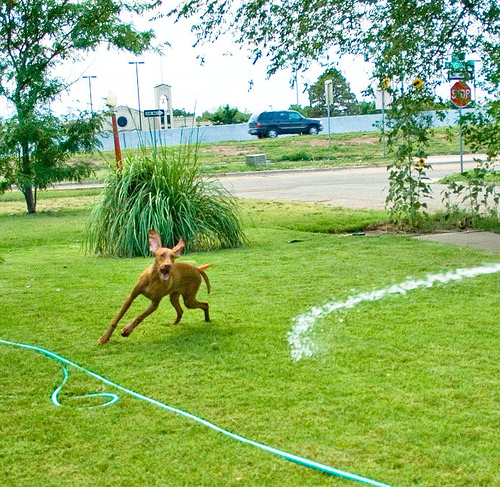

In [ ]:
from PIL import Image
img = Image.open('/content/Flickr8k_Dataset/Flicker8k_Dataset/1019077836_6fc9b15408.jpg')
# imagePath = '/content/drive/MyDrive/ML/Flicker8k_Dataset/3738685861_8dfff28760.jpg'
# img = Image.open(imagePath)
img

In [ ]:
!python3 '/content/drive/MyDrive/Image_Caption/Image_Caption/testing_caption_generator.py' -i '/content/Flickr8k_Dataset/Flicker8k_Dataset/1019077836_6fc9b15408.jpg'
# !python3 '/content/drive/MyDrive/ML/testing_caption_generator.py' -i '/content/drive/MyDrive/ML/Flicker8k_Dataset/3738685861_8dfff28760.jpg'

2023-05-14 19:05:30.843711: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-14 19:05:33.893538: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
1/1 [==============================] - 3s 3s/step



start two dogs are playing on the grass end
